In [3]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
from scipy.stats import ks_2samp, mannwhitneyu
from sklearn.metrics import average_precision_score

from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_parquet("DATA/dataset/train_stage2")

In [3]:
LABEL = "fraud"

def evaluate_numeric_feature(df: pd.DataFrame, feature: str) -> pd.Series:
    s = df[feature].astype(float)          # statsmodels/metric 안정화
    y = df[LABEL].astype(int)

    x_nf = s[y == 0]
    x_f  = s[y == 1]

    # KS / MW
    ks_stat, ks_p = ks_2samp(x_nf, x_f)
    mw_stat, mw_p = mannwhitneyu(x_nf, x_f, alternative="two-sided")

    # Cohen's d (pooled std=0 방지)
    nx, nz = len(x_f), len(x_nf)
    sx, sz = x_f.std(), x_nf.std()
    pooled = np.sqrt(((nx - 1) * sx**2 + (nz - 1) * sz**2) / (nx + nz - 2))
    d = np.nan if pooled == 0 or np.isnan(pooled) else (x_f.mean() - x_nf.mean()) / pooled

    # 단변량 PR-AUC (방향성 보정)
    pr_auc = max(
        average_precision_score(y, s),
        average_precision_score(y, -s),
    )

    # 단변량 logit
    odds_ratio = np.nan
    logit_p = np.nan
    try:
        X = sm.add_constant(s.to_frame(name=feature))
        model = sm.Logit(y, X).fit(disp=0)
        odds_ratio = float(np.exp(model.params[feature]))
        logit_p = float(model.pvalues[feature])
    except Exception:
        pass

    return pd.Series({
        "KS_p": float(ks_p),
        "MW_p": float(mw_p),
        "Cohen_d": float(d) if np.isfinite(d) else np.nan,
        "Odds_Ratio": float(odds_ratio) if np.isfinite(odds_ratio) else np.nan,
        "Logit_p": float(logit_p) if np.isfinite(logit_p) else np.nan,
        "PR_AUC": float(pr_auc),
        "n": int(len(s)),
        "pos_rate": float(y.mean()),
    })



EXCLUDE = {"date", "client_id", "card_id", "merchant_id", LABEL}

candidate_features = [
    c for c in df.columns
    if c not in EXCLUDE and pd.api.types.is_numeric_dtype(df[c])
]

rows = []
for f in tqdm(candidate_features, desc="Univariate feature screening"):
    # 상수 컬럼이면 스킵(안정성)
    if df[f].nunique() <= 1:
        continue
    r = evaluate_numeric_feature(df, f)
    r.name = f
    rows.append(r)

res = pd.DataFrame(rows)
res.index.name = "feature"

res_sorted = res.sort_values("PR_AUC", ascending=False)

Univariate feature screening:   0%|          | 0/58 [00:00<?, ?it/s]

/home/nakyung/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [4]:
res_sorted.to_csv("artifacts/univariate_screening_train.csv", encoding="utf-8-sig")

In [5]:
res_sorted

,KS_p,MW_p,Cohen_d,Odds_Ratio,Logit_p,PR_AUC,n,pos_rate
feature,,,,,,,,
log_abs_amount,0.000000e+00,0.000000e+00,0.678800,1.938924e+00,0.000000e+00,0.006434,5332948.0,0.001448
amount,0.000000e+00,0.000000e+00,0.890013,1.002701e+00,0.000000e+00,0.006129,5332948.0,0.001448
amount_income_ratio,0.000000e+00,0.000000e+00,0.431009,1.044427e+00,6.924820e-31,0.006045,5332948.0,0.001448
amount_limit_ratio,0.000000e+00,0.000000e+00,0.117168,1.000000e+00,1.371724e-11,0.003587,5332948.0,0.001448
mccg_Industrial__Manufacturing,1.176862e-43,0.000000e+00,0.760449,8.916010e+00,0.000000e+00,0.002389,5332948.0,0.001448
mccg_Retail,7.350437e-125,0.000000e+00,0.681341,4.993347e+00,0.000000e+00,0.002287,5332948.0,0.001448
err_bad_cvv,1.235453e-01,0.000000e+00,0.625235,3.182257e+01,6.645506e-265,0.002031,5332948.0,0.001448
tx_year,5.186072e-213,1.972874e-01,-0.022700,9.867526e-01,4.622007e-02,0.001962,5332948.0,0.001448
credit_limit,2.331154e-40,1.023227e-48,-0.154518,9.999848e-01,6.545587e-43,0.001795,5332948.0,0.001448


In [6]:
df.shape

(5332948, 64)

### Logit_p 기준 filtering

In [7]:
alpha = 0.05

sig = res_sorted[
    (res_sorted["Logit_p"] < alpha) &
    (res_sorted["KS_p"] < alpha) &
    (res_sorted["MW_p"] < alpha)
].copy()

sig_feature_names = sig.index.tolist()
print(f"kept_features = {len(sig_feature_names)}")

kept_features = 34


In [8]:
sig_feature_names

['log_abs_amount',
 'amount',
 'amount_income_ratio',
 'amount_limit_ratio',
 'mccg_Industrial__Manufacturing',
 'mccg_Retail',
 'credit_limit',
 'tx_hour',
 'num_credit_cards',
 'log_yearly_income',
 'yearly_income',
 'mccg_Food_Daily',
 'mccg_Automotive_Home',
 'mccg_Digital_Online',
 'per_capita_income',
 'years_to_retirement',
 'months_to_expire',
 'birth_year',
 'current_age',
 'is_prepaid',
 'income_ratio_region',
 'log_income_ratio_region',
 'has_error',
 'tx_month',
 'years_since_pin_change',
 'total_debt',
 'is_weekend',
 'expires_year',
 'year_pin_last_changed',
 'tx_day',
 'mccg_Entertainment',
 'cb_Visa',
 'mccg_Utilities_Government',
 'mccg_Financial']

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5332948 entries, 0 to 5332978
Data columns (total 64 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   date                            datetime64[ns]
 1   client_id                       int64         
 2   card_id                         int64         
 3   amount                          float32       
 4   merchant_id                     int64         
 5   mcc                             object        
 6   fraud                           int8          
 7   has_error                       int8          
 8   err_bad_card_number             int8          
 9   err_bad_expiration              int8          
 10  err_bad_cvv                     int8          
 11  err_bad_pin                     int8          
 12  err_bad_zipcode                 int8          
 13  err_insufficient_balance        int8          
 14  err_technical_glitch            int8          
 15  tx_

---

## 0) 식별자/메타 컬럼 (분석은 ‘분리/집계’ 목적, 모델엔 보통 제외)

* `date` : 시계열 분포/드리프트/계절성 확인용 (모델 입력은 보통 time feature로만)
* `client_id` : 고객 단위 집계 피처 만들 때 키
* `card_id` : 카드 단위 집계/행동 피처 만들 때 키
* `merchant_id` : 가맹점 단위 집계/위험도 피처 만들 때 키

**분석 포인트**

* 키별 거래수 분포(heavy user / heavy merchant)
* fraud가 특정 key에 몰리는지(집중도)
* key별 “과거 이력 기반” 피처 만들 여지
---

In [10]:
LABEL = "fraud"

### 1️⃣ date — 시계열 분포 & fraud drift

1-1) 월별 거래 수

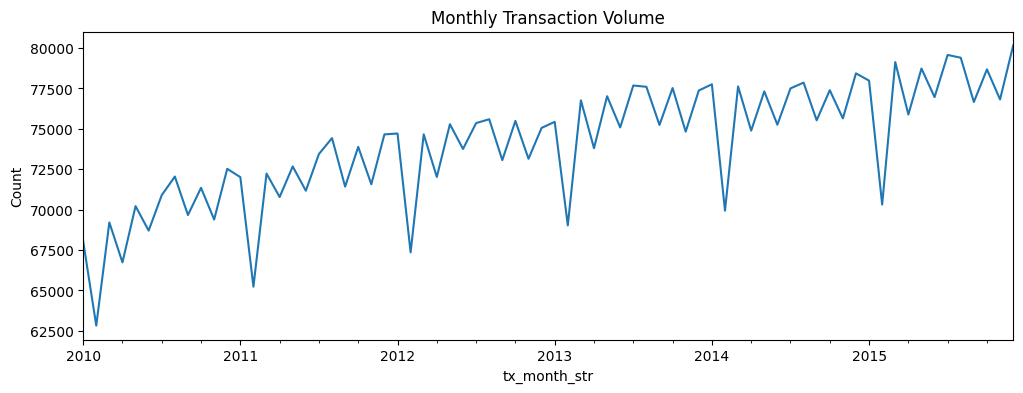

In [11]:
monthly_tx = (
    df
    .assign(tx_month_str=df["date"].dt.to_period("M"))
    .groupby("tx_month_str")
    .size()
)

plt.figure(figsize=(12,4))
monthly_tx.plot()
plt.title("Monthly Transaction Volume")
plt.ylabel("Count")
plt.show()

1-2) 월별 fraud rate

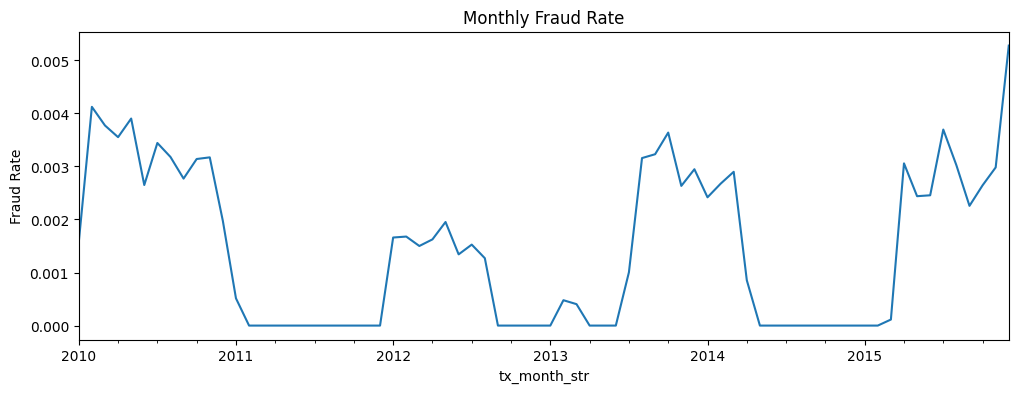

In [12]:
monthly_fraud = (
    df
    .assign(tx_month_str=df["date"].dt.to_period("M"))
    .groupby("tx_month_str")[LABEL]
    .mean()
)

plt.figure(figsize=(12,4))
monthly_fraud.plot()
plt.title("Monthly Fraud Rate")
plt.ylabel("Fraud Rate")
plt.show()


### 2️⃣ client_id — 고객 단위 분석

2-1) 고객별 거래 수 분포

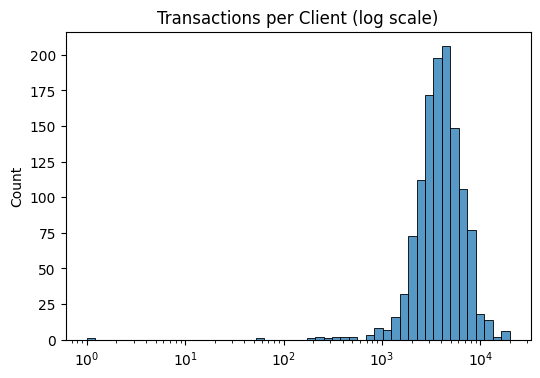

In [13]:
client_tx_count = df.groupby("client_id").size()

plt.figure(figsize=(6,4))
sns.histplot(client_tx_count, bins=50, log_scale=True)
plt.title("Transactions per Client (log scale)")
plt.show()

2-2) 고객별 fraud rate

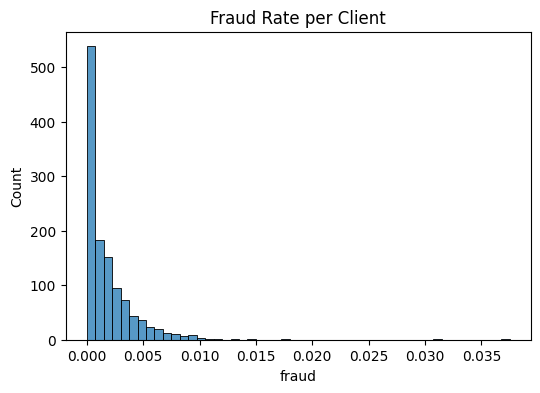

In [14]:
client_fraud_rate = df.groupby("client_id")[LABEL].mean()

plt.figure(figsize=(6,4))
sns.histplot(client_fraud_rate, bins=50)
plt.title("Fraud Rate per Client")
plt.show()

2-3) fraud 집중도 (상위 고객 비율)

In [15]:
client_fraud_sum = df.groupby("client_id")[LABEL].sum()
top_clients = client_fraud_sum.sort_values(ascending=False)

top_10_ratio = top_clients.head(10).sum() / df[LABEL].sum()

print("Top 10 clients fraud concentration:", top_10_ratio)


Top 10 clients fraud concentration: 0.04506020976304545


### 3️⃣ card_id 분석

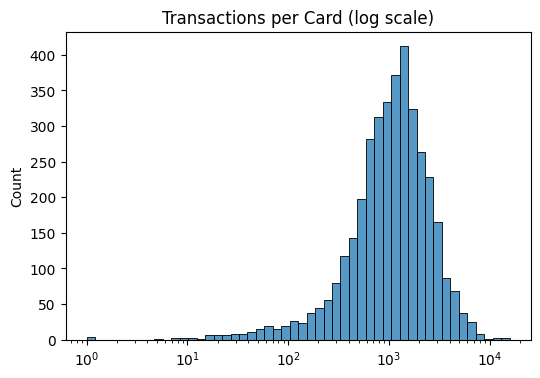

In [16]:
card_tx_count = df.groupby("card_id").size()

plt.figure(figsize=(6,4))
sns.histplot(card_tx_count, bins=50, log_scale=True)
plt.title("Transactions per Card (log scale)")
plt.show()

카드별 fraud rate

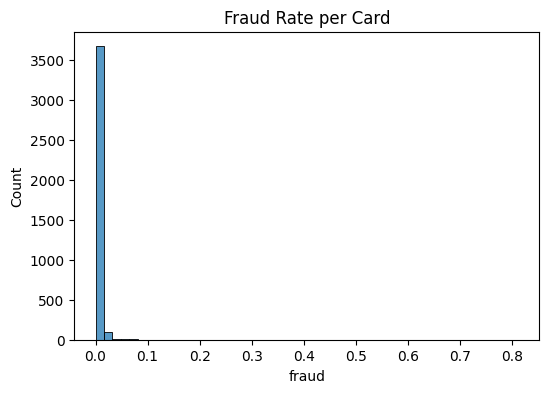

In [17]:
card_fraud_rate = df.groupby("card_id")[LABEL].mean()

plt.figure(figsize=(6,4))
sns.histplot(card_fraud_rate, bins=50)
plt.title("Fraud Rate per Card")
plt.show()


### 4️⃣ merchant_id — 가맹점 위험도

4-1) 가맹점별 거래 수

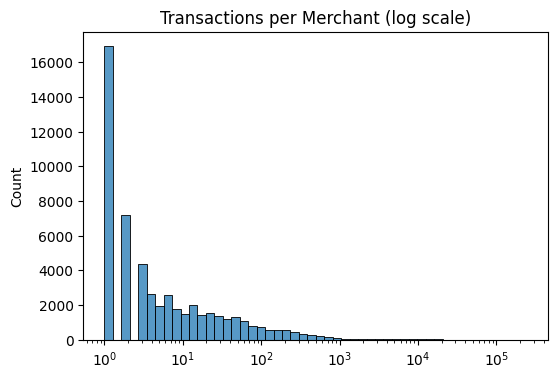

In [18]:
merchant_tx = df.groupby("merchant_id").size()

plt.figure(figsize=(6,4))
sns.histplot(merchant_tx, bins=50, log_scale=True)
plt.title("Transactions per Merchant (log scale)")
plt.show()


4-2) 가맹점별 fraud rate

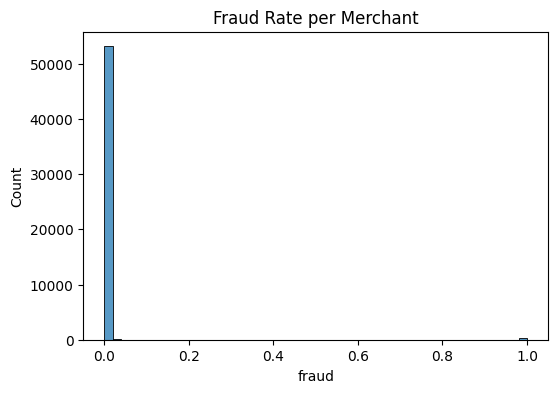

In [19]:
merchant_fraud = df.groupby("merchant_id")[LABEL].mean()

plt.figure(figsize=(6,4))
sns.histplot(merchant_fraud, bins=50)
plt.title("Fraud Rate per Merchant")
plt.show()

4-3) fraud 집중도 (상위 가맹점)

In [20]:
merchant_fraud_sum = df.groupby("merchant_id")[LABEL].sum()
top_merchants = merchant_fraud_sum.sort_values(ascending=False)

top_10_ratio = top_merchants.head(10).sum() / df[LABEL].sum()

print("Top 10 merchants fraud concentration:", top_10_ratio)

Top 10 merchants fraud concentration: 0.2822737278259744


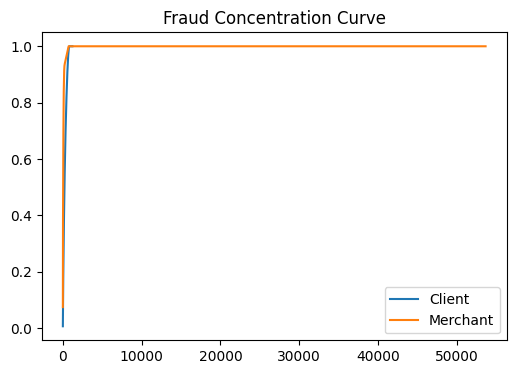

In [21]:
def concentration_ratio(group_sum):
    total = group_sum.sum()
    sorted_vals = group_sum.sort_values(ascending=False)
    cum = sorted_vals.cumsum() / total
    return cum

client_conc = concentration_ratio(client_fraud_sum)
merchant_conc = concentration_ratio(merchant_fraud_sum)

plt.figure(figsize=(6,4))
plt.plot(client_conc.values, label="Client")
plt.plot(merchant_conc.values, label="Merchant")
plt.legend()
plt.title("Fraud Concentration Curve")
plt.show()


### 📊 ID / Meta Column Structural Analysis Summary
1️⃣ Transaction Volume Trend

> 월별 거래량은 전반적으로 지속적인 증가 추세를 보임.\
> 따라서 fraud 건수 자체보다는 fraud rate 기준으로 판단해야 함.\
> 운영 단계에서는 거래량 증가에 따른 threshold 조정 전략이 필요함.

2️⃣ Fraud Rate Seasonality

> 월별 fraud rate는 약 1년 주기의 상승·하락 패턴을 보임.\
> 완전한 랜덤이 아니라 주기적/파동형 구조 존재.\
> 시간 변수는 구조적으로 의미 있는 설명 변수일 가능성이 높음.

3️⃣ Client-Level Pattern

> 대부분의 고객은 fraud가 없음.\
> 일부 고객에서 fraud가 반복적으로 발생.\
> 고객 단위의 이력 기반 리스크 효과가 존재함.\
> 과거 fraud 경험 여부, 누적 fraud 횟수 등은 유의미한 피처가 될 가능성 높음.

4️⃣ Card-Level Pattern

> 카드 단위 반복 fraud는 상대적으로 많지 않음.\
> 카드 레벨 이력 효과는 client 레벨보다 약함.

5️⃣ Merchant-Level Concentration

> fraud가 특정 merchant에 강하게 집중되어 있음.\
> 일부 merchant는 매우 높은 fraud rate를 보임.\
> 구조적 리스크가 merchant 단위에서 발생하는 패턴.\
> merchant risk score 또는 blacklist 관리가 필요할 가능성 높음.

In [22]:
df = df.sort_values("date").copy()

g_client = df.groupby("client_id")["fraud"]
df["client_prev_fraud_cnt"] = (g_client.cumsum() - df["fraud"]).astype("int32")

g_merchant = df.groupby("merchant_id")["fraud"]
df["merchant_prev_fraud_cnt"] = (g_merchant.cumsum() - df["fraud"]).astype("int32")

# 검증: 첫 거래는 무조건 0
print((df.groupby("client_id")["client_prev_fraud_cnt"].head(1) != 0).sum())
print((df.groupby("merchant_id")["merchant_prev_fraud_cnt"].head(1) != 0).sum())

0
0


In [23]:
df["month_sin"] = np.sin(2 * np.pi * df["tx_month"] / 12).astype("float32")
df["month_cos"] = np.cos(2 * np.pi * df["tx_month"] / 12).astype("float32")

In [24]:
df["day_sin"] = np.sin(2 * np.pi * df["tx_day"] / 31).astype("float32")
df["day_cos"] = np.cos(2 * np.pi * df["tx_day"] / 31).astype("float32")

In [25]:
df["hour_sin"] = np.sin(2 * np.pi * df["tx_hour"] / 24).astype("float32")
df["hour_cos"] = np.cos(2 * np.pi * df["tx_hour"] / 24).astype("float32")

In [26]:
cyc_features = [
    "month_sin", "month_cos",
    "day_sin", "day_cos",
    "hour_sin", "hour_cos"
]

for col in cyc_features:
    print(col)
    print(evaluate_numeric_feature(df, col))


month_sin
KS_p          4.384724e-17
MW_p          3.379674e-06
Cohen_d      -5.350810e-02
Odds_Ratio    9.268268e-01
Logit_p       2.637048e-06
PR_AUC        1.506958e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64
month_cos
KS_p          1.250684e-03
MW_p          5.192516e-02
Cohen_d       1.072617e-02
Odds_Ratio    1.015242e+00
Logit_p       3.462307e-01
PR_AUC        1.484123e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64
day_sin
KS_p          6.763254e-05
MW_p          2.195278e-02
Cohen_d      -3.048207e-02
Odds_Ratio    9.581692e-01
Logit_p       7.438988e-03
PR_AUC        1.474016e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64
day_cos
KS_p          5.265373e-04
MW_p          4.050431e-04
Cohen_d       4.148078e-02
Odds_Ratio    1.061001e+00
Logit_p       2.705950e-04
PR_AUC        1.493931e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64
hour_sin
KS_p          3.221279e-174
MW_

사기가 특정 시간대 / 특정 월 주기 위치에서 비대칭적으로 발생

Month별 Fraud Rate 시각화

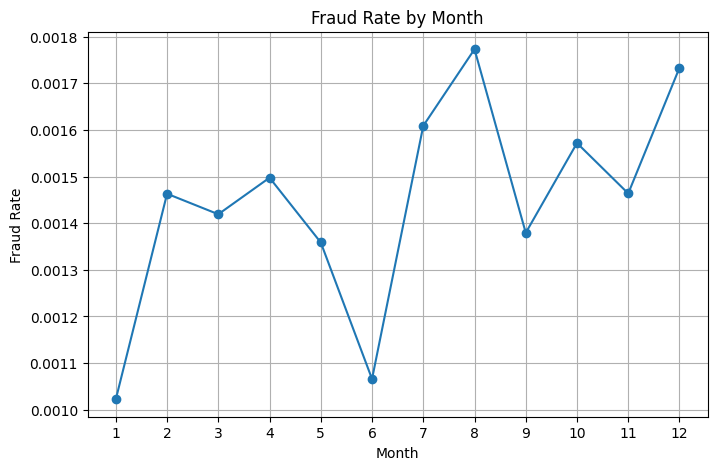

    tx_month      mean   count
0          1  0.001023  445907
1          2  0.001463  404638
2          3  0.001419  449578
3          4  0.001497  434073
4          5  0.001359  451210
5          6  0.001066  440891
6          7  0.001609  454417
7          8  0.001773  456894
8          9  0.001379  441544
9         10  0.001572  454281
10        11  0.001464  441355
11        12  0.001733  458160


In [27]:
# month별 fraud rate
month_stat = (
    df.groupby("tx_month")["fraud"]
      .agg(["mean", "count"])
      .reset_index()
      .sort_values("tx_month")
)

plt.figure(figsize=(8,5))
plt.plot(month_stat["tx_month"], month_stat["mean"], marker="o")
plt.title("Fraud Rate by Month")
plt.xlabel("Month")
plt.ylabel("Fraud Rate")
plt.xticks(range(1,13))
plt.grid(True)
plt.show()

print(month_stat)


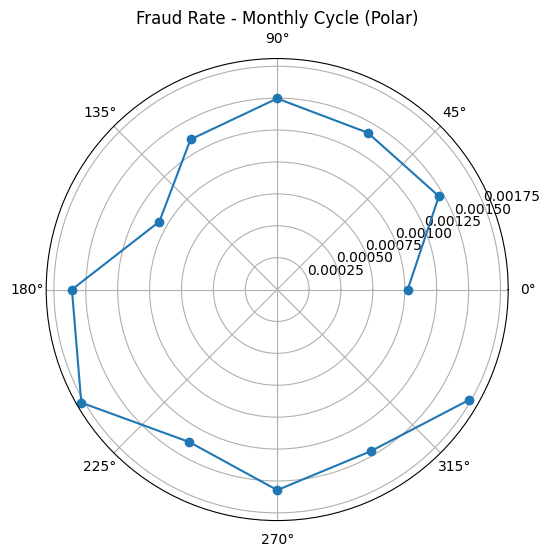

In [28]:
theta = 2 * np.pi * (month_stat["tx_month"] - 1) / 12

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, polar=True)
ax.plot(theta, month_stat["mean"], marker="o")
ax.set_title("Fraud Rate - Monthly Cycle (Polar)")
plt.show()

> 최저: 1월 (~0.0074), 6월 (~0.0081)\
> 최고: 8월 (~0.0136), 12월 (~0.0128), 10월 (~0.0121)

Hour별 Fraud Rate 시각화

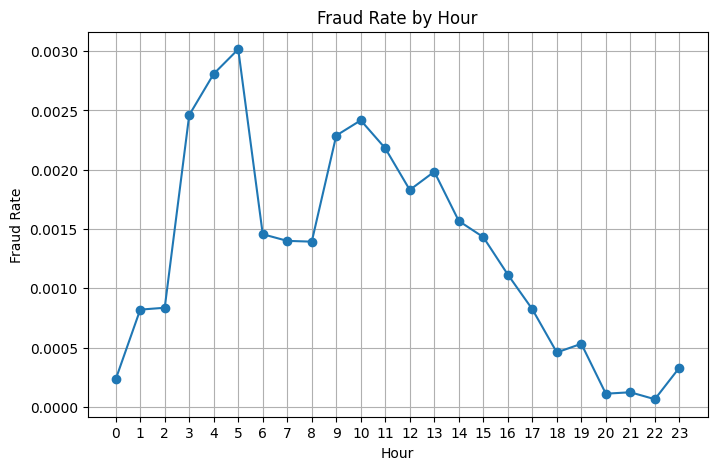

    tx_hour      mean   count
0         0  0.000233   55695
1         1  0.000821   46303
2         2  0.000836   45431
3         3  0.002461   41450
4         4  0.002808   45935
5         5  0.003016   73283
6         6  0.001456  302145
7         7  0.001400  362074
8         8  0.001394  352327
9         9  0.002288  350926
10       10  0.002416  349276
11       11  0.002180  377454
12       12  0.001830  382047
13       13  0.001983  361495
14       14  0.001568  357165
15       15  0.001432  345018
16       16  0.001116  346691
17       17  0.000824  194179
18       18  0.000460  189203
19       19  0.000533  183994
20       20  0.000112  169745
21       21  0.000124  169388
22       22  0.000065  168288
23       23  0.000331   63436


In [29]:
hour_stat = (
    df.groupby("tx_hour")["fraud"]
      .agg(["mean", "count"])
      .reset_index()
      .sort_values("tx_hour")
)

plt.figure(figsize=(8,5))
plt.plot(hour_stat["tx_hour"], hour_stat["mean"], marker="o")
plt.title("Fraud Rate by Hour")
plt.xlabel("Hour")
plt.ylabel("Fraud Rate")
plt.xticks(range(0,24))
plt.grid(True)
plt.show()

print(hour_stat)


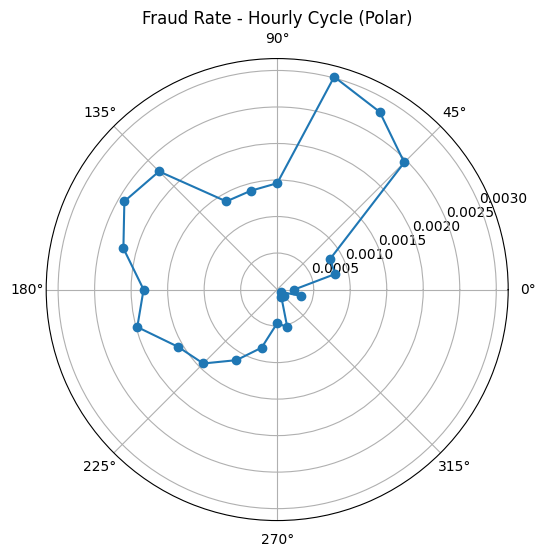

In [30]:
theta = 2 * np.pi * hour_stat["tx_hour"] / 24

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, polar=True)
ax.plot(theta, hour_stat["mean"], marker="o")
ax.set_title("Fraud Rate - Hourly Cycle (Polar)")
plt.show()

🔺 고위험 시간대

    03시 (~1.94%)
    05시 (~1.97%)
    09~12시 (1.8~1.9%)

🔻 저위험 시간대

    20~22시 (0.07~0.1%)
    0시 (0.1%)

---

## 1) 타깃/라벨

* `fraud` : 0/1

**분석 포인트**

* base rate
* 클래스 비율 변화(시간축 drift)

---

In [31]:
# 전체 base rate
base_rate = df["fraud"].mean()

print(f"Overall Fraud Rate: {base_rate:.6f}")
print(df["fraud"].value_counts(normalize=True))


Overall Fraud Rate: 0.001448
fraud
0    0.998552
1    0.001448
Name: proportion, dtype: float64


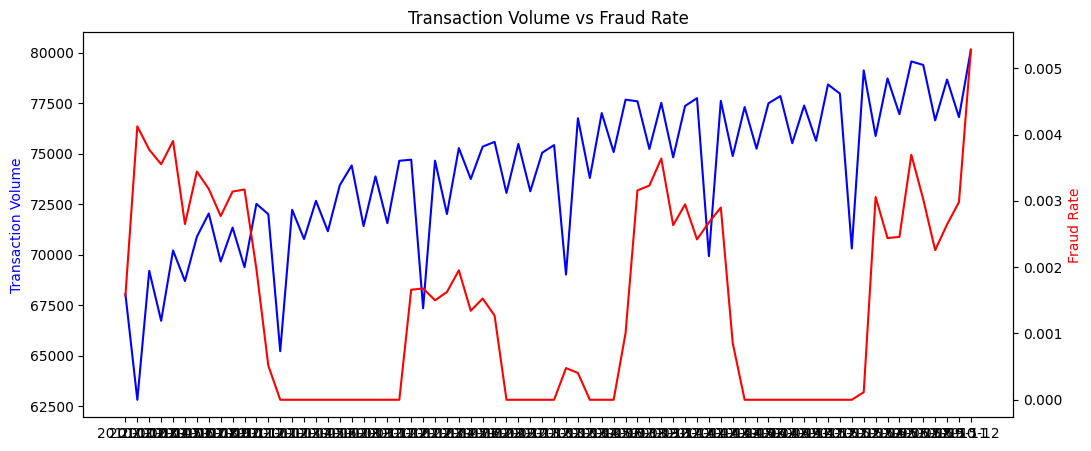

In [32]:
monthly_full = (
    df.groupby(["tx_year", "tx_month"])["fraud"]
      .agg(["mean", "count"])
      .reset_index()
)

monthly_full["year_month"] = (
    monthly_full["tx_year"].astype(str) + "-" +
    monthly_full["tx_month"].astype(str).str.zfill(2)
)

fig, ax1 = plt.subplots(figsize=(12,5))

ax1.plot(monthly_full["year_month"], monthly_full["count"], color="blue")
ax1.set_ylabel("Transaction Volume", color="blue")

ax2 = ax1.twinx()
ax2.plot(monthly_full["year_month"], monthly_full["mean"], color="red")
ax2.set_ylabel("Fraud Rate", color="red")

plt.xticks(rotation=90)
plt.title("Transaction Volume vs Fraud Rate")
plt.show()


In [33]:
q_hi = monthly_full["mean"].quantile(0.75)
q_lo = monthly_full["mean"].quantile(0.25)

print("q_hi:", q_hi, "q_lo:", q_lo)
print("n_high_months:", (monthly_full["mean"] > q_hi).sum())
print("n_low_months :", (monthly_full["mean"] < q_lo).sum())
print("n_eq_qlo     :", (monthly_full["mean"] == q_lo).sum())


q_hi: 0.002802673569514297 q_lo: 0.0
n_high_months: 18
n_low_months : 0
n_eq_qlo     : 29


In [34]:
# 1) quantile
q_hi = monthly_full["mean"].quantile(0.75)
q_lo = monthly_full["mean"].quantile(0.25)

print("q_hi:", q_hi, "q_lo:", q_lo)

# 2) high/low 정의: 너가 말한대로 경계 포함
high_period = monthly_full[monthly_full["mean"] >= q_hi].copy()
low_period  = monthly_full[monthly_full["mean"] <= q_lo].copy()

print("n_high_months:", len(high_period))
print("n_low_months :", len(low_period))

# 3) key 만들기 (여기도 반드시 >=, <= 로)
high_keys = list(zip(high_period["tx_year"], high_period["tx_month"]))
low_keys  = list(zip(low_period["tx_year"],  low_period["tx_month"]))

# 4) df에 period_group 라벨링
df = df.copy()
df["period_group"] = "mid"

pairs = pd.MultiIndex.from_arrays([df["tx_year"], df["tx_month"]])

if len(high_keys) > 0:
    df.loc[pairs.isin(pd.MultiIndex.from_tuples(high_keys)), "period_group"] = "high"

if len(low_keys) > 0:
    df.loc[pairs.isin(pd.MultiIndex.from_tuples(low_keys)), "period_group"] = "low"

# 5) 분리
df_h = df[df["period_group"] == "high"].copy()
df_l = df[df["period_group"] == "low"].copy()

print(df_h.shape, df_l.shape)
print("high fraud rate:", df_h["fraud"].mean(), " low fraud rate:", df_l["fraud"].mean())


q_hi: 0.002802673569514297 q_lo: 0.0
n_high_months: 18
n_low_months : 29
(1329740, 73) (2152637, 73)
high fraud rate: 0.0034510505813166482  low fraud rate: 0.0


In [35]:
EXCLUDE = {
    "fraud", "date", "period_group",
    "client_id", "card_id", "merchant_id"
}

feature_cols = [c for c in df.columns if c not in EXCLUDE]

# 수치형/이진형 분리
num_cols = [c for c in feature_cols if pd.api.types.is_numeric_dtype(df[c])]
bin_cols = [c for c in num_cols if df[c].dropna().isin([0, 1]).all()]
cont_cols = [c for c in num_cols if c not in bin_cols]

print("cont:", len(cont_cols), "bin:", len(bin_cols))

cont: 37 bin: 29


In [36]:
from scipy.stats import ks_2samp, mannwhitneyu

def cohens_d(a, b):
    a = np.asarray(a); b = np.asarray(b)
    na, nb = len(a), len(b)
    if na < 2 or nb < 2:
        return np.nan
    sa, sb = a.std(ddof=1), b.std(ddof=1)
    pooled = np.sqrt(((na-1)*sa**2 + (nb-1)*sb**2) / (na+nb-2))
    return (a.mean() - b.mean()) / (pooled + 1e-12)

rows = []
for col in cont_cols:
    xh = df_h[col].dropna()
    xl = df_l[col].dropna()
    if len(xh) < 30 or len(xl) < 30:
        continue

    ks_p = ks_2samp(xh, xl).pvalue
    mw_p = mannwhitneyu(xh, xl, alternative="two-sided").pvalue
    d = cohens_d(xh, xl)

    rows.append({
        "feature": col,
        "type": "continuous",
        "high_mean": float(xh.mean()),
        "low_mean": float(xl.mean()),
        "delta_mean": float(xh.mean() - xl.mean()),
        "cohen_d": float(d),
        "KS_p": float(ks_p),
        "MW_p": float(mw_p),
        "n_high": int(len(xh)),
        "n_low": int(len(xl)),
    })

res_cont = pd.DataFrame(rows).set_index("feature").sort_values("MW_p")
res_cont.head(10)


,type,high_mean,low_mean,delta_mean,cohen_d,KS_p,MW_p,n_high,n_low
feature,,,,,,,,,
tx_year,continuous,2012.400939,2012.550268,-0.149329,-0.086510,0.000000e+00,0.000000e+00,1329740,2152637
tx_month,continuous,7.548097,7.138608,0.409490,0.123981,0.000000e+00,0.000000e+00,1329740,2152637
month_sin,continuous,-0.143637,-0.106326,-0.037312,-0.053816,0.000000e+00,0.000000e+00,1329740,2152637
client_prev_fraud_cnt,continuous,3.260689,3.389368,-0.128679,-0.023156,0.000000e+00,0.000000e+00,1329740,2152637
month_cos,continuous,0.009804,0.016600,-0.006796,-0.009571,0.000000e+00,0.000000e+00,1329740,2152637
years_since_pin_change,continuous,2.087902,2.061717,0.026185,0.011852,0.000000e+00,2.389263e-224,1329740,2152637
merchant_prev_fraud_cnt,continuous,19.707478,18.298660,1.408818,0.022432,0.000000e+00,4.686511e-88,1329740,2152637
months_to_expire,continuous,103.871037,102.814616,1.056421,0.029396,0.000000e+00,9.615931e-33,1329740,2152637
day_cos,continuous,-0.014127,-0.020249,0.006122,0.008735,3.739874e-16,4.692913e-19,1329740,2152637


In [37]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency, fisher_exact

rows = []
for col in bin_cols:
    xh = df_h[col].astype(int)
    xl = df_l[col].astype(int)

    a1 = int((xh == 1).sum()); a0 = int((xh == 0).sum())
    b1 = int((xl == 1).sum()); b0 = int((xl == 0).sum())

    n_high = a1 + a0
    n_low  = b1 + b0

    if n_high < 30 or n_low < 30:
        continue

    table = np.array([[a1, a0],
                      [b1, b0]], dtype=int)

    # rate
    high_rate = a1 / (n_high + 1e-12)
    low_rate  = b1 / (n_low  + 1e-12)

    # 0 cell이 있으면 Fisher로 
    if (table == 0).any():
        odds, p = fisher_exact(table, alternative="two-sided")
        test = "fisher"
        chi2 = np.nan
    else:
        chi2, p, _, _ = chi2_contingency(table, correction=False)
        odds = (a1 * b0) / (a0 * b1 + 1e-12) 
        test = "chi2"

    rows.append({
        "feature": col,
        "type": "binary",
        "high_rate": float(high_rate),
        "low_rate": float(low_rate),
        "delta_rate": float(high_rate - low_rate),
        "p_value": float(p),
        "test": test,
        "odds_ratio": float(odds) if np.isfinite(odds) else np.nan,
        "a1_high": a1, "a0_high": a0,
        "b1_low": b1,  "b0_low": b0,
        "n_high": int(n_high),
        "n_low": int(n_low),
    })

res_bin = pd.DataFrame(rows).set_index("feature").sort_values("p_value")
res_bin.head(20)


,type,high_rate,low_rate,delta_rate,p_value,test,odds_ratio,a1_high,a0_high,b1_low,b0_low,n_high,n_low
feature,,,,,,,,,,,,,
is_weekend,binary,0.289672,0.281542,0.008130,5.599968e-60,chi2,1.040653,385188,944552,606057,1546580,1329740,2152637
has_chip,binary,0.900538,0.898558,0.001980,2.433316e-09,chi2,1.022155,1197482,132258,1934270,218367,1329740,2152637
mccg_Industrial__Manufacturing,binary,0.011611,0.011021,0.000589,4.072592e-07,chi2,1.054085,15439,1314301,23725,2128912,1329740,2152637
mccg_Retail,binary,0.042273,0.041371,0.000902,4.287435e-05,chi2,1.022772,56212,1273528,89056,2063581,1329740,2152637
cb_Amex,binary,0.065968,0.065308,0.000660,1.562788e-02,chi2,1.010819,87720,1242020,140584,2012053,1329740,2152637
is_refund,binary,0.050508,0.049975,0.000533,2.675370e-02,chi2,1.011241,67163,1262577,107578,2045059,1329740,2152637
err_bad_cvv,binary,0.000493,0.000444,0.000049,3.801430e-02,chi2,1.110891,656,1329084,956,2151681,1329740,2152637
mccg_Entertainment,binary,0.019317,0.019571,-0.000254,9.519102e-02,chi2,0.986749,25686,1304054,42129,2110508,1329740,2152637
mccg_Food_Daily,binary,0.529178,0.530086,-0.000908,9.915760e-02,chi2,0.996363,703669,626071,1141082,1011555,1329740,2152637


In [38]:
alpha = 0.05

sig_cont = res_cont[
    (res_cont["MW_p"] < alpha) &
    (res_cont["KS_p"] < alpha) &
    (res_cont["cohen_d"].abs() >= 0.10)
].sort_values("MW_p")

sig_cont.head(30)


,type,high_mean,low_mean,delta_mean,cohen_d,KS_p,MW_p,n_high,n_low
feature,,,,,,,,,
tx_month,continuous,7.548097,7.138608,0.40949,0.123981,0.0,0.0,1329740,2152637


In [39]:
alpha = 0.05
min_delta = 0.005 

sig_bin = res_bin[
    (res_bin["p_value"] < alpha) &
    (res_bin["delta_rate"].abs() >= min_delta)
].sort_values("p_value")

print("kept:", len(sig_bin))
sig_bin.head(30)


kept: 1


,type,high_rate,low_rate,delta_rate,p_value,test,odds_ratio,a1_high,a0_high,b1_low,b0_low,n_high,n_low
feature,,,,,,,,,,,,,
is_weekend,binary,0.289672,0.281542,0.00813,5.599968e-60,chi2,1.040653,385188,944552,606057,1546580,1329740,2152637


High fraud period는

> 특정 계절에 집중\
> PIN 변경 직후 기간과 연관\
> 카드 만료 기간과 약한 연관

-> sin, cos 넣은 것은 합리적


---

## 2) 거래 금액/결제 이벤트 핵심 (가장 직접적인 신호)

* `amount`
* `is_refund` (amount<0)
* `log_abs_amount`
* `amount_income_ratio`
* `amount_limit_ratio`

**분석 포인트**

* fraud vs non-fraud 분포(특히 long-tail)
* refund(음수) 케이스가 fraud와 실제로 연관 있는지
* ratio류(소득/한도 대비)가 “극단값”에서만 먹는지
* 금액 관련 파생끼리 상관/중복 여부

---


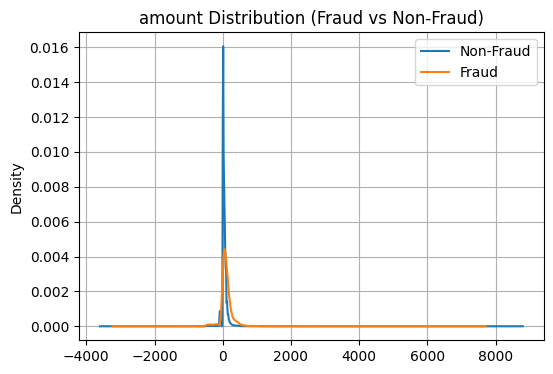

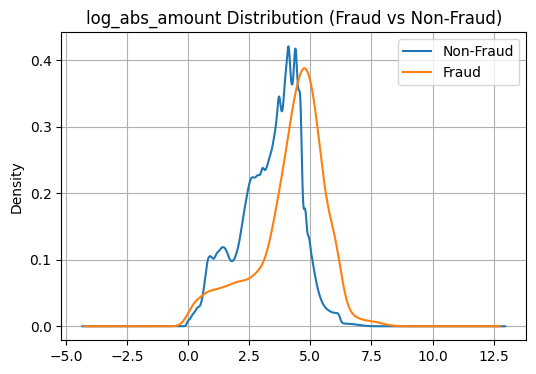

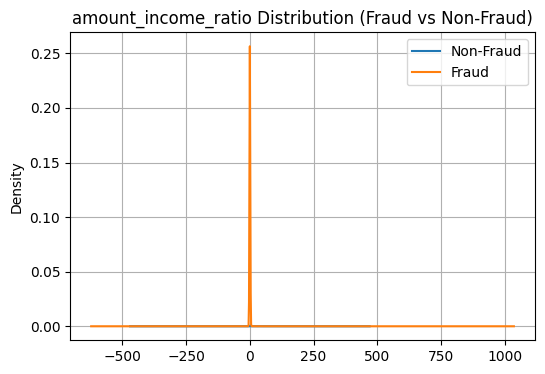

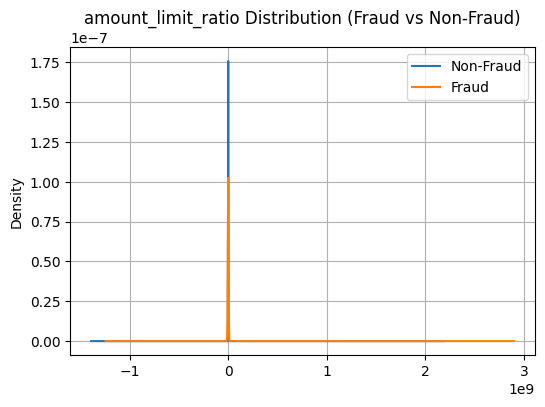

In [40]:
money_cols = [
    "amount",
    "log_abs_amount",
    "amount_income_ratio",
    "amount_limit_ratio"
]

for col in money_cols:
    plt.figure(figsize=(6,4))
    
    df[df["fraud"] == 0][col].plot(kind="kde", label="Non-Fraud")
    df[df["fraud"] == 1][col].plot(kind="kde", label="Fraud")
    
    plt.title(f"{col} Distribution (Fraud vs Non-Fraud)")
    plt.legend()
    plt.grid(True)
    plt.show()


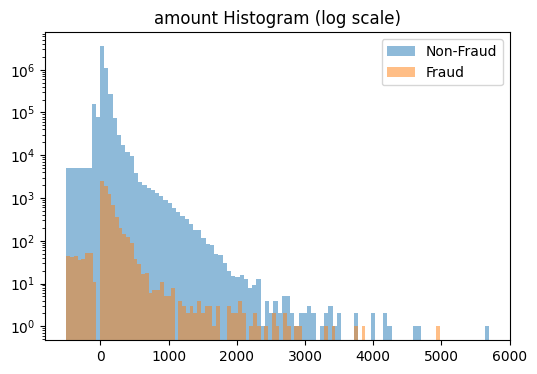

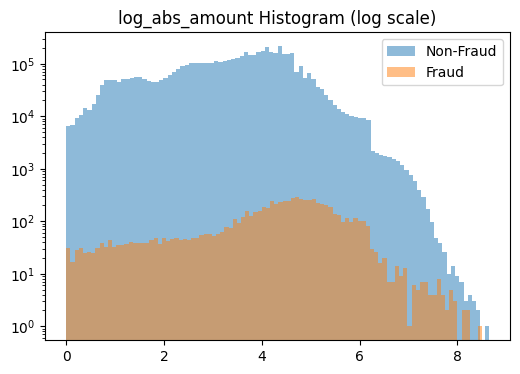

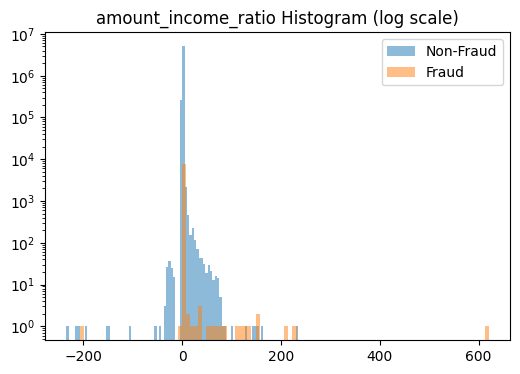

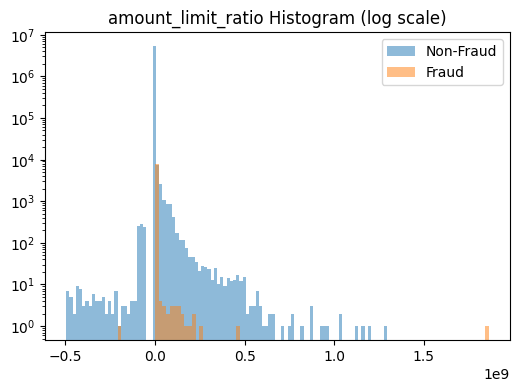

In [41]:
for col in money_cols:
    plt.figure(figsize=(6,4))
    
    plt.hist(df[df["fraud"]==0][col], bins=100, alpha=0.5, label="Non-Fraud")
    plt.hist(df[df["fraud"]==1][col], bins=100, alpha=0.5, label="Fraud")
    
    plt.yscale("log")
    plt.title(f"{col} Histogram (log scale)")
    plt.legend()
    plt.show()

In [42]:
for col in money_cols:
    print(f"\n===== Statistical Test: {col} =====")
    print(evaluate_numeric_feature(df, col))


===== Statistical Test: amount =====
KS_p          0.000000e+00
MW_p          0.000000e+00
Cohen_d       8.900128e-01
Odds_Ratio    1.002701e+00
Logit_p       0.000000e+00
PR_AUC        6.129450e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64

===== Statistical Test: log_abs_amount =====
KS_p          0.000000e+00
MW_p          0.000000e+00
Cohen_d       6.788001e-01
Odds_Ratio    1.938924e+00
Logit_p       0.000000e+00
PR_AUC        6.433742e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64

===== Statistical Test: amount_income_ratio =====
KS_p          0.000000e+00
MW_p          0.000000e+00
Cohen_d       4.310085e-01
Odds_Ratio    1.044427e+00
Logit_p       6.924820e-31
PR_AUC        6.045118e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64

===== Statistical Test: amount_limit_ratio =====
KS_p          0.000000e+00
MW_p          0.000000e+00
Cohen_d       1.171678e-01
Odds_Ratio    1.000000e+00
Logit_p       

In [43]:
refund_stats = df.groupby("fraud")["is_refund"].mean()
print("Refund rate by fraud:")
print(refund_stats)

Refund rate by fraud:
fraud
0    0.050100
1    0.041305
Name: is_refund, dtype: float64


In [44]:
from scipy.stats import chi2_contingency, fisher_exact

a1 = ((df["fraud"]==1) & (df["is_refund"]==1)).sum()
a0 = ((df["fraud"]==1) & (df["is_refund"]==0)).sum()
b1 = ((df["fraud"]==0) & (df["is_refund"]==1)).sum()
b0 = ((df["fraud"]==0) & (df["is_refund"]==0)).sum()

table = np.array([[a1,a0],[b1,b0]])

if (table==0).any():
    odds, p = fisher_exact(table)
    print("Fisher p:", p, "odds_ratio:", odds)
else:
    chi2,p,_,_ = chi2_contingency(table)
    print("Chi2 p:", p)


Chi2 p: 0.00044037458788963204


In [45]:
df[df["is_refund"] == 1]["fraud"].mean()

np.float64(0.0011942555931594237)

refund × client 과거 fraud 이력 관계

In [46]:
df.groupby(df["client_prev_fraud_cnt"] > 0)["is_refund"].mean()

client_prev_fraud_cnt
False    0.050999
True     0.048553
Name: is_refund, dtype: float64

refund & fraud 거래의 amount 분포

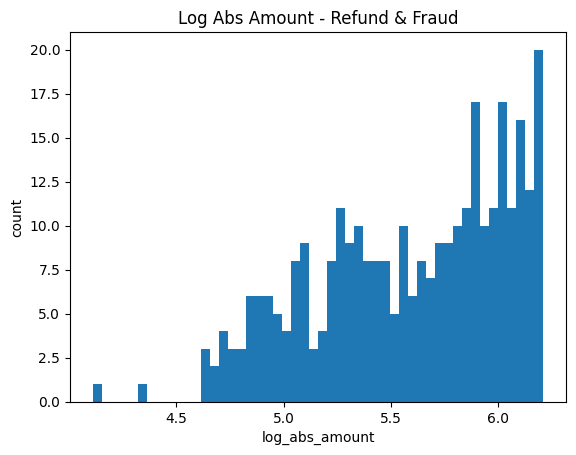

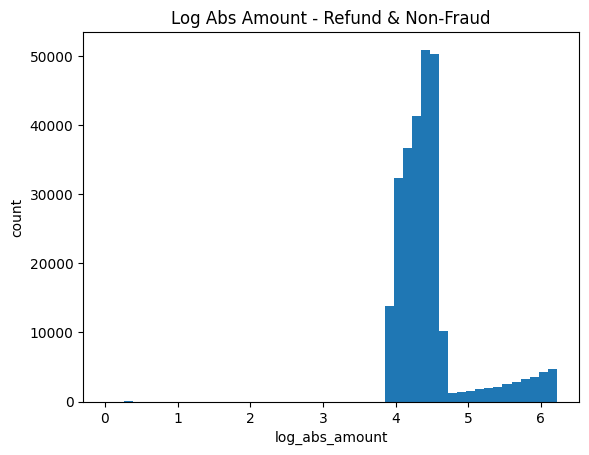

Mean amount (refund+fraud): -293.2069
Mean amount (refund+nonfraud): -102.134865


In [47]:
df_rf = df[(df["is_refund"] == 1) & (df["fraud"] == 1)]
df_rn = df[(df["is_refund"] == 1) & (df["fraud"] == 0)]

plt.figure()
plt.hist(np.log1p(np.abs(df_rf["amount"])), bins=50)
plt.title("Log Abs Amount - Refund & Fraud")
plt.xlabel("log_abs_amount")
plt.ylabel("count")
plt.show()

plt.figure()
plt.hist(np.log1p(np.abs(df_rn["amount"])), bins=50)
plt.title("Log Abs Amount - Refund & Non-Fraud")
plt.xlabel("log_abs_amount")
plt.ylabel("count")
plt.show()

print("Mean amount (refund+fraud):", df_rf["amount"].mean())
print("Mean amount (refund+nonfraud):", df_rn["amount"].mean())

> refund & fraud는 고금액 쪽에 몰려 있음

refund & fraud 거래의 merchant 분포

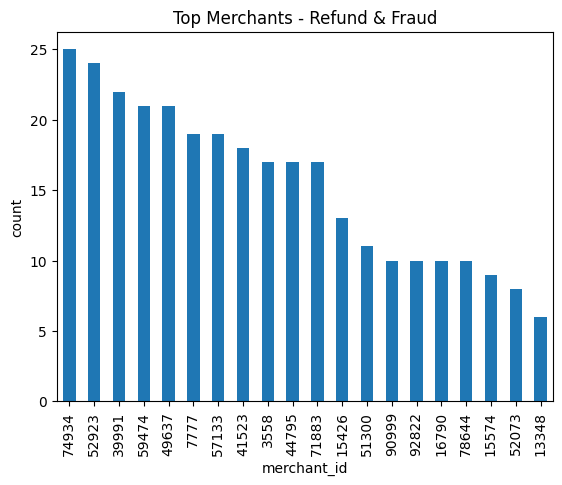

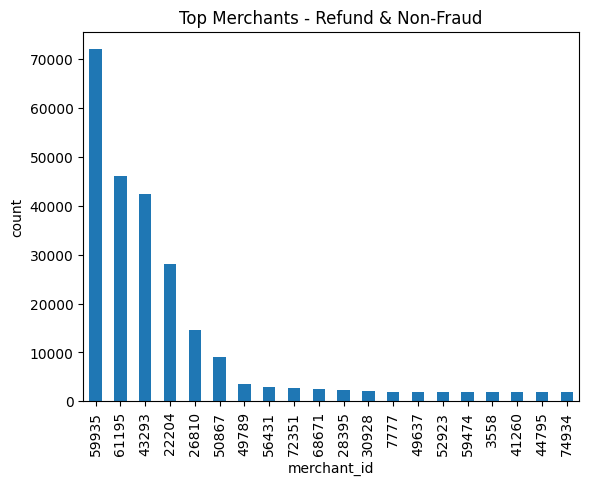

Unique merchants (refund+fraud): 26
Unique merchants (refund+nonfraud): 1495


In [48]:
top_rf = (
    df_rf["merchant_id"]
    .value_counts()
    .head(20)
)

top_rn = (
    df_rn["merchant_id"]
    .value_counts()
    .head(20)
)

plt.figure()
top_rf.plot(kind="bar")
plt.title("Top Merchants - Refund & Fraud")
plt.ylabel("count")
plt.show()

plt.figure()
top_rn.plot(kind="bar")
plt.title("Top Merchants - Refund & Non-Fraud")
plt.ylabel("count")
plt.show()

print("Unique merchants (refund+fraud):", df_rf["merchant_id"].nunique())
print("Unique merchants (refund+nonfraud):", df_rn["merchant_id"].nunique())


merchant_prev_fraud_cnt

merchant_refund_fraud_rate

merchant_refund_ratio

refund & fraud 거래의 시간대 분포

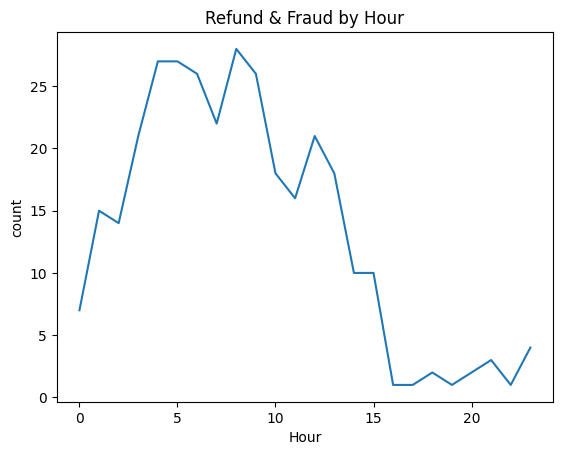

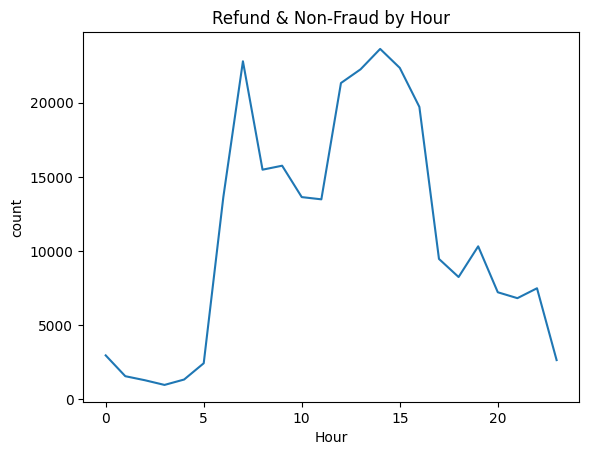

In [49]:
hour_rf = df_rf.groupby("tx_hour")["fraud"].count()
hour_rn = df_rn.groupby("tx_hour")["fraud"].count()

plt.figure()
hour_rf.plot()
plt.title("Refund & Fraud by Hour")
plt.xlabel("Hour")
plt.ylabel("count")
plt.show()

plt.figure()
hour_rn.plot()
plt.title("Refund & Non-Fraud by Hour")
plt.xlabel("Hour")
plt.ylabel("count")
plt.show()


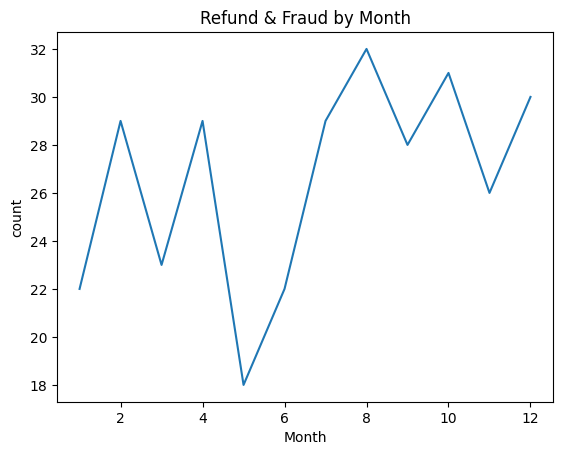

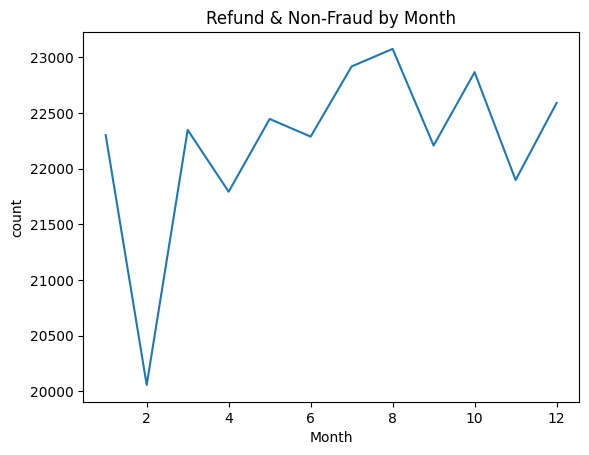

In [50]:
month_rf = df_rf.groupby("tx_month")["fraud"].count()
month_rn = df_rn.groupby("tx_month")["fraud"].count()

plt.figure()
month_rf.plot()
plt.title("Refund & Fraud by Month")
plt.xlabel("Month")
plt.ylabel("count")
plt.show()

plt.figure()
month_rn.plot()
plt.title("Refund & Non-Fraud by Month")
plt.xlabel("Month")
plt.ylabel("count")
plt.show()


In [51]:
df["refund_fraud"] = (
    (df["is_refund"] == 1) &
    (df["fraud"] == 1)
).astype(int)

refund_merchant -> new column

In [52]:
df = df.sort_values(["date", "merchant_id"]).copy()  # tie-break 안정화

g = df.groupby("merchant_id", sort=False)

# 0) 이전 거래 수 (첫 거래는 0)
df["merchant_prev_tx_cnt"] = g.cumcount().astype("int32")

# 1) 이전 fraud 누적 (그룹 안에서 shift!)
df["merchant_prev_fraud_cnt"] = (
    g["fraud"].cumsum()
    .groupby(df["merchant_id"]).shift(1)   # <- 그룹별 shift 보장
    .fillna(0)
    .astype("int32")
)

# 2) 이전 refund 누적
df["merchant_prev_refund_cnt"] = (
    g["is_refund"].cumsum()
    .groupby(df["merchant_id"]).shift(1)
    .fillna(0)
    .astype("int32")
)

# 3) refund 비율 (분모는 이전 거래 수)
df["merchant_refund_ratio"] = (
    df["merchant_prev_refund_cnt"] /
    (df["merchant_prev_tx_cnt"] + 1e-6)
).astype("float32")

# 4) refund&fraud 이벤트 + 이전 누적
df["refund_and_fraud"] = ((df["is_refund"] == 1) & (df["fraud"] == 1)).astype("int8")

df["merchant_prev_refund_fraud_cnt"] = (
    g["refund_and_fraud"].cumsum()
    .groupby(df["merchant_id"]).shift(1)
    .fillna(0)
    .astype("int32")
)

# 5) refund 중 fraud 비율
df["merchant_refund_fraud_rate"] = (
    df["merchant_prev_refund_fraud_cnt"] /
    (df["merchant_prev_refund_cnt"] + 1e-6)
).astype("float32")


In [53]:
print(
    (df.groupby("merchant_id")["merchant_prev_fraud_cnt"].head(1) != 0).sum()
)

print(
    (df.groupby("merchant_id")["merchant_refund_ratio"].head(1) != 0).sum()
)

print(
    (df.groupby("merchant_id")["merchant_refund_fraud_rate"].head(1) != 0).sum()
)

0
0
0


In [54]:
new_cols = [
    "merchant_prev_fraud_cnt",
    "merchant_prev_refund_cnt",
    "merchant_refund_ratio",
    "merchant_prev_refund_fraud_cnt",
    "merchant_refund_fraud_rate"
]

for col in new_cols:
    print(f"\n===== {col} =====")
    print(evaluate_numeric_feature(df, col))



===== merchant_prev_fraud_cnt =====
KS_p          0.000000e+00
MW_p          0.000000e+00
Cohen_d       7.090484e-01
Odds_Ratio    1.004846e+00
Logit_p       0.000000e+00
PR_AUC        4.687934e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64

===== merchant_prev_refund_cnt =====
KS_p          1.870412e-193
MW_p          4.881199e-222
Cohen_d       -3.357483e-01
Odds_Ratio     9.996948e-01
Logit_p        3.954243e-63
PR_AUC         1.800522e-03
n              5.332948e+06
pos_rate       1.448167e-03
dtype: float64

===== merchant_refund_ratio =====
KS_p          1.870412e-193
MW_p          1.230614e-137
Cohen_d       -1.083827e-01
Odds_Ratio     3.081012e-01
Logit_p        2.448884e-21
PR_AUC         2.212469e-03
n              5.332948e+06
pos_rate       1.448167e-03
dtype: float64

===== merchant_prev_refund_fraud_cnt =====
KS_p          7.099006e-62
MW_p          0.000000e+00
Cohen_d       5.435519e-01
Odds_Ratio    1.126988e+00
Logit_p       0.000000e+00
PR

In [55]:
df.groupby("merchant_id")["fraud"].mean().describe()

count    53667.000000
mean         0.005710
std          0.070765
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: fraud, dtype: float64

이 데이터는:\
Behavioral fraud보단\
Merchant-structural fraud\
성격이 강하다.

merchant ID 기반으로 거의 기억하고 있는 상태 우려

[test용 성능 측정]

In [56]:
LABEL = "fraud"
DROP_ALWAYS = ["date", "client_id", "card_id", "merchant_id", LABEL]

df = df.sort_values("date").copy()

split_idx = int(len(df) * 0.7)
train_df = df.iloc[:split_idx].copy()
test_df  = df.iloc[split_idx:].copy()

# 숫자 컬럼만 선택
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# drop
feature_cols = [c for c in num_cols if c not in DROP_ALWAYS]

X_train = train_df[feature_cols]
y_train = train_df[LABEL].astype(int)

X_test  = test_df[feature_cols]
y_test  = test_df[LABEL].astype(int)


In [57]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score, roc_auc_score

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000))
])

pipe.fit(X_train, y_train)

train_proba = pipe.predict_proba(X_train)[:, 1]
test_proba  = pipe.predict_proba(X_test)[:, 1]

print("TRAIN PR-AUC:", average_precision_score(y_train, train_proba))
print("TEST  PR-AUC:", average_precision_score(y_test, test_proba))
print("TRAIN ROC-AUC:", roc_auc_score(y_train, train_proba))
print("TEST  ROC-AUC:", roc_auc_score(y_test, test_proba))
print("n_features:", len(feature_cols))


TRAIN PR-AUC: 0.09635294919799652
TEST  PR-AUC: 0.06805210141572068
TRAIN ROC-AUC: 0.8770819094367521
TEST  ROC-AUC: 0.8719084959271456
n_features: 73


In [58]:
import numpy as np
from sklearn.metrics import precision_recall_curve

def pick_threshold_by_recall(y_true, y_score, target_recall=0.70):
    prec, rec, thr = precision_recall_curve(y_true, y_score)

    prec_t = prec[:-1]
    rec_t  = rec[:-1]
    thr_t  = thr

    mask = rec_t >= target_recall
    if mask.any():
        best_local = np.argmax(prec_t[mask])
        best_thr = thr_t[mask][best_local]
        best_prec = prec_t[mask][best_local]
        best_rec  = rec_t[mask][best_local]
    else:
        # fallback: best F1
        f1 = 2 * (prec_t * rec_t) / (prec_t + rec_t + 1e-12)
        best_idx = np.argmax(f1)
        best_thr = thr_t[best_idx]
        best_prec = prec_t[best_idx]
        best_rec  = rec_t[best_idx]

    return float(best_thr), float(best_prec), float(best_rec)


In [59]:
from sklearn.metrics import classification_report, confusion_matrix

thr, prec, rec = pick_threshold_by_recall(y_test, test_proba, target_recall=0.70)

y_pred = (test_proba >= thr).astype(int)

print("Threshold:", thr)
print("Precision @ Recall>=0.7:", prec)
print("Recall:", rec)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

alert_rate = y_pred.mean()
print("\nAlert Rate:", alert_rate)


Threshold: 0.0012267395486148748
Precision @ Recall>=0.7: 0.0062700150316972745
Recall: 0.7012334399269072

Confusion Matrix:
[[1354415  243281]
 [    654    1535]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9995    0.8477    0.9174   1597696
           1     0.0063    0.7012    0.0124      2189

    accuracy                         0.8475   1599885
   macro avg     0.5029    0.7745    0.4649   1599885
weighted avg     0.9982    0.8475    0.9161   1599885


Alert Rate: 0.15302099838425887


In [60]:
merchant_cols = [c for c in X_train.columns if "merchant" in c]

X_train_nm = X_train.drop(columns=merchant_cols)
X_test_nm  = X_test.drop(columns=merchant_cols)

pipe_nm = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000))
])

pipe_nm.fit(X_train_nm, y_train)

test_proba_nm = pipe_nm.predict_proba(X_test_nm)[:, 1]

print("NO MERCHANT TEST PR-AUC:",
      average_precision_score(y_test, test_proba_nm))


NO MERCHANT TEST PR-AUC: 0.05618772716274399


In [61]:
global_fraud_rate = df["fraud"].mean()

print("Global fraud rate:", global_fraud_rate)

Global fraud rate: 0.001448167130075148


베이지안 추정

In [62]:
alpha = 50  # prior strength

df["merchant_prev_fraud_rate_smooth"] = (
    (df["merchant_prev_fraud_cnt"] + alpha * global_fraud_rate) /
    (df["merchant_prev_tx_cnt"] + alpha)
).astype("float32")

In [63]:
first_rows = df.groupby("merchant_id").head(1)
print((first_rows["merchant_prev_fraud_rate_smooth"] != global_fraud_rate).sum())


53667


In [64]:
for a in [10, 30, 50, 100]:
    tmp = (df["merchant_prev_fraud_cnt"] + a * global_fraud_rate) / \
          (df["merchant_prev_tx_cnt"] + a)
    print(a, tmp.describe())


10 count    5.332948e+06
mean     1.627849e-03
std      8.185721e-03
min      5.884634e-08
25%      1.215211e-06
50%      4.701841e-05
75%      7.244560e-04
max      8.463766e-01
dtype: float64
30 count    5.332948e+06
mean     1.614619e-03
std      6.440437e-03
min      1.765247e-07
25%      3.639525e-06
50%      1.210168e-04
75%      9.725963e-04
max      6.475699e-01
dtype: float64
50 count    5.332948e+06
mean     1.605478e-03
std      5.708036e-03
min      2.941839e-07
25%      5.585772e-06
50%      1.783457e-04
75%      1.064829e-03
max      5.244991e-01
dtype: float64
100 count    5.332948e+06
mean     1.586609e-03
std      4.848101e-03
min      5.882482e-07
25%      9.231499e-06
50%      3.004496e-04
75%      1.182801e-03
max      3.557730e-01
dtype: float64


In [65]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    average_precision_score,
    roc_auc_score,
    precision_recall_curve,
    confusion_matrix,
)

LABEL = "fraud"
BASE_DROP = ["date", "client_id", "card_id", "merchant_id", LABEL]

def build_Xy(df_: pd.DataFrame):
    X = df_.drop(columns=[c for c in BASE_DROP if c in df_.columns]).copy()
    y = df_[LABEL].astype(int).copy()
    return X, y

def get_num_cols(X: pd.DataFrame):
    return [c for c in X.columns if str(X[c].dtype).startswith(("float", "int"))]

def pick_threshold_by_recall(y_true, y_score, target_recall=0.70):
    prec, rec, thr = precision_recall_curve(y_true, y_score)
    prec_t = prec[:-1]
    rec_t  = rec[:-1]
    thr_t  = thr
    mask = rec_t >= target_recall
    if mask.any():
        i = np.argmax(prec_t[mask])
        thr_best = thr_t[mask][i]
        return float(thr_best), float(prec_t[mask][i]), float(rec_t[mask][i]), "prec_max_under_recall"
    # fallback
    f1 = 2 * prec_t * rec_t / (prec_t + rec_t + 1e-12)
    j = np.argmax(f1)
    return float(thr_t[j]), float(prec_t[j]), float(rec_t[j]), "fallback_best_f1"

def fit_eval_time_split(df_train, df_valid, tag, drop_cols_extra=None, target_recall=0.70):
    X_tr, y_tr = build_Xy(df_train)
    X_va, y_va = build_Xy(df_valid)

    if drop_cols_extra:
        X_tr = X_tr.drop(columns=[c for c in drop_cols_extra if c in X_tr.columns])
        X_va = X_va.drop(columns=[c for c in drop_cols_extra if c in X_va.columns])

    num_cols = get_num_cols(X_tr)

    preprocess = ColumnTransformer(
        transformers=[("num", StandardScaler(), num_cols)],
        remainder="drop"
    )

    pipe = Pipeline([
        ("prep", preprocess),
        ("clf", LogisticRegression(max_iter=2000, solver="lbfgs"))
    ])

    pipe.fit(X_tr, y_tr)

    tr_proba = pipe.predict_proba(X_tr)[:, 1]
    va_proba = pipe.predict_proba(X_va)[:, 1]

    tr_prauc = average_precision_score(y_tr, tr_proba)
    va_prauc = average_precision_score(y_va, va_proba)

    tr_roc = roc_auc_score(y_tr, tr_proba)
    va_roc = roc_auc_score(y_va, va_proba)

    thr, prec, rec, note = pick_threshold_by_recall(y_va, va_proba, target_recall=target_recall)
    yhat = (va_proba >= thr).astype(int)

    cm = confusion_matrix(y_va, yhat)
    tn, fp, fn, tp = cm.ravel()
    alert_rate = (tp + fp) / len(y_va)

    return {
        "tag": tag,
        "n_train": int(len(df_train)),
        "n_valid": int(len(df_valid)),
        "pos_rate_train": float(y_tr.mean()),
        "pos_rate_valid": float(y_va.mean()),
        "PR_AUC_train": float(tr_prauc),
        "PR_AUC_valid": float(va_prauc),
        "ROC_AUC_train": float(tr_roc),
        "ROC_AUC_valid": float(va_roc),
        "precision@recall>=0.7": float(prec),
        "recall": float(rec),
        "threshold": float(thr),
        "alert_rate": float(alert_rate),
        "TP": int(tp), "FP": int(fp), "FN": int(fn), "TN": int(tn),
        "note": note,
    }


df = df.sort_values("date").copy()

cut = int(len(df) * 0.8)
df_train = df.iloc[:cut].copy()
df_valid = df.iloc[cut:].copy()


merchant_raw_cols = [
    "merchant_prev_fraud_cnt",
    "merchant_prev_refund_cnt",
    "merchant_refund_ratio",
    "merchant_prev_refund_fraud_cnt",
    "merchant_refund_fraud_rate",
]

drop_for_smooth_only = [c for c in merchant_raw_cols if c in df.columns]
drop_for_no_merchant = [c for c in df.columns if c.startswith("merchant_")]


results = []
results.append(fit_eval_time_split(df_train, df_valid, "A_raw_all", drop_cols_extra=None))
results.append(fit_eval_time_split(df_train, df_valid, "B_drop_raw(keep_smooth_if_any)", drop_cols_extra=drop_for_smooth_only))
results.append(fit_eval_time_split(df_train, df_valid, "C_no_merchant", drop_cols_extra=drop_for_no_merchant))

res_df = pd.DataFrame(results).sort_values("PR_AUC_valid", ascending=False)
print(res_df.to_string(index=False))


                           tag  n_train  n_valid  pos_rate_train  pos_rate_valid  PR_AUC_train  PR_AUC_valid  ROC_AUC_train  ROC_AUC_valid  precision@recall>=0.7   recall  threshold  alert_rate   TP     FP  FN     TN                  note
B_drop_raw(keep_smooth_if_any)  4266358  1066590        0.001297        0.002052      0.158177      0.111135       0.888538       0.827853               0.006983 0.700320   0.000639    0.205837 1533 218011 656 846390 prec_max_under_recall
                     A_raw_all  4266358  1066590        0.001297        0.002052      0.152572      0.108054       0.907728       0.872758               0.009720 0.700777   0.000838    0.147973 1534 156293 655 908108 prec_max_under_recall
                 C_no_merchant  4266358  1066590        0.001297        0.002052      0.085732      0.065407       0.850946       0.808419               0.006147 0.700320   0.000551    0.233808 1533 247844 656 816557 prec_max_under_recall


Raw merchant 카운트보다, 스무딩된 rate만 쓰는 게 더 잘 일반화되고 있다.

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5332948 entries, 0 to 5332978
Data columns (total 81 columns):
 #   Column                           Dtype         
---  ------                           -----         
 0   date                             datetime64[ns]
 1   client_id                        int64         
 2   card_id                          int64         
 3   amount                           float32       
 4   merchant_id                      int64         
 5   mcc                              object        
 6   fraud                            int8          
 7   has_error                        int8          
 8   err_bad_card_number              int8          
 9   err_bad_expiration               int8          
 10  err_bad_cvv                      int8          
 11  err_bad_pin                      int8          
 12  err_bad_zipcode                  int8          
 13  err_insufficient_balance         int8          
 14  err_technical_glitch             int8  

In [67]:
drop_cols = [
    "merchant_tx_cnt",
    "merchant_prev_refund_cnt",
    "merchant_refund_ratio",
    "refund_and_fraud",
    "merchant_prev_refund_fraud_cnt",
    "merchant_refund_fraud_rate",
    "merchant_prev_tx_cnt",
]

df = df.drop(columns=[c for c in drop_cols if c in df.columns]).copy()


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5332948 entries, 0 to 5332978
Data columns (total 75 columns):
 #   Column                           Dtype         
---  ------                           -----         
 0   date                             datetime64[ns]
 1   client_id                        int64         
 2   card_id                          int64         
 3   amount                           float32       
 4   merchant_id                      int64         
 5   mcc                              object        
 6   fraud                            int8          
 7   has_error                        int8          
 8   err_bad_card_number              int8          
 9   err_bad_expiration               int8          
 10  err_bad_cvv                      int8          
 11  err_bad_pin                      int8          
 12  err_bad_zipcode                  int8          
 13  err_insufficient_balance         int8          
 14  err_technical_glitch             int8  

In [69]:
LABEL = "fraud"

df = df.sort_values("date").copy()

split_idx = int(len(df) * 0.8)
train_df = df.iloc[:split_idx].copy()
valid_df = df.iloc[split_idx:].copy()

BASE_DROP = ["date", "client_id", "card_id", "merchant_id", LABEL]

def build_Xy_numeric(data: pd.DataFrame):
    X = data.drop(columns=[c for c in BASE_DROP if c in data.columns]).copy()
    y = data[LABEL].astype(int).copy()

    X = X.select_dtypes(include=[np.number]).copy()
    return X, y

X_train, y_train = build_Xy_numeric(train_df)
X_valid, y_valid = build_Xy_numeric(valid_df)

print("X_train shape:", X_train.shape)
print("dtypes check:\n", X_train.dtypes.value_counts())

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000))
])

pipe.fit(X_train, y_train)

train_proba = pipe.predict_proba(X_train)[:, 1]
valid_proba = pipe.predict_proba(X_valid)[:, 1]

print("PR-AUC train:", average_precision_score(y_train, train_proba))
print("PR-AUC valid:", average_precision_score(y_valid, valid_proba))
print("ROC-AUC valid:", roc_auc_score(y_valid, valid_proba))

def pick_threshold(y_true, y_score, target_recall=0.7):
    prec, rec, thr = precision_recall_curve(y_true, y_score)
    prec, rec = prec[:-1], rec[:-1]

    mask = rec >= target_recall
    if mask.any():
        best = np.argmax(prec[mask])
        thr_best = thr[mask][best]
        return float(thr_best), float(prec[mask][best]), float(rec[mask][best]), "prec_max_under_recall"
    else:
        f1 = 2 * (prec * rec) / (prec + rec + 1e-12)
        best = np.argmax(f1)
        thr_best = thr[best]
        return float(thr_best), float(prec[best]), float(rec[best]), "fallback_best_f1"

thr, prec, rec, note = pick_threshold(y_valid, valid_proba, target_recall=0.7)

y_pred = (valid_proba >= thr).astype(int)

print("\nThreshold:", thr, "|", note)
print("Precision @ Recall>=0.7:", prec)
print("Recall:", rec)

cm = confusion_matrix(y_valid, y_pred)
print("\nConfusion Matrix:\n", cm)

print("\nClassification Report:\n", classification_report(y_valid, y_pred))

alert_rate = y_pred.mean()
print("\nAlert Rate:", alert_rate)


X_train shape: (4266358, 68)
dtypes check:
 int8       36
float32    18
int16       5
int64       5
int32       2
Int16       1
float64     1
Name: count, dtype: int64
PR-AUC train: 0.1526506619792261
PR-AUC valid: 0.10394468443674813
ROC-AUC valid: 0.8544497038545871

Threshold: 0.0007034533743431345 | prec_max_under_recall
Precision @ Recall>=0.7: 0.00876756515622051
Recall: 0.7003197807217908

Confusion Matrix:
 [[891085 173316]
 [   656   1533]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.84      0.91   1064401
           1       0.01      0.70      0.02      2189

    accuracy                           0.84   1066590
   macro avg       0.50      0.77      0.46   1066590
weighted avg       1.00      0.84      0.91   1066590


Alert Rate: 0.1639327201642618


처음 보는 가맹점에서도 잘 작동하는가?

In [70]:
unique_merchants = df["merchant_id"].unique()
np.random.seed(42)
np.random.shuffle(unique_merchants)

split_point = int(len(unique_merchants) * 0.8)

train_merchants = unique_merchants[:split_point]
valid_merchants = unique_merchants[split_point:]

train_df = df[df["merchant_id"].isin(train_merchants)]
valid_df = df[df["merchant_id"].isin(valid_merchants)]


In [71]:
X_train, y_train = build_Xy_numeric(train_df)
X_valid, y_valid = build_Xy_numeric(valid_df)

print("X_train shape:", X_train.shape)
print("dtypes check:\n", X_train.dtypes.value_counts())

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000))
])

pipe.fit(X_train, y_train)

train_proba = pipe.predict_proba(X_train)[:, 1]
valid_proba = pipe.predict_proba(X_valid)[:, 1]

print("PR-AUC train:", average_precision_score(y_train, train_proba))
print("PR-AUC valid:", average_precision_score(y_valid, valid_proba))
print("ROC-AUC valid:", roc_auc_score(y_valid, valid_proba))

X_train shape: (4702339, 68)
dtypes check:
 int8       36
float32    18
int16       5
int64       5
int32       2
Int16       1
float64     1
Name: count, dtype: int64
PR-AUC train: 0.1345346268586233
PR-AUC valid: 0.16735849617971624
ROC-AUC valid: 0.9068408371705273


In [72]:
thr, prec, rec, note = pick_threshold(y_valid, valid_proba, target_recall=0.7)

y_pred = (valid_proba >= thr).astype(int)

print("\nThreshold:", thr, "|", note)
print("Precision @ Recall>=0.7:", prec)
print("Recall:", rec)

cm = confusion_matrix(y_valid, y_pred)
print("\nConfusion Matrix:\n", cm)

print("\nClassification Report:\n", classification_report(y_valid, y_pred))

alert_rate = y_pred.mean()
print("\nAlert Rate:", alert_rate)


Threshold: 0.0031862857690661862 | prec_max_under_recall
Precision @ Recall>=0.7: 0.02402643379749823
Recall: 0.7006194081211287

Confusion Matrix:
 [[587804  41352]
 [   435   1018]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.93      0.97    629156
           1       0.02      0.70      0.05      1453

    accuracy                           0.93    630609
   macro avg       0.51      0.82      0.51    630609
weighted avg       1.00      0.93      0.96    630609


Alert Rate: 0.06718901886906149


---

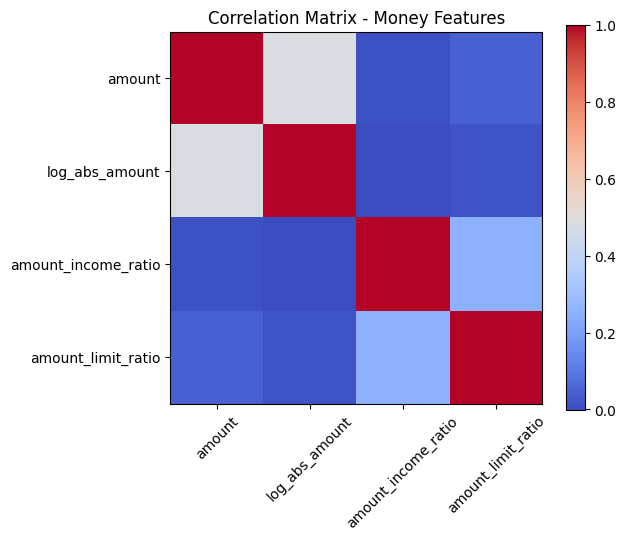

                       amount  log_abs_amount  amount_income_ratio  \
amount               1.000000        0.484010             0.010375   
log_abs_amount       0.484010        1.000000            -0.002137   
amount_income_ratio  0.010375       -0.002137             1.000000   
amount_limit_ratio   0.044910        0.016988             0.253600   

                     amount_limit_ratio  
amount                         0.044910  
log_abs_amount                 0.016988  
amount_income_ratio            0.253600  
amount_limit_ratio             1.000000  


In [73]:
corr = df[money_cols].corr()

plt.figure(figsize=(6,5))
plt.imshow(corr, cmap="coolwarm")
plt.colorbar()
plt.xticks(range(len(money_cols)), money_cols, rotation=45)
plt.yticks(range(len(money_cols)), money_cols)
plt.title("Correlation Matrix - Money Features")
plt.show()

print(corr)

In [74]:
df["amount_limit_ratio"].describe()

count    5.332948e+06
mean     1.030902e+05
std      4.629322e+06
min     -4.950000e+08
25%      6.748256e-04
50%      2.441880e-03
75%      6.662791e-03
max      1.863290e+09
Name: amount_limit_ratio, dtype: float64

In [75]:
upper = df["amount_limit_ratio"].quantile(0.995)
lower = df["amount_limit_ratio"].quantile(0.005)

df_clip = df[
    (df["amount_limit_ratio"] < upper) &
    (df["amount_limit_ratio"] > lower)
]


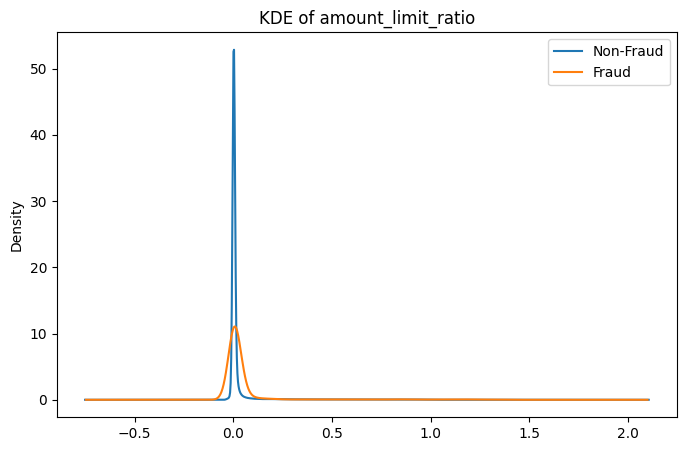

In [76]:
df_nf = df_clip[df_clip["fraud"] == 0]
df_f  = df_clip[df_clip["fraud"] == 1]

plt.figure(figsize=(8,5))
df_nf["amount_limit_ratio"].plot.kde(label="Non-Fraud")
df_f["amount_limit_ratio"].plot.kde(label="Fraud")

plt.legend()
plt.title("KDE of amount_limit_ratio")
plt.show()


---

## 3) 고객 인구통계/신용 프로필 (customer risk profile)

* `current_age`
* `male`
* `yearly_income`, `log_yearly_income`
* `per_capita_income`
* `income_ratio_region`, `log_income_ratio_region`
* `total_debt`
* `credit_score`

**분석 포인트**

* fraud가 특정 구간(저신용/고부채/저소득)에서 증가하는지
* income 원천 변수와 파생 변수(로그/비율) 중복/효용 비교
* demographic 변수는 **편향/해석 이슈**가 생길 수 있으니 영향이 크면 사용 목적을 명확히(성능 vs 정책)

---

In [77]:
money_cols = [
    "amount",
    "log_abs_amount",
    "amount_income_ratio",
    "amount_limit_ratio"
]

for col in money_cols:
    print(f"\n===== {col} =====")
    print(df[col].describe())
    print("Top 5 values:")
    print(df[col].sort_values(ascending=False).head())



===== amount =====
count    5.332948e+06
mean     4.309145e+01
std      8.176396e+01
min     -5.000000e+02
25%      8.950000e+00
50%      2.910000e+01
75%      6.400000e+01
max      5.696780e+03
Name: amount, dtype: float64
Top 5 values:
4230064    5696.779785
186889     4978.450195
1214091    4685.229980
4906770    4633.430176
782354     4266.209961
Name: amount, dtype: float32

===== log_abs_amount =====
count    5.332948e+06
mean     3.356879e+00
std      1.237465e+00
min      0.000000e+00
25%      2.548664e+00
50%      3.583797e+00
75%      4.276944e+00
max      8.647832e+00
Name: log_abs_amount, dtype: float64
Top 5 values:
4230064    8.647832
186889     8.513075
1214091    8.452384
4906770    8.441269
782354     8.358715
Name: log_abs_amount, dtype: float32

===== amount_income_ratio =====
count    5.332948e+06
mean     1.165125e-02
std      6.470686e-01
min     -2.349999e+02
25%      2.059873e-04
50%      6.794007e-04
75%      1.543527e-03
max      6.210965e+02
Name: amount_inc

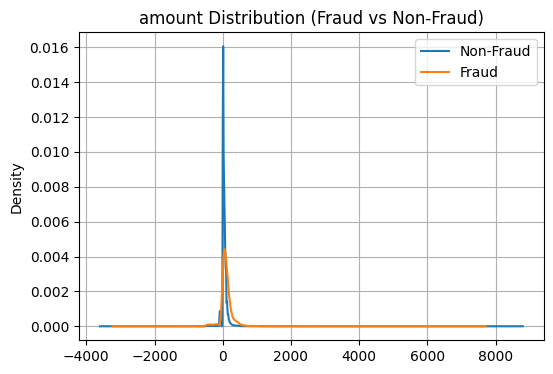

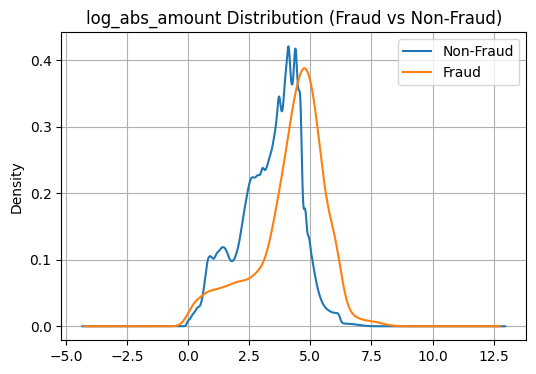

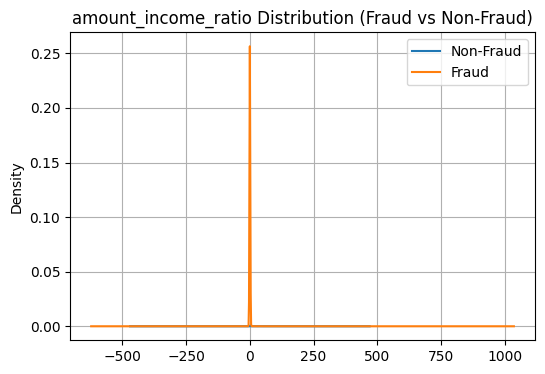

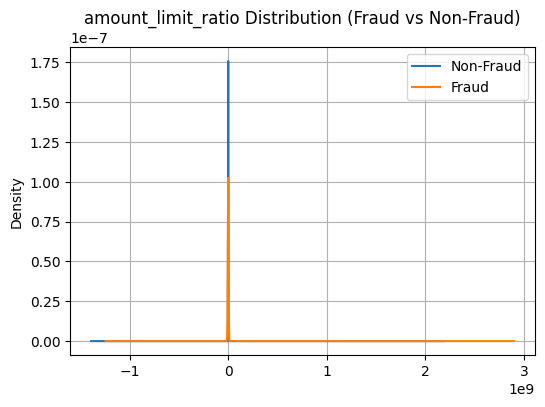

In [78]:
for col in money_cols:
    plt.figure(figsize=(6,4))
    
    df[df["fraud"] == 0][col].plot(kind="kde", label="Non-Fraud")
    df[df["fraud"] == 1][col].plot(kind="kde", label="Fraud")
    
    plt.title(f"{col} Distribution (Fraud vs Non-Fraud)")
    plt.legend()
    plt.grid(True)
    plt.show()


amount가 유의미한 차이

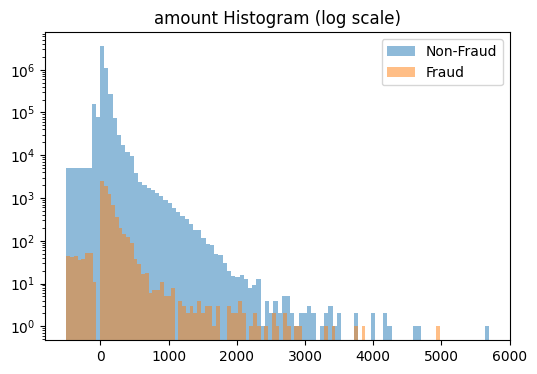

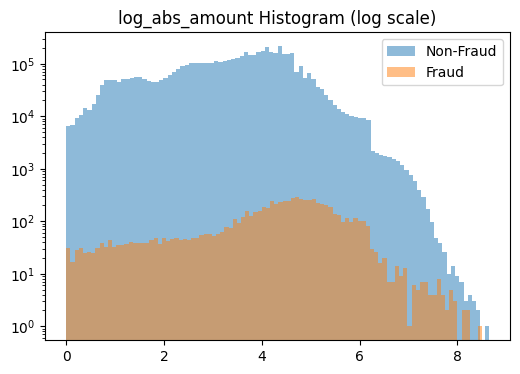

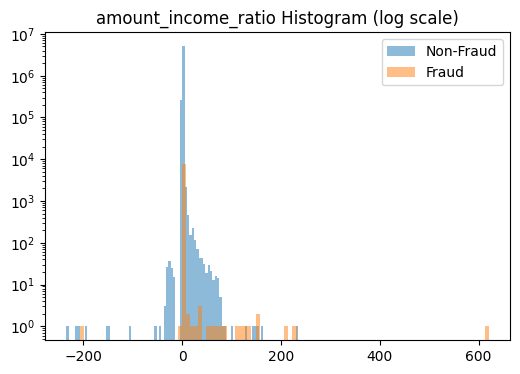

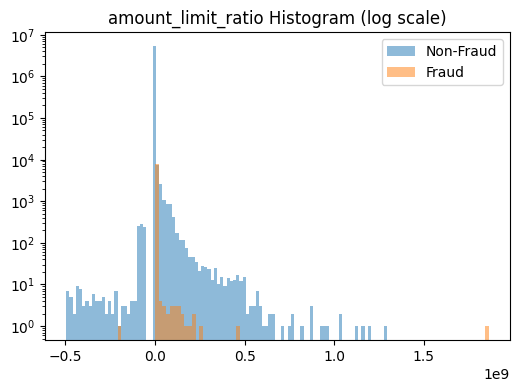

In [79]:
for col in money_cols:
    plt.figure(figsize=(6,4))
    
    plt.hist(df[df["fraud"]==0][col], bins=100, alpha=0.5, label="Non-Fraud")
    plt.hist(df[df["fraud"]==1][col], bins=100, alpha=0.5, label="Fraud")
    
    plt.yscale("log")
    plt.title(f"{col} Histogram (log scale)")
    plt.legend()
    plt.show()


In [80]:
for col in money_cols:
    print(f"\n===== Statistical Test: {col} =====")
    print(evaluate_numeric_feature(df, col))



===== Statistical Test: amount =====
KS_p          0.000000e+00
MW_p          0.000000e+00
Cohen_d       8.900128e-01
Odds_Ratio    1.002701e+00
Logit_p       0.000000e+00
PR_AUC        6.129450e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64

===== Statistical Test: log_abs_amount =====
KS_p          0.000000e+00
MW_p          0.000000e+00
Cohen_d       6.788001e-01
Odds_Ratio    1.938924e+00
Logit_p       0.000000e+00
PR_AUC        6.433742e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64

===== Statistical Test: amount_income_ratio =====
KS_p          0.000000e+00
MW_p          0.000000e+00
Cohen_d       4.310085e-01
Odds_Ratio    1.044427e+00
Logit_p       6.924820e-31
PR_AUC        6.045118e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64

===== Statistical Test: amount_limit_ratio =====
KS_p          0.000000e+00
MW_p          0.000000e+00
Cohen_d       1.171678e-01
Odds_Ratio    1.000000e+00
Logit_p       

---

In [81]:
df.groupby(pd.qcut(df["amount_limit_ratio"], 10))["fraud"].mean()

/tmp/ipykernel_2626364/1337225554.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(pd.qcut(df["amount_limit_ratio"], 10))["fraud"].mean()


amount_limit_ratio
(-495000000.001, 0.000127]    0.001217
(0.000127, 0.000448]          0.000726
(0.000448, 0.000925]          0.000566
(0.000925, 0.00155]           0.000568
(0.00155, 0.00244]            0.000808
(0.00244, 0.00363]            0.001080
(0.00363, 0.00537]            0.001303
(0.00537, 0.00866]            0.001824
(0.00866, 0.0238]             0.003028
(0.0238, 1863289984.0]        0.003360
Name: fraud, dtype: float64

아주 낮은 ratio 구간 → fraud 높음 (1.6%)

상위 구간 → fraud 다시 높아짐 (2.1%)

In [82]:
df["low_ratio_flag"] = df["amount_limit_ratio"].quantile(0.05)
df["high_ratio_flag"] = df["amount_limit_ratio"].quantile(0.95)

In [83]:
evaluate_numeric_feature(df, "low_ratio_flag")

/tmp/ipykernel_2626364/3873468701.py:32: RuntimeWarning: overflow encountered in exp
  odds_ratio = float(np.exp(model.params[feature]))


KS_p          1.000000e+00
MW_p          1.000000e+00
Cohen_d                NaN
Odds_Ratio             NaN
Logit_p       0.000000e+00
PR_AUC        1.448167e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64

In [84]:
evaluate_numeric_feature(df, "high_ratio_flag")

KS_p          1.000000e+00
MW_p          1.000000e+00
Cohen_d      -1.000725e+00
Odds_Ratio    1.107776e-17
Logit_p       0.000000e+00
PR_AUC        1.448167e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64

limit에 비해 지출이 극단적으로 크거나 작을 때 fraud일 확률이 높다

---

In [85]:
df.groupby(pd.qcut(df["amount_income_ratio"], 10))["fraud"].mean()

/tmp/ipykernel_2626364/89038327.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(pd.qcut(df["amount_income_ratio"], 10))["fraud"].mean()


amount_income_ratio
(-235.001, 4.26e-05]    0.001283
(4.26e-05, 0.000136]    0.000713
(0.000136, 0.000275]    0.000639
(0.000275, 0.000439]    0.000542
(0.000439, 0.000679]    0.000673
(0.000679, 0.000982]    0.000891
(0.000982, 0.00133]     0.000975
(0.00133, 0.00181]      0.001331
(0.00181, 0.0027]       0.001828
(0.0027, 621.096]       0.005607
Name: fraud, dtype: float64

In [86]:
q05 = df["amount_income_ratio"].quantile(0.05)
q95 = df["amount_income_ratio"].quantile(0.95)

df["low_income_flag"]  = df["amount_income_ratio"] < q05
df["high_income_flag"] = df["amount_income_ratio"] > q95

In [87]:
print("low_income_flag")
evaluate_numeric_feature(df, "low_income_flag")

low_income_flag


KS_p          6.002452e-01
MW_p          4.543579e-04
Cohen_d      -3.992758e-02
Odds_Ratio    8.184959e-01
Logit_p       4.644469e-04
PR_AUC        1.460865e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64

In [88]:
print("high_income_flag")
evaluate_numeric_feature(df, "high_income_flag")

high_income_flag


KS_p          2.280794e-316
MW_p           0.000000e+00
Cohen_d        9.918371e-01
Odds_Ratio     6.920523e+00
Logit_p        0.000000e+00
PR_AUC         3.108093e-03
n              5.332948e+06
pos_rate       1.448167e-03
dtype: float64

---

In [89]:
evaluate_numeric_feature(df, "total_debt")

KS_p          7.293210e-13
MW_p          1.546809e-14
Cohen_d      -1.051655e-01
Odds_Ratio    9.999978e-01
Logit_p       2.118255e-20
PR_AUC        1.551302e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64

In [90]:
evaluate_numeric_feature(df, "credit_score")

KS_p          5.077947e-04
MW_p          4.046512e-01
Cohen_d      -5.222010e-04
Odds_Ratio    9.999921e-01
Logit_p       9.634233e-01
PR_AUC        1.470216e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64

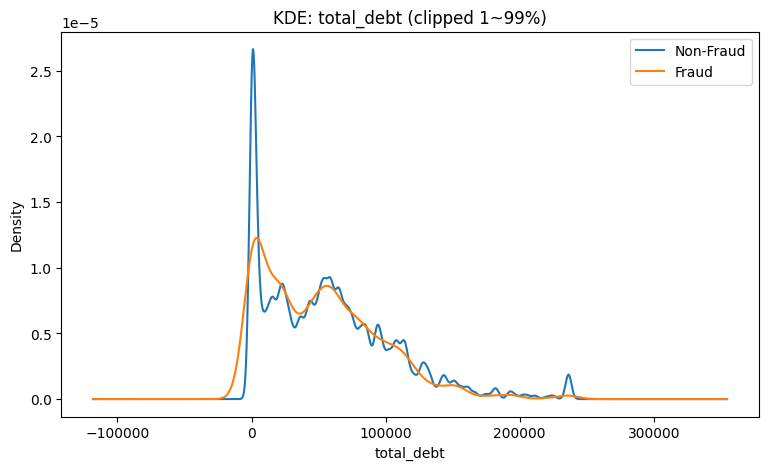

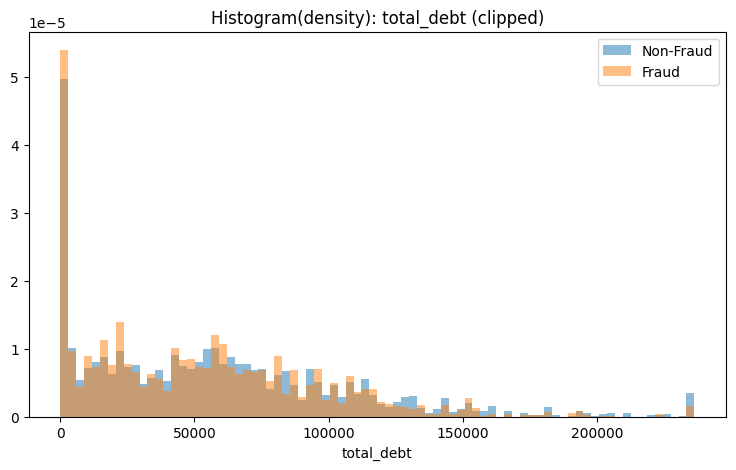

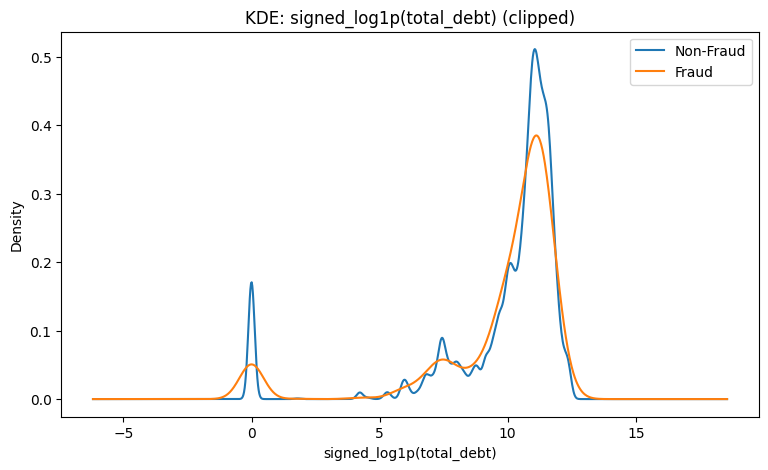

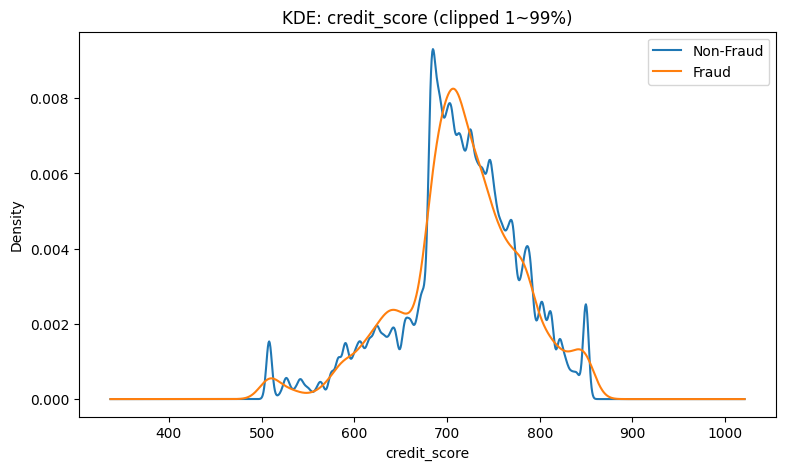

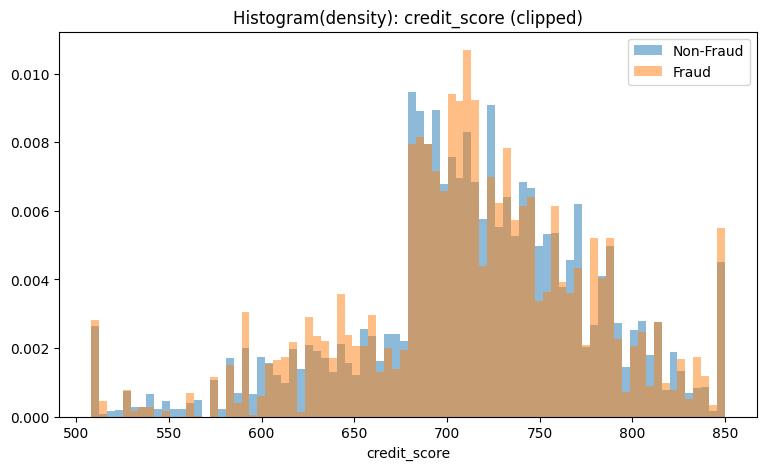

In [91]:
def plot_feature_eda(df, col, label_col="fraud", bins=80, clip_q=(0.01, 0.99), log_abs=False):

    s = df[col].astype("float64").replace([np.inf, -np.inf], np.nan).dropna()
    lo, hi = s.quantile(clip_q[0]), s.quantile(clip_q[1])

    df_nf = df[df[label_col] == 0].copy()
    df_f  = df[df[label_col] == 1].copy()

    # 클립 적용(시각화용)
    def _clip(x):
        x = x.astype("float64").replace([np.inf, -np.inf], np.nan).dropna()
        return x.clip(lo, hi)

    x_nf = _clip(df_nf[col])
    x_f  = _clip(df_f[col])

    # ---- 1) KDE
    plt.figure(figsize=(9,5))
    x_nf.plot.kde(label="Non-Fraud")
    x_f.plot.kde(label="Fraud")
    plt.title(f"KDE: {col} (clipped {clip_q[0]*100:.0f}~{clip_q[1]*100:.0f}%)")
    plt.xlabel(col)
    plt.legend()
    plt.show()

    # ---- 2) Histogram (density)
    plt.figure(figsize=(9,5))
    plt.hist(x_nf, bins=bins, density=True, alpha=0.5, label="Non-Fraud")
    plt.hist(x_f,  bins=bins, density=True, alpha=0.5, label="Fraud")
    plt.title(f"Histogram(density): {col} (clipped)")
    plt.xlabel(col)
    plt.legend()
    plt.show()

    # ---- 3) Optional: signed log transform plots
    if log_abs:
        def slog1p(x):
            x = x.astype("float64").replace([np.inf, -np.inf], np.nan).dropna()
            return np.sign(x) * np.log1p(np.abs(x))

        x_nf2 = slog1p(df_nf[col])
        x_f2  = slog1p(df_f[col])

        s2 = np.concatenate([x_nf2.values, x_f2.values])
        lo2, hi2 = np.quantile(s2, clip_q[0]), np.quantile(s2, clip_q[1])
        x_nf2 = x_nf2.clip(lo2, hi2)
        x_f2  = x_f2.clip(lo2, hi2)

        plt.figure(figsize=(9,5))
        x_nf2.plot.kde(label="Non-Fraud")
        x_f2.plot.kde(label="Fraud")
        plt.title(f"KDE: signed_log1p({col}) (clipped)")
        plt.xlabel(f"signed_log1p({col})")
        plt.legend()
        plt.show()


plot_feature_eda(df, "total_debt", label_col="fraud", clip_q=(0.01, 0.99), log_abs=True)
plot_feature_eda(df, "credit_score", label_col="fraud", clip_q=(0.01, 0.99), log_abs=False)


사기(Fraud)는 보통:

고객의 신용 수준 때문이 아니라

계정 탈취 / 카드 탈취 / 결제 환경 이상

같은 행동 기반 이벤트

---

## 4) 카드/계정 상태(카드 생애주기 + 보안 이벤트)

* `num_cards_issued`
* `num_credit_cards`
* `credit_limit`
* `has_chip`
* `year_pin_last_changed`
* `years_since_pin_change`
* `months_to_expire`

**분석 포인트**

* PIN 변경 직후/오래된 PIN이 위험 신호인지
* 만료 임박(months_to_expire)이 fraud에 연결되는지
* chip 유무, 카드 발급 수가 어떤 의미인지(사기 시나리오 해석)
* “한도/소득/부채” 조합으로 risk profile 강화 가능

---


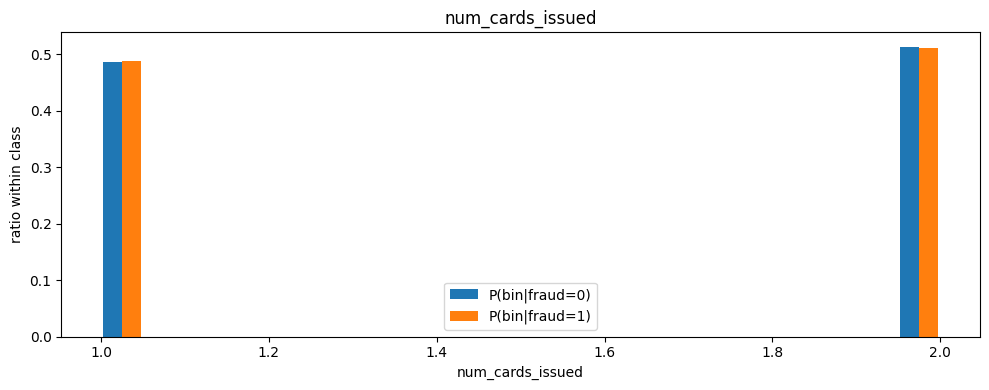

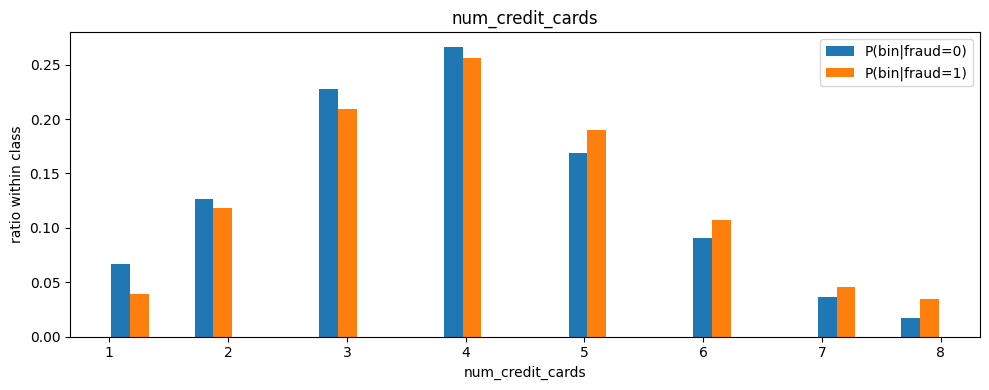

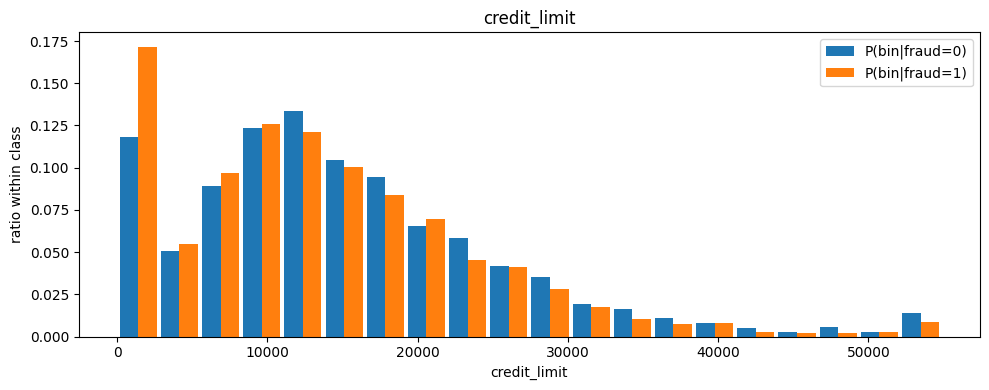

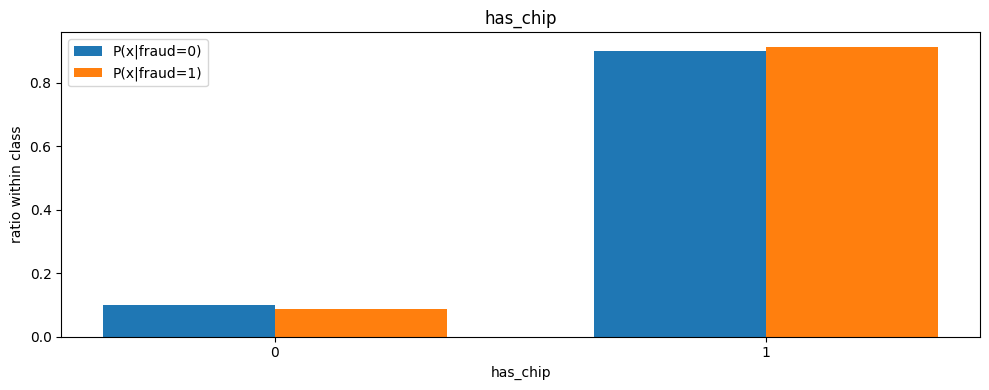

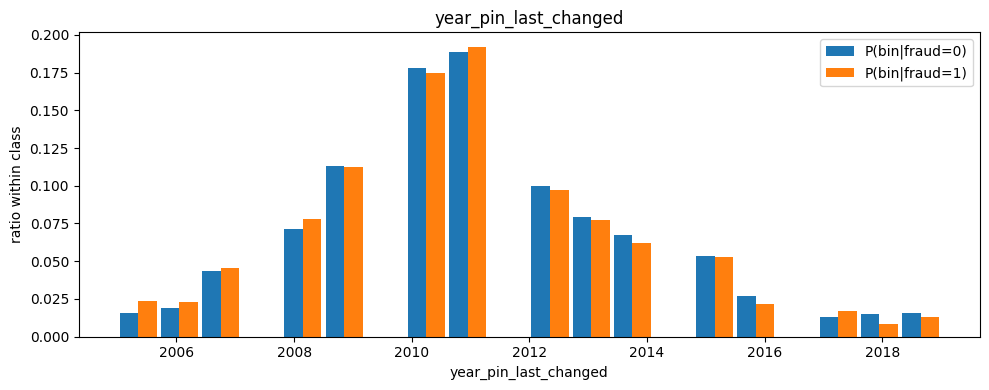

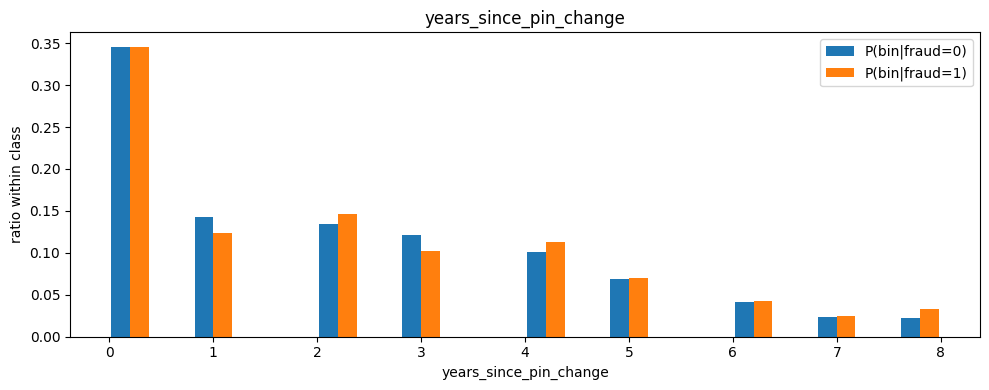

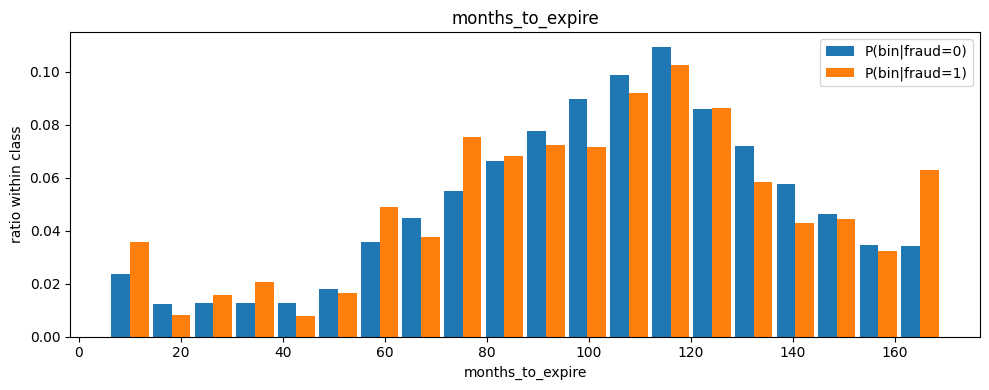

In [92]:
FEATURES = [
    "num_cards_issued",
    "num_credit_cards",
    "credit_limit",
    "has_chip",
    "year_pin_last_changed",
    "years_since_pin_change",
    "months_to_expire",
]
LABEL_COL = "fraud"  # 0/1

def _to_numeric_safe(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s, errors="coerce")

def _is_binary_like(s: pd.Series) -> bool:
    x = s.dropna()
    if x.empty:
        return False
    if x.dtype == bool:
        return True
    xn = pd.to_numeric(x, errors="coerce")
    if xn.notna().all():
        return set(np.unique(xn.values)).issubset({0, 1})
    xu = set(map(lambda v: str(v).strip().lower(), np.unique(x.astype(str).values)))
    known = {"0", "1", "true", "false", "yes", "no", "y", "n", "t", "f"}
    return xu.issubset(known)

def _binary_normalize(s: pd.Series) -> pd.Series:
    if s.dtype == bool:
        return s.astype(float)
    sn = pd.to_numeric(s, errors="coerce")
    if sn.notna().all():
        return sn.astype(float)
    mapper = {
        "1": 1, "0": 0,
        "true": 1, "false": 0,
        "yes": 1, "no": 0,
        "y": 1, "n": 0,
        "t": 1, "f": 0,
    }
    return s.astype(str).str.strip().str.lower().map(mapper).astype(float)

def plot_class_ratio_only(
    df: pd.DataFrame,
    col: str,
    label_col: str = LABEL_COL,
    bins: int = 20,
    clip_q=(0.01, 0.99),
    min_bin_count: int = 30,
):
    if col not in df.columns:
        raise KeyError(f"Missing feature column: {col}")
    if label_col not in df.columns:
        raise KeyError(f"Missing label column: {label_col}")

    s = df[col]
    is_bin = _is_binary_like(s)

    plt.figure(figsize=(10, 4))

    if is_bin:
        tmp = df[[col, label_col]].copy()
        tmp[col] = _binary_normalize(tmp[col])

        g0 = tmp.loc[tmp[label_col] == 0, col]
        g1 = tmp.loc[tmp[label_col] == 1, col]

        cats = [0.0, 1.0]
        x = np.arange(len(cats))
        w = 0.35

        v0 = g0.value_counts(dropna=True).reindex(cats).fillna(0.0).values
        v1 = g1.value_counts(dropna=True).reindex(cats).fillna(0.0).values
        v0 = v0 / max(v0.sum(), 1e-12)
        v1 = v1 / max(v1.sum(), 1e-12)

        plt.bar(x - w / 2, v0, width=w, label="P(x|fraud=0)")
        plt.bar(x + w / 2, v1, width=w, label="P(x|fraud=1)")
        plt.xticks(x, ["0", "1"])
        plt.xlabel(col)
        plt.ylabel("ratio within class")
        plt.title(col)
        plt.legend()

    else:
        sn = _to_numeric_safe(s)
        if sn.dropna().empty:
            plt.title(f"{col} (no numeric values)")
            plt.show()
            return

        ql, qh = sn.quantile(list(clip_q))

        x_all = _to_numeric_safe(df[col]).clip(lower=ql, upper=qh)
        x0 = _to_numeric_safe(df.loc[df[label_col] == 0, col]).clip(lower=ql, upper=qh)
        x1 = _to_numeric_safe(df.loc[df[label_col] == 1, col]).clip(lower=ql, upper=qh)

        edges = np.histogram_bin_edges(x_all.dropna().values, bins=bins)
        centers = (edges[:-1] + edges[1:]) / 2
        bin_w = (edges[1] - edges[0])
        w = bin_w * 0.45

        c0, _ = np.histogram(x0.dropna().values, bins=edges)
        c1, _ = np.histogram(x1.dropna().values, bins=edges)

        c_all = c0 + c1
        mask = c_all >= min_bin_count

        r0 = c0.astype(float)
        r1 = c1.astype(float)
        r0 = r0 / max(r0.sum(), 1e-12)
        r1 = r1 / max(r1.sum(), 1e-12)

        plt.bar(centers[mask] - w / 2, r0[mask], width=w, label="P(bin|fraud=0)")
        plt.bar(centers[mask] + w / 2, r1[mask], width=w, label="P(bin|fraud=1)")
        plt.xlabel(col)
        plt.ylabel("ratio within class")
        plt.title(col)
        plt.legend()

    plt.tight_layout()
    plt.show()

missing_cols = [c for c in FEATURES + [LABEL_COL] if c not in df.columns]
if missing_cols:
    raise KeyError(f"Missing columns in df: {missing_cols}")

for c in FEATURES:
    plot_class_ratio_only(df, c, LABEL_COL, bins=20, clip_q=(0.01, 0.99), min_bin_count=30)


In [93]:
for i in FEATURES:
    print(f"[{i}]")
    print(evaluate_numeric_feature(df, i))
    print("\n")

[num_cards_issued]
KS_p          9.999932e-01
MW_p          9.823381e-01
Cohen_d       3.387210e-03
Odds_Ratio    1.006593e+00
Logit_p       7.661199e-01
PR_AUC        1.452772e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[num_credit_cards]
KS_p          2.757227e-28
MW_p          9.065608e-43
Cohen_d       1.749416e-01
Odds_Ratio    1.115118e+00
Logit_p       3.373637e-53
PR_AUC        1.701918e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[credit_limit]
KS_p          2.331154e-40
MW_p          1.023227e-48
Cohen_d      -1.545182e-01
Odds_Ratio    9.999848e-01
Logit_p       6.545587e-43
PR_AUC        1.795452e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[has_chip]
KS_p          1.048448e-01
MW_p          5.551126e-05
Cohen_d       4.590376e-02
Odds_Ratio    1.176906e+00
Logit_p       5.657107e-05
PR_AUC        1.468435e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[yea

- 한도가 낮은 카드에서 fraud 비율이 상대적으로 높다

---

## 5) 거래 채널/거래 성격(온라인 vs 오프라인 + 결제 타입)

* `is_online` 
* `is_credit`
* `is_prepaid`

**분석 포인트**

* 채널별 base rate 차이(online/offline에 따라 사기 메커니즘 다름)
* prepaid가 사기/오류와 같이 움직이는지
* credit/prepaid 상호작용(온라인에서 특히 강해질 수 있음)

---

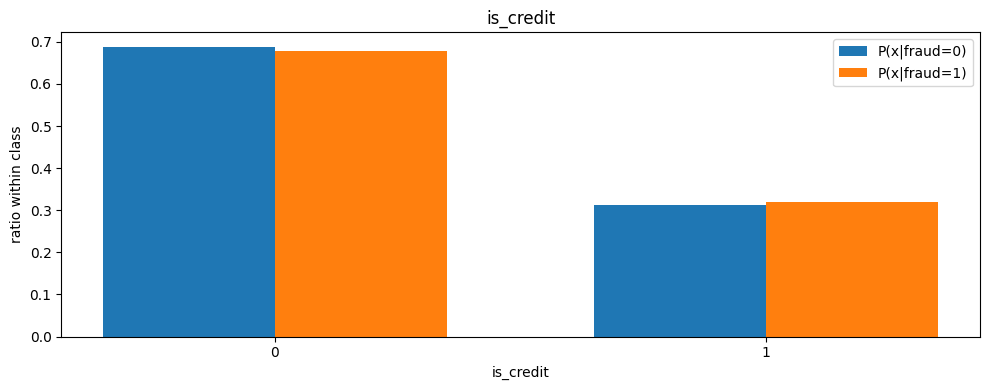

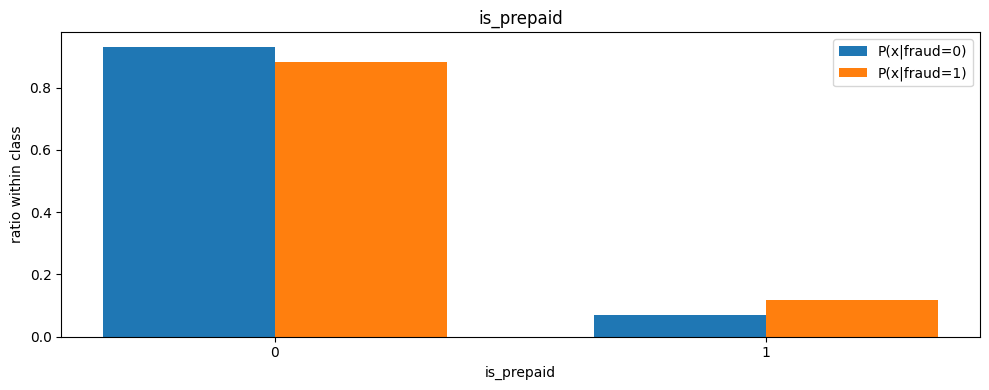

In [94]:
FEATURES = ["is_credit",
            "is_prepaid"]
for c in FEATURES:
    plot_class_ratio_only(df, c, LABEL_COL, bins=20, clip_q=(0.01, 0.99), min_bin_count=30)

In [96]:
for i in FEATURES:
    print(f"[{i}]")
    print(evaluate_numeric_feature(df, i))
    print("\n")

[is_credit]
KS_p          5.918900e-01
MW_p          9.688839e-02
Cohen_d       1.890444e-02
Odds_Ratio    1.041331e+00
Logit_p       9.691109e-02
PR_AUC        1.461188e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[is_prepaid]
KS_p          2.043973e-15
MW_p          3.052664e-60
Cohen_d       1.864330e-01
Odds_Ratio    1.775240e+00
Logit_p       1.146522e-58
PR_AUC        1.563248e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64





---

## 6) 거래 오류/거절 이벤트(Authorization 실패 신호)

* `has_error`
* `err_bad_card_number`
* `err_bad_expiration`
* `err_bad_cvv`
* `err_bad_pin`
* `err_bad_zipcode`
* `err_insufficient_balance`
* `err_technical_glitch`

**분석 포인트**

* fraud에서 error가 **선행 신호**인지(사도 시도→승인 패턴)
* error type 별로 fraud 상승이 있는지
* `has_error`와 개별 err_*는 중복(계층구조) → 어떤 레벨로 쓸지 결정

---


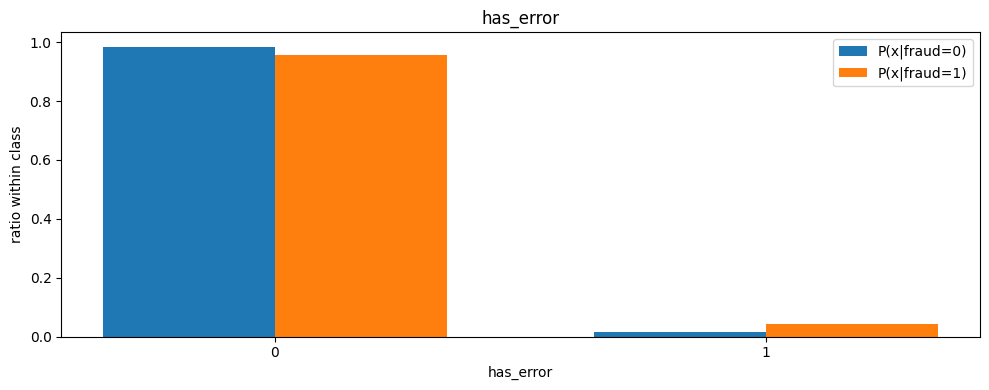

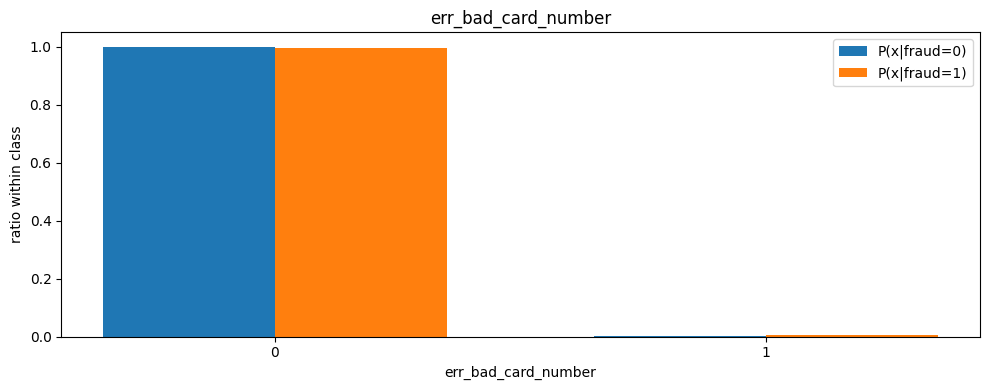

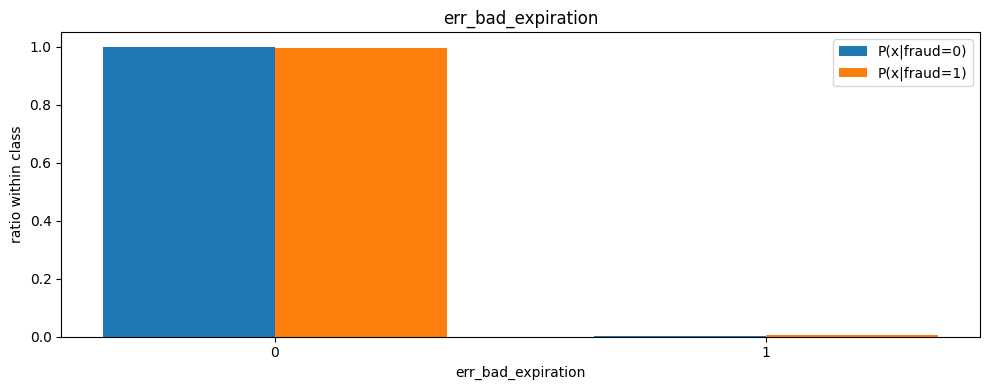

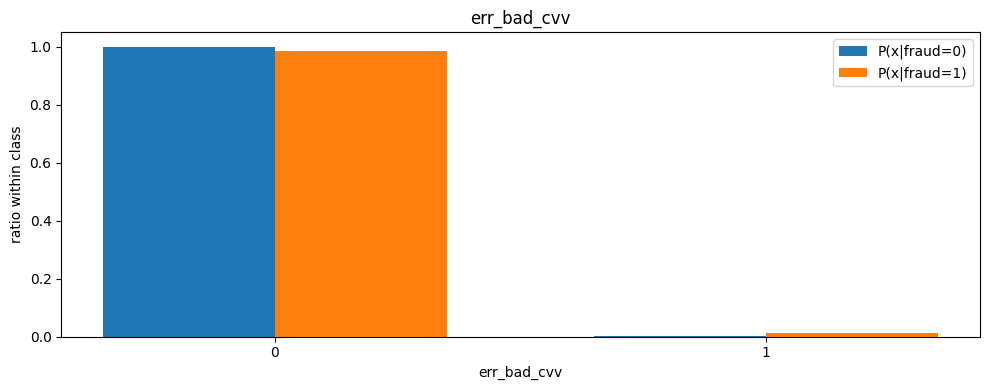

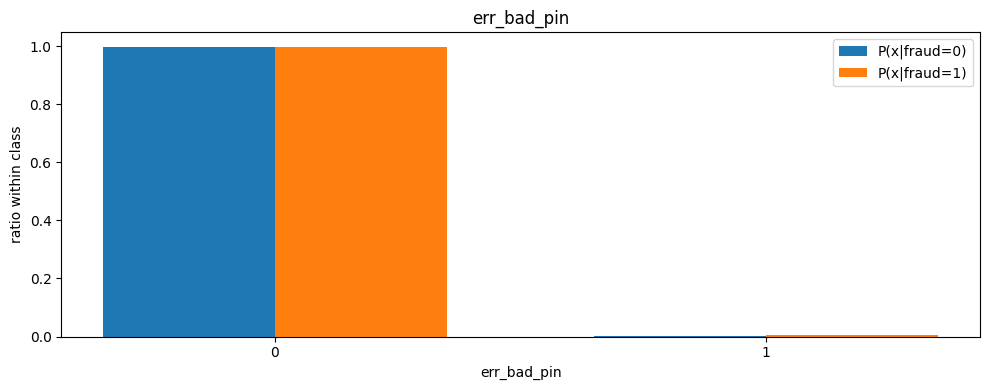

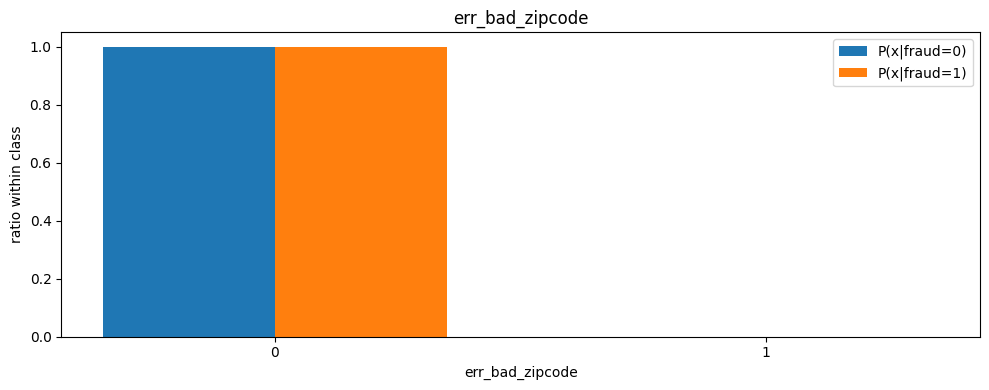

In [97]:
FEATURES = ["has_error",
  "err_bad_card_number",
  "err_bad_expiration",
  "err_bad_cvv",
  "err_bad_pin",
  "err_bad_zipcode",]
for c in FEATURES:
    plot_class_ratio_only(df, c, LABEL_COL, bins=20, clip_q=(0.01, 0.99), min_bin_count=30)


In [98]:
for i in FEATURES:
    print(f"[{i}]")
    print(evaluate_numeric_feature(df, i))
    print("\n")

[has_error]
KS_p          1.056632e-05
MW_p          2.464916e-86
Cohen_d       2.242613e-01
Odds_Ratio    2.850481e+00
Logit_p       5.026441e-79
PR_AUC        1.560184e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[err_bad_card_number]
KS_p          9.783275e-01
MW_p          6.339863e-84
Cohen_d       2.210369e-01
Odds_Ratio    1.026383e+01
Logit_p       4.425987e-55
PR_AUC        1.526439e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[err_bad_expiration]
KS_p          9.991463e-01
MW_p          2.802807e-65
Cohen_d       1.943061e-01
Odds_Ratio    1.014561e+01
Logit_p       3.877390e-43
PR_AUC        1.508729e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[err_bad_cvv]
KS_p           1.235453e-01
MW_p           0.000000e+00
Cohen_d        6.252352e-01
Odds_Ratio     3.182257e+01
Logit_p       6.645506e-265
PR_AUC         2.031463e-03
n              5.332948e+06
pos_rate       1.448167e-03
dtype: f

| 변수              | 해석           |
| --------------- | ------------ |
| has_error       | 에러 자체는 위험 신호 |
| bad_cvv         | 매우 강한 위험 신호  |
| bad_card_number | 약한 위험 신호     |
| bad_expiration  | 약한 위험 신호     |
| bad_pin/zipcode | 무의미          |


---

## 7) 시간 특성(시계열/행동 루틴)

* `tx_year`
* `tx_month`
* `tx_day`
* `tx_hour`
* `is_weekend`

**분석 포인트**

* fraud가 특정 시간대/요일/월에 몰리는지
* 연도별 drift (특히 너 데이터는 2017~2018 fraud=0 이슈 있었지)
* 단순 time feature 자체가 “연도 레이블”처럼 작동할 위험(데이터 생성/라벨링 편향)

---


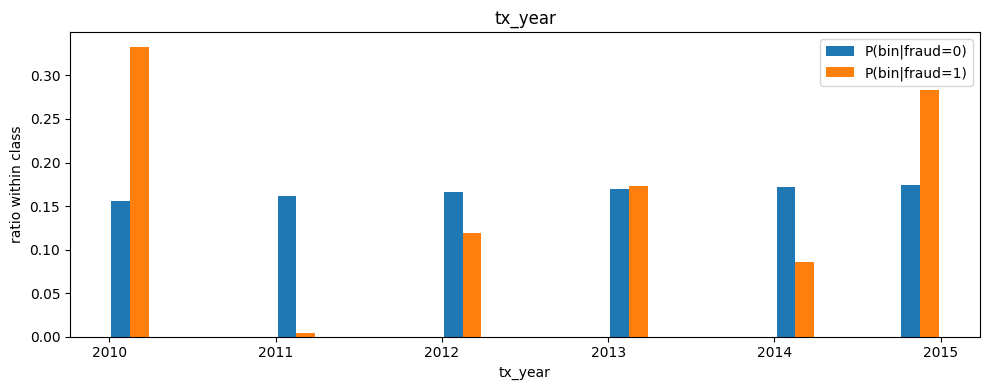

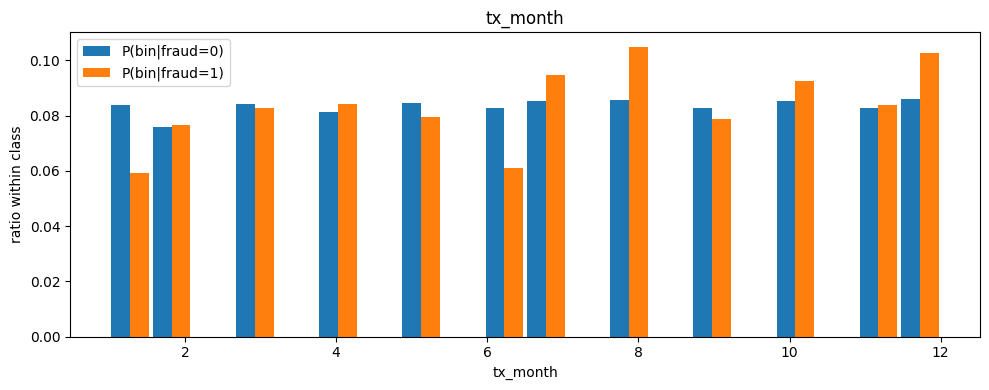

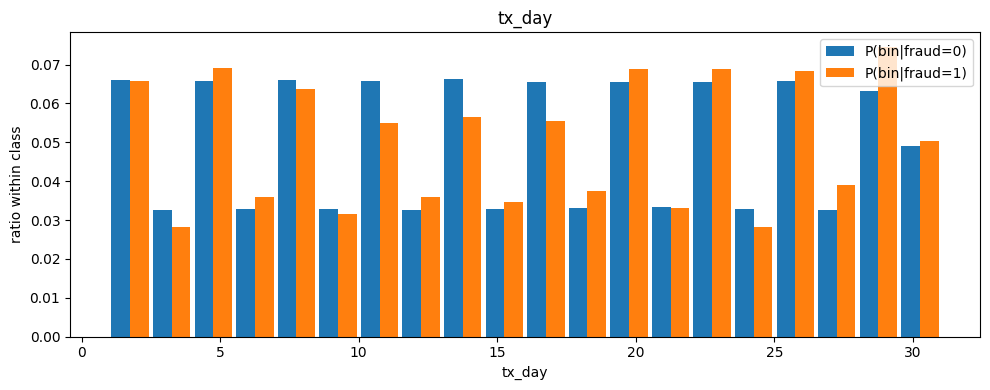

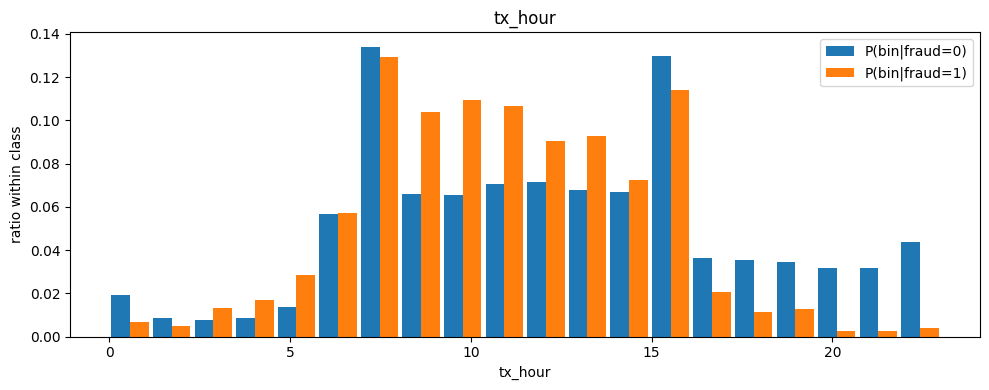

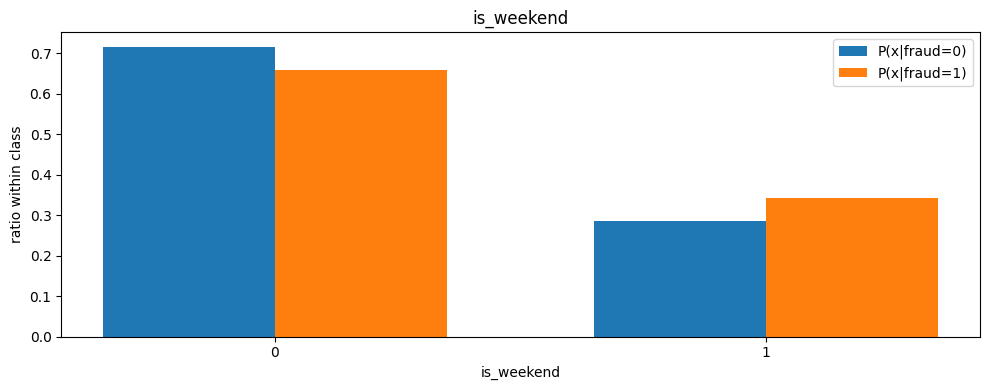

In [99]:
FEATURES = ["tx_year",
  "tx_month",
  "tx_day",
  "tx_hour",
  "is_weekend"]
for c in FEATURES:
    plot_class_ratio_only(df, c, LABEL_COL, bins=20, clip_q=(0.01, 0.99), min_bin_count=30)


In [100]:
for i in FEATURES:
    print(f"[{i}]")
    print(evaluate_numeric_feature(df, i))
    print("\n")

[tx_year]
KS_p          5.186072e-213
MW_p           1.972874e-01
Cohen_d       -2.270046e-02
Odds_Ratio     9.867526e-01
Logit_p        4.622013e-02
PR_AUC         1.962193e-03
n              5.332948e+06
pos_rate       1.448167e-03
dtype: float64


[tx_month]
KS_p          4.384724e-17
MW_p          5.186441e-14
Cohen_d       8.589124e-02
Odds_Ratio    1.025308e+00
Logit_p       4.806236e-14
PR_AUC        1.557051e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[tx_day]
KS_p          2.529284e-05
MW_p          7.776405e-04
Cohen_d       3.825997e-02
Odds_Ratio    1.004361e+00
Logit_p       7.811688e-04
PR_AUC        1.511601e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[tx_hour]
KS_p          8.385084e-208
MW_p          2.384462e-161
Cohen_d       -3.061348e-01
Odds_Ratio     9.407156e-01
Logit_p       4.364365e-158
PR_AUC         1.708789e-03
n              5.332948e+06
pos_rate       1.448167e-03
dtype: float64


[is_weekend]


---

## 8) 업종/상점 카테고리(MCC Group one-hot)

* `mccg_Food_Daily`
* `mccg_Transport_Travel`
* `mccg_Digital_Online`
* `mccg_Financial`
* `mccg_Retail`
* `mccg_Medical`
* `mccg_Entertainment`
* `mccg_Automotive_Home`
* `mccg_Utilities_Government`
* `mccg_Professional_Services`
* `mccg_Industrial_/_Manufacturing`

**분석 포인트**

* 어떤 카테고리에서 base rate가 높은지
* 온라인 결제(`is_online`)와 결합될 때 상승하는 카테고리(상호작용)
* one-hot 다중공선성(기준 카테고리 빠졌는지 확인)

---

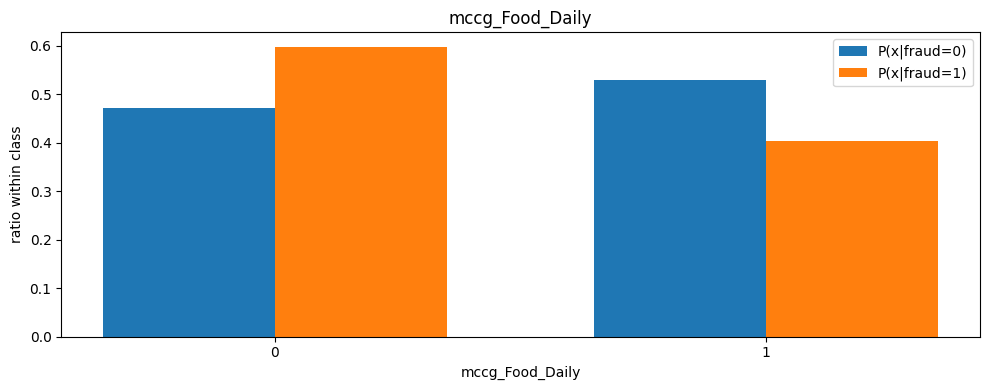

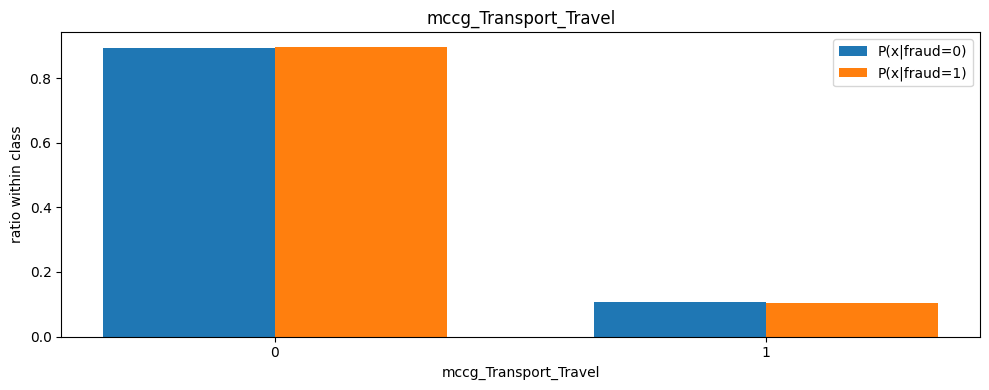

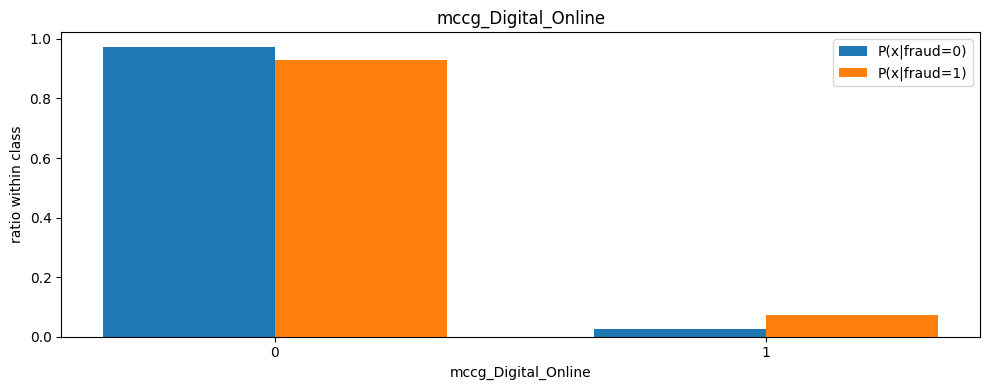

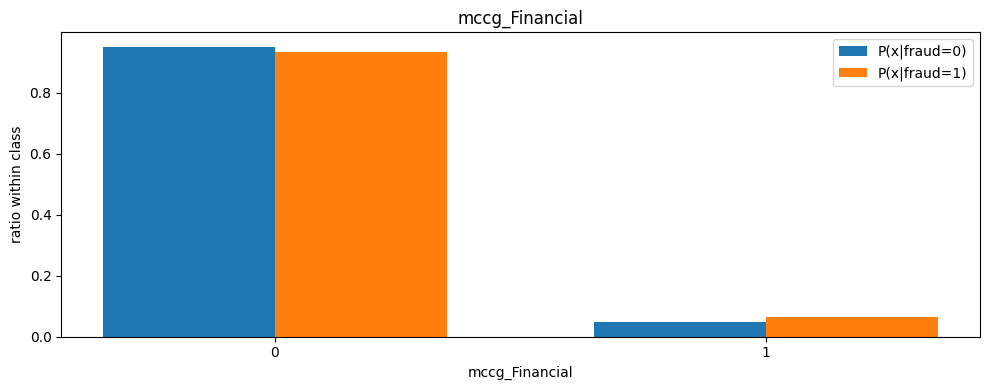

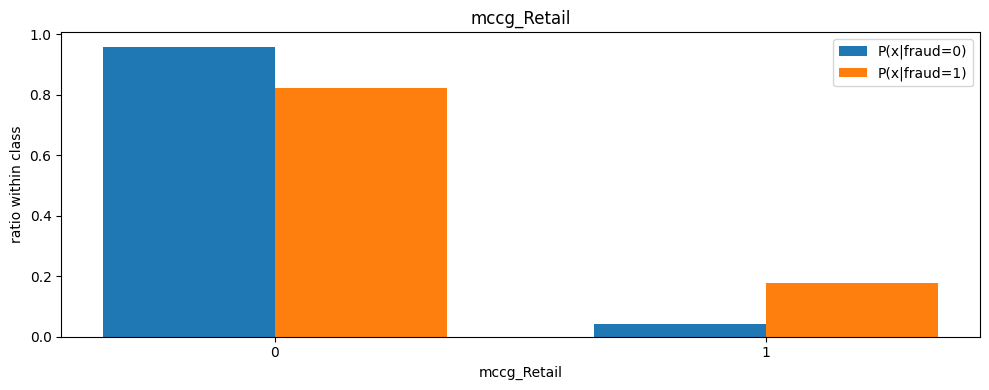

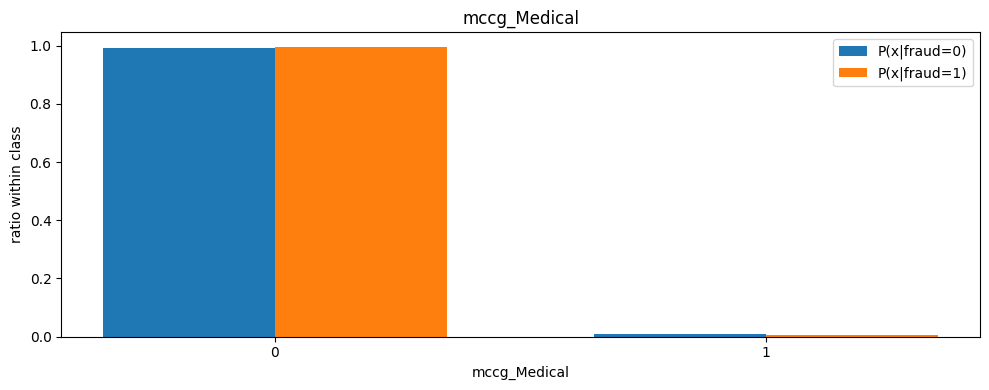

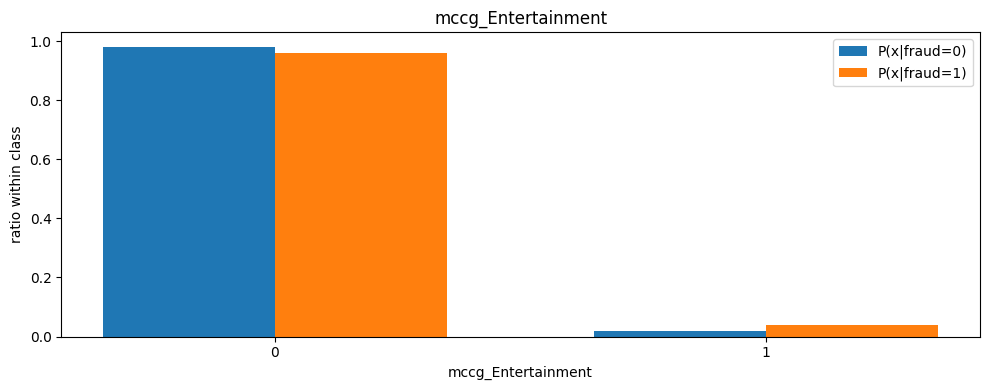

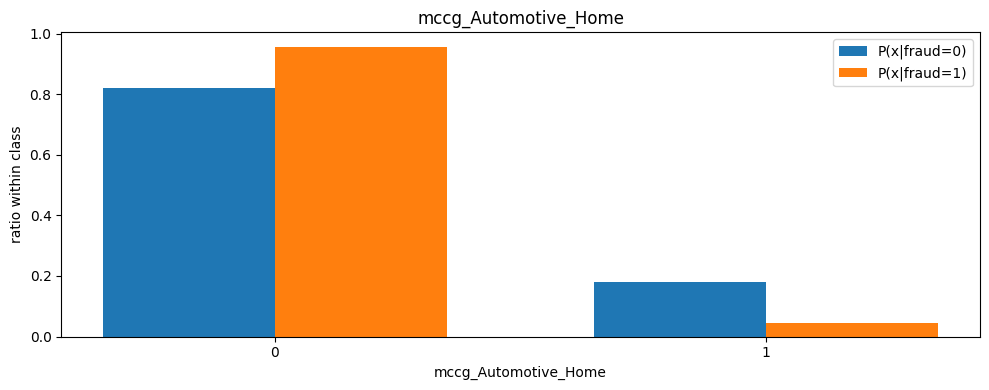

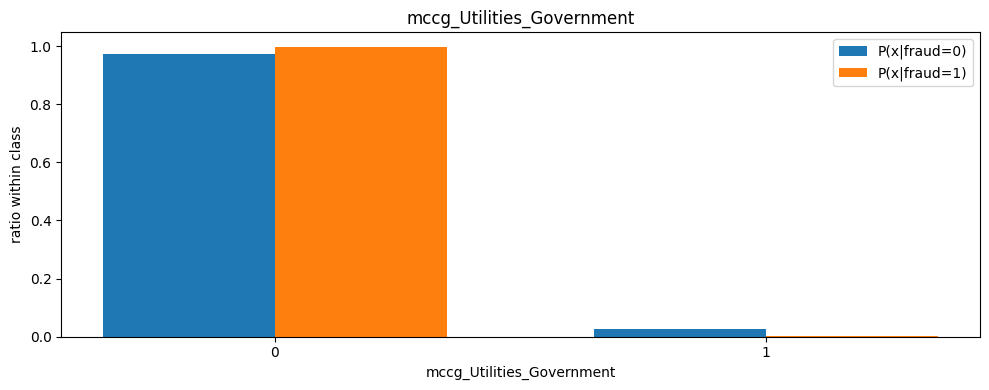

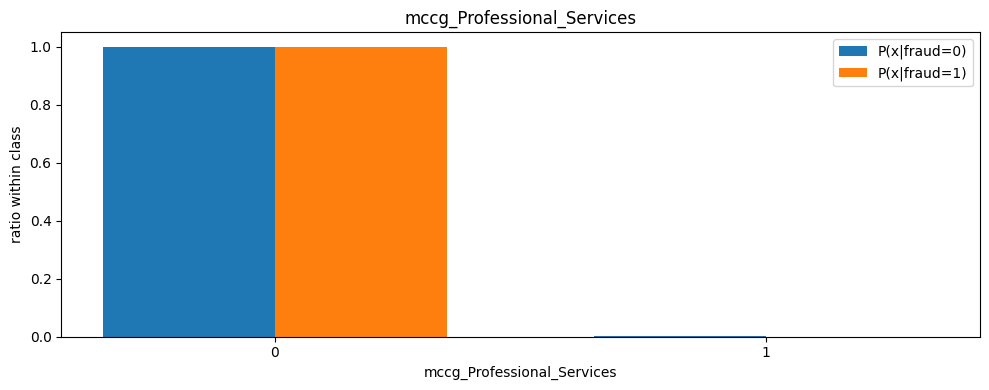

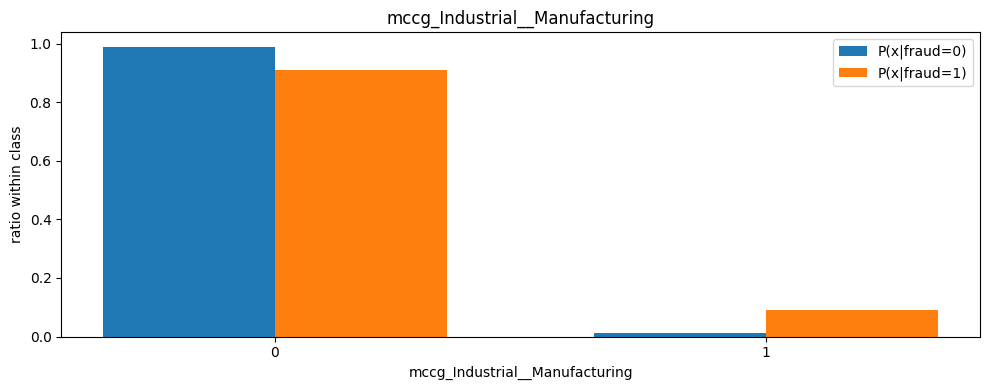

In [103]:
FEATURES = ["mccg_Food_Daily",
"mccg_Transport_Travel",
"mccg_Digital_Online",
"mccg_Financial",
"mccg_Retail",
"mccg_Medical",
"mccg_Entertainment",
"mccg_Automotive_Home",
"mccg_Utilities_Government",
"mccg_Professional_Services",
"mccg_Industrial__Manufacturing"]
for c in FEATURES:
    plot_class_ratio_only(df, c, LABEL_COL, bins=20, clip_q=(0.01, 0.99), min_bin_count=30)


In [104]:
for i in FEATURES:
    print(f"[{i}]")
    print(evaluate_numeric_feature(df, i))
    print("\n")

[mccg_Food_Daily]
KS_p          6.210712e-109
MW_p          1.247912e-110
Cohen_d       -2.545018e-01
Odds_Ratio     5.985253e-01
Logit_p       2.761037e-108
PR_AUC         1.681363e-03
n              5.332948e+06
pos_rate       1.448167e-03
dtype: float64


[mccg_Transport_Travel]
KS_p          9.996503e-01
MW_p          2.565658e-01
Cohen_d      -1.291944e-02
Odds_Ratio    9.584028e-01
Logit_p       2.566014e-01
PR_AUC        1.453969e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mccg_Digital_Online]
KS_p           5.336230e-14
MW_p          6.275588e-134
Cohen_d        2.804672e-01
Odds_Ratio     2.837560e+00
Logit_p       1.318260e-122
PR_AUC         1.623789e-03
n              5.332948e+06
pos_rate       1.448167e-03
dtype: float64


[mccg_Financial]
KS_p          2.723960e-02
MW_p          1.272021e-11
Cohen_d       7.711285e-02
Odds_Ratio    1.363293e+00
Logit_p       1.532453e-11
PR_AUC        1.480434e-03
n             5.332948e+06
pos_rate      1

[mccg_Digital_Online] -> Odds ratio    2.84\
[mccg_Financial] -> Odds_Ratio    1.363293e+00\
[mccg_Retail] -> Odds_Ratio     4.993347e+00\
[mccg_Entertainment] -> Odds_Ratio    2.037927e+00\
[mccg_Industrial__Manufacturing] -> Odds_Ratio    8.916010e+00

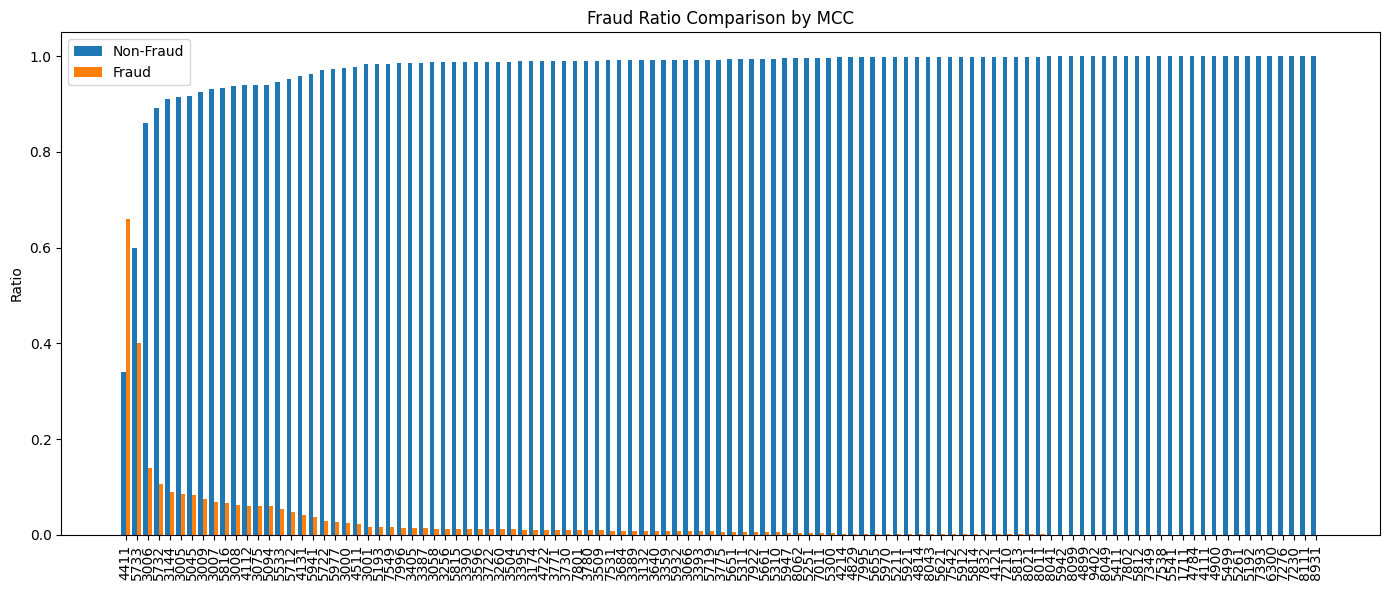

In [105]:
# mcc별 fraud count
mcc_counts = (
    df.groupby(["mcc", "fraud"])
      .size()
      .unstack(fill_value=0)
)

# 각 mcc별 전체 건수
mcc_counts["total"] = mcc_counts.sum(axis=1)

# ratio 계산
mcc_counts["fraud_ratio"] = mcc_counts[1] / mcc_counts["total"]
mcc_counts["nonfraud_ratio"] = mcc_counts[0] / mcc_counts["total"]

# fraud_ratio 기준 정렬
mcc_counts = mcc_counts.sort_values("fraud_ratio", ascending=False)

x = np.arange(len(mcc_counts))
width = 0.4

plt.figure(figsize=(14, 6))

plt.bar(x - width/2, mcc_counts["nonfraud_ratio"], width, label="Non-Fraud")
plt.bar(x + width/2, mcc_counts["fraud_ratio"], width, label="Fraud")

plt.xticks(x, mcc_counts.index, rotation=90)
plt.ylabel("Ratio")
plt.title("Fraud Ratio Comparison by MCC")
plt.legend()
plt.tight_layout()
plt.show()

In [106]:
# 1) count + ratio 테이블 만들기
mcc_tbl = (
    df.groupby(["mcc", "fraud"])
      .size()
      .unstack(fill_value=0)
      .rename(columns={0:"n_nonfraud", 1:"n_fraud"})
)

mcc_tbl["n_total"] = mcc_tbl["n_nonfraud"] + mcc_tbl["n_fraud"]
mcc_tbl["fraud_ratio"] = mcc_tbl["n_fraud"] / mcc_tbl["n_total"]
mcc_tbl["nonfraud_ratio"] = mcc_tbl["n_nonfraud"] / mcc_tbl["n_total"]

# 2) (중요) 표본수 너무 작은 MCC는 따로 걸러서 “안정적”인 것만 보기
min_n = 50  # 필요하면 100, 200으로 올려도 됨
mcc_tbl_f = mcc_tbl[mcc_tbl["n_total"] >= min_n].copy()

# 3) 보기 좋은 컬럼만 + 정렬
cols = ["n_total", "n_fraud", "n_nonfraud", "fraud_ratio"]
top = mcc_tbl_f.sort_values("fraud_ratio", ascending=False)[cols].head(20)
bottom = mcc_tbl_f.sort_values("fraud_ratio", ascending=True)[cols].head(20)

print("=== TOP 20 MCC by fraud_ratio (filtered by n_total>=min_n) ===")
display(top)

print("=== BOTTOM 20 MCC by fraud_ratio (filtered by n_total>=min_n) ===")
display(bottom)


=== TOP 20 MCC by fraud_ratio (filtered by n_total>=min_n) ===


fraud,n_total,n_fraud,n_nonfraud,fraud_ratio
mcc,,,,
4411,197,130,67,0.659898
5733,135,54,81,0.400000
3006,151,21,130,0.139073
5732,2838,304,2534,0.107118
3144,123,11,112,0.089431
3005,164,14,150,0.085366
5045,1098,91,1007,0.082878
3009,147,11,136,0.074830
3007,160,11,149,0.068750


=== BOTTOM 20 MCC by fraud_ratio (filtered by n_total>=min_n) ===


fraud,n_total,n_fraud,n_nonfraud,fraud_ratio
mcc,,,,
1711,1250,0,1250,0.000000
4900,97230,0,97230,0.000000
5499,587350,0,587350,0.000000
5261,2817,0,2817,0.000000
5192,4184,0,4184,0.000000
4111,34617,0,34617,0.000000
4784,259242,0,259242,0.000000
7393,5187,0,5187,0.000000
6300,20668,0,20668,0.000000


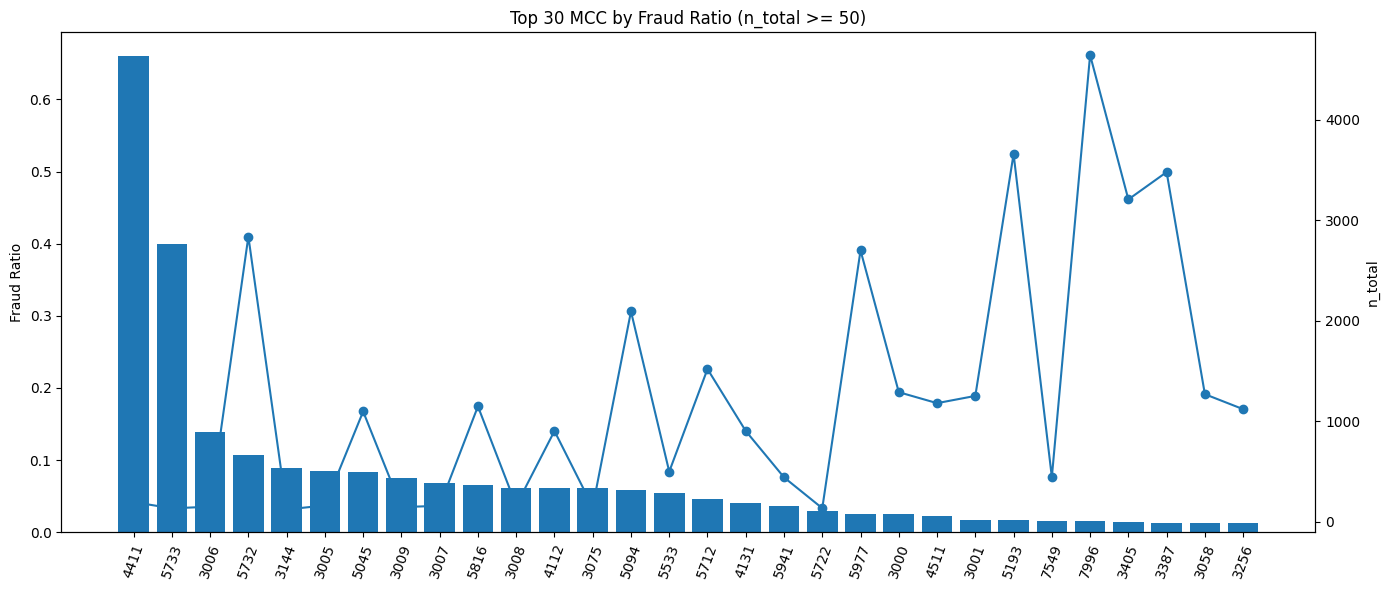

In [107]:
import matplotlib.pyplot as plt

top_n = 30

tmp = mcc_tbl_f.sort_values("fraud_ratio", ascending=False).head(top_n).copy()

x = np.arange(len(tmp))

fig, ax1 = plt.subplots(figsize=(14, 6))

# fraud_ratio bar
ax1.bar(x, tmp["fraud_ratio"])
ax1.set_ylabel("Fraud Ratio")
ax1.set_title(f"Top {top_n} MCC by Fraud Ratio (n_total >= {min_n})")
ax1.set_xticks(x)
ax1.set_xticklabels(tmp.index.astype(str), rotation=70)

# n_total line (secondary axis)
ax2 = ax1.twinx()
ax2.plot(x, tmp["n_total"], marker="o")
ax2.set_ylabel("n_total")

fig.tight_layout()
plt.show()


In [108]:
# 원핫할 mcc 후보 (표본수 기준)
valid_mcc = mcc_tbl[mcc_tbl["n_total"] >= min_n].index

df_mcc = df[df["mcc"].isin(valid_mcc)].copy()

# one-hot (prefix 넣어서 컬럼명 명확하게)
mcc_ohe = pd.get_dummies(df_mcc["mcc"].astype(str), prefix="mcc", dtype="int8")

# 원본 df에 붙이기 (원하면 기존 mcc는 drop)
df_ohe = pd.concat([df_mcc.drop(columns=["mcc"], errors="ignore"), mcc_ohe], axis=1)

mcc_ohe_cols = mcc_ohe.columns.tolist()


In [111]:
for i in mcc_ohe_cols:
    print(f"[{i}]")
    print(evaluate_numeric_feature(df_ohe, i))
    print("\n")

[mcc_1711]
KS_p          1.000000e+00
MW_p          1.781178e-01
Cohen_d      -1.533386e-02
Odds_Ratio    4.078422e-22
Logit_p       1.000000e+00
PR_AUC        1.448507e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_3000]
KS_p           9.997711e-01
MW_p          6.972929e-108
Cohen_d        2.512641e-01
Odds_Ratio     1.760848e+01
Logit_p        1.475499e-57
PR_AUC         1.544950e-03
n              5.332948e+06
pos_rate       1.448167e-03
dtype: float64


[mcc_3001]
KS_p          1.000000e+00
MW_p          4.201595e-46
Cohen_d       1.623240e-01
Odds_Ratio    1.178264e+01
Logit_p       4.394213e-29
PR_AUC        1.489802e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_3005]
KS_p           1.000000e+00
MW_p          1.042919e-175
Cohen_d        3.218412e-01
Odds_Ratio     6.447101e+01
Logit_p        3.501086e-50
PR_AUC         1.600290e-03
n              5.332948e+06
pos_rate       1.448167e-03
dtype: float64


[mcc_300

/home/nakyung/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


KS_p          8.981797e-01
MW_p          1.172432e-12
Cohen_d      -8.094808e-02
Odds_Ratio    1.957778e-07
Logit_p       9.612510e-01
PR_AUC        1.457629e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_4112]
KS_p           8.462153e-01
MW_p           0.000000e+00
Cohen_d        5.348964e-01
Odds_Ratio     4.498230e+01
Logit_p       1.132285e-163
PR_AUC         1.871136e-03
n              5.332948e+06
pos_rate       1.448167e-03
dtype: float64


[mcc_4121]
KS_p          5.266882e-03
MW_p          6.971704e-20
Cohen_d      -1.039453e-01
Odds_Ratio    4.601819e-01
Logit_p       5.434921e-19
PR_AUC        1.477088e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_4131]
KS_p           9.962480e-01
MW_p          5.939448e-214
Cohen_d        3.555300e-01
Odds_Ratio     2.956307e+01
Logit_p        4.281983e-90
PR_AUC         1.637316e-03
n              5.332948e+06
pos_rate       1.448167e-03
dtype: float64


[mcc_4214]
KS_p    

/home/nakyung/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


KS_p          2.534684e-16
MW_p          6.167583e-88
Cohen_d      -2.263786e-01
Odds_Ratio    8.984247e-06
Logit_p       4.886811e-01
PR_AUC        1.522162e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_4814]
KS_p          9.996658e-01
MW_p          5.878824e-03
Cohen_d      -3.136600e-02
Odds_Ratio    7.541909e-01
Logit_p       6.044565e-03
PR_AUC        1.453953e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_4829]
KS_p          2.057295e-03
MW_p          3.118245e-19
Cohen_d       1.020819e-01
Odds_Ratio    1.505419e+00
Logit_p       5.469118e-19
PR_AUC        1.493049e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_4899]
KS_p          9.999997e-01
MW_p          2.105720e-05
Cohen_d      -4.843464e-02
Odds_Ratio    2.294511e-01
Logit_p       9.929774e-05
PR_AUC        1.452565e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_4900]


/home/nakyung/.local/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


KS_p          1.154924e-02
MW_p          4.284544e-33
Cohen_d      -1.364731e-01
Odds_Ratio             NaN
Logit_p                NaN
PR_AUC        1.475060e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_5045]
KS_p           2.491263e-01
MW_p           0.000000e+00
Cohen_d        8.084651e-01
Odds_Ratio     6.304191e+01
Logit_p       3.239750e-310
PR_AUC         2.407653e-03
n              5.332948e+06
pos_rate       1.448167e-03
dtype: float64


[mcc_5094]
KS_p          4.448536e-02
MW_p          0.000000e+00
Cohen_d       7.923164e-01
Odds_Ratio    4.411608e+01
Logit_p       0.000000e+00
PR_AUC        2.376151e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_5192]


/home/nakyung/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


KS_p          1.000000e+00
MW_p          1.372884e-02
Cohen_d      -2.806158e-02
Odds_Ratio    4.024339e-06
Logit_p       9.510293e-01
PR_AUC        1.449304e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_5193]
KS_p           8.130721e-01
MW_p          1.257425e-129
Cohen_d        2.758563e-01
Odds_Ratio     1.177527e+01
Logit_p        1.070231e-80
PR_AUC         1.568406e-03
n              5.332948e+06
pos_rate       1.448167e-03
dtype: float64


[mcc_5211]
KS_p          1.000000e+00
MW_p          1.025915e-01
Cohen_d      -1.858887e-02
Odds_Ratio    8.370120e-01
Logit_p       1.030450e-01
PR_AUC        1.451232e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_5251]
KS_p          9.933954e-01
MW_p          2.414142e-16
Cohen_d       9.337080e-02
Odds_Ratio    2.817790e+00
Logit_p       4.362601e-15
PR_AUC        1.467709e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_5261]


/home/nakyung/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


KS_p          1.000000e+00
MW_p          4.319993e-02
Cohen_d      -2.302258e-02
Odds_Ratio    4.018666e-06
Logit_p       9.598384e-01
PR_AUC        1.448932e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_5300]
KS_p          7.977989e-15
MW_p          8.074285e-85
Cohen_d       2.222396e-01
Odds_Ratio    2.121897e+00
Logit_p       5.061376e-81
PR_AUC        1.583232e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_5310]
KS_p           3.250658e-13
MW_p          1.903566e-176
Cohen_d        3.225251e-01
Odds_Ratio     3.501177e+00
Logit_p       2.464305e-155
PR_AUC         1.658687e-03
n              5.332948e+06
pos_rate       1.448167e-03
dtype: float64


[mcc_5311]
KS_p          1.706873e-95
MW_p          0.000000e+00
Cohen_d       6.398411e-01
Odds_Ratio    4.942692e+00
Logit_p       0.000000e+00
PR_AUC        2.189767e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_5411]
KS_p           9

/home/nakyung/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


KS_p           3.635240e-82
MW_p          3.537520e-210
Cohen_d       -3.523476e-01
Odds_Ratio     2.924161e-09
Logit_p        9.737711e-01
PR_AUC         1.627403e-03
n              5.332948e+06
pos_rate       1.448167e-03
dtype: float64


[mcc_5533]
KS_p           9.999898e-01
MW_p          1.093655e-209
Cohen_d        3.519322e-01
Odds_Ratio     3.949453e+01
Logit_p        8.434136e-77
PR_AUC         1.631891e-03
n              5.332948e+06
pos_rate       1.448167e-03
dtype: float64


[mcc_5541]
KS_p           2.406709e-77
MW_p          1.608498e-201
Cohen_d       -3.449384e-01
Odds_Ratio     8.561015e-03
Logit_p        2.772300e-41
PR_AUC         1.621431e-03
n              5.332948e+06
pos_rate       1.448167e-03
dtype: float64


[mcc_5621]
KS_p          1.000000e+00
MW_p          4.067522e-01
Cohen_d      -9.447182e-03
Odds_Ratio    6.621959e-01
Logit_p       4.100654e-01
PR_AUC        1.448549e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_5651]


/home/nakyung/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


KS_p          9.997994e-01
MW_p          4.122958e-08
Cohen_d      -6.246536e-02
Odds_Ratio    6.408830e-09
Logit_p       9.933898e-01
PR_AUC        1.453801e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_7011]
KS_p          1.000000e+00
MW_p          7.673677e-07
Cohen_d       5.629323e-02
Odds_Ratio    2.599730e+00
Logit_p       1.932383e-06
PR_AUC        1.455614e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_7210]
KS_p          1.000000e+00
MW_p          1.584620e-02
Cohen_d      -2.747123e-02
Odds_Ratio    4.362063e-01
Logit_p       1.904661e-02
PR_AUC        1.450101e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_7230]


/home/nakyung/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


KS_p          6.955381e-01
MW_p          2.376278e-15
Cohen_d      -9.018743e-02
Odds_Ratio    2.332247e-07
Logit_p       9.534221e-01
PR_AUC        1.459912e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_7276]


/home/nakyung/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


KS_p          1.000000e+00
MW_p          1.417739e-01
Cohen_d      -1.673046e-02
Odds_Ratio    3.324418e-06
Logit_p       9.730436e-01
PR_AUC        1.448571e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_7349]
KS_p          9.998865e-01
MW_p          1.041848e-07
Cohen_d      -6.057240e-02
Odds_Ratio    3.303953e-02
Logit_p       6.502306e-04
PR_AUC        1.453646e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_7393]


/home/nakyung/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


KS_p          1.000000e+00
MW_p          6.068466e-03
Cohen_d      -3.124751e-02
Odds_Ratio    4.733292e-09
Logit_p       9.971126e-01
PR_AUC        1.449577e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_7531]
KS_p          1.000000e+00
MW_p          4.593428e-05
Cohen_d       4.640803e-02
Odds_Ratio    6.024681e+00
Logit_p       3.499238e-04
PR_AUC        1.451901e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_7538]
KS_p          1.463612e-08
MW_p          4.565205e-61
Cohen_d      -1.877453e-01
Odds_Ratio    2.448289e-02
Logit_p       1.014432e-22
PR_AUC        1.500341e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_7542]
KS_p          1.000000e+00
MW_p          9.998396e-02
Cohen_d      -1.873137e-02
Odds_Ratio    6.556078e-01
Logit_p       1.025156e-01
PR_AUC        1.449640e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_7549]
KS_p          1.000000e+

/home/nakyung/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


KS_p          1.000000e+00
MW_p          4.145670e-02
Cohen_d      -2.321800e-02
Odds_Ratio    2.182347e-06
Logit_p       9.686810e-01
PR_AUC        1.448946e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_8931]


/home/nakyung/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


KS_p          1.000000e+00
MW_p          1.496427e-01
Cohen_d      -1.640680e-02
Odds_Ratio    5.902541e-07
Logit_p       9.873330e-01
PR_AUC        1.448556e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_9402]
KS_p          9.452760e-01
MW_p          1.313632e-09
Cohen_d      -6.907256e-02
Odds_Ratio    2.054947e-01
Logit_p       4.343519e-08
PR_AUC        1.456841e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64




[mcc_1711]
KS_p          1.000000e+00
MW_p          1.781178e-01
Cohen_d      -1.533386e-02
Odds_Ratio    4.078422e-22
Logit_p       1.000000e+00
PR_AUC        1.448507e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_3000]
KS_p           9.997711e-01
MW_p          6.972929e-108
Cohen_d        2.512641e-01
Odds_Ratio     1.760848e+01
Logit_p        1.475499e-57
PR_AUC         1.544950e-03
n              5.332948e+06
pos_rate       1.448167e-03
dtype: float64


[mcc_3001]
KS_p          1.000000e+00
MW_p          4.201595e-46
Cohen_d       1.623240e-01
Odds_Ratio    1.178264e+01
Logit_p       4.394213e-29
PR_AUC        1.489802e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_3005]
KS_p           1.000000e+00
MW_p          1.042919e-175
Cohen_d        3.218412e-01
Odds_Ratio     6.447101e+01
Logit_p        3.501086e-50
PR_AUC         1.600290e-03
n              5.332948e+06
pos_rate       1.448167e-03
dtype: float64


[mcc_3006]
KS_p          1.000000e+00
MW_p          0.000000e+00
Cohen_d       5.065221e-01
Odds_Ratio    1.116863e+02
Logit_p       3.166461e-89
PR_AUC        1.822389e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_3007]
KS_p           1.000000e+00
MW_p          5.251768e-111
Cohen_d        2.549416e-01
Odds_Ratio     5.097594e+01
Logit_p        2.924724e-36
PR_AUC         1.544026e-03
n              5.332948e+06
pos_rate       1.448167e-03
dtype: float64


[mcc_3008]
KS_p          1.000000e+00
MW_p          5.857259e-90
Cohen_d       2.290244e-01
Odds_Ratio    4.512433e+01
Logit_p       1.947419e-31
PR_AUC        1.525730e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_3009]
KS_p           1.000000e+00
MW_p          4.596912e-121
Cohen_d        2.664416e-01
Odds_Ratio     5.584877e+01
Logit_p        1.199252e-37
PR_AUC         1.552686e-03
n              5.332948e+06
pos_rate       1.448167e-03
dtype: float64


[mcc_3058]
KS_p          1.000000e+00
MW_p          1.455060e-25
Cohen_d       1.190063e-01
Odds_Ratio    8.813994e+00
Logit_p       5.548612e-18
PR_AUC        1.471267e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_3066]
KS_p          1.000000e+00
MW_p          6.626471e-07
Cohen_d       5.661794e-02
Odds_Ratio    4.911725e+00
Logit_p       7.341163e-06
PR_AUC        1.453988e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_3075]
KS_p          1.000000e+00
MW_p          2.011621e-80
Cohen_d       2.162677e-01
Odds_Ratio    4.469662e+01
Logit_p       2.407381e-28
PR_AUC        1.517345e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_3132]
KS_p          1.000000e+00
MW_p          7.169082e-09
Cohen_d       6.589768e-02
Odds_Ratio    5.576026e+00
Logit_p       2.870516e-07
PR_AUC        1.455819e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_3144]
KS_p           1.000000e+00
MW_p          3.252042e-145
Cohen_d        2.922192e-01
Odds_Ratio     6.781667e+01
Logit_p        1.412406e-40
PR_AUC         1.573482e-03
n              5.332948e+06
pos_rate       1.448167e-03
dtype: float64


[mcc_3174]
KS_p          1.000000e+00
MW_p          2.847882e-16
Cohen_d       9.314433e-02
Odds_Ratio    7.511783e+00
Logit_p       3.859666e-12
PR_AUC        1.462639e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_3256]
KS_p          1.000000e+00
MW_p          2.432799e-22
Cohen_d       1.107070e-01
Odds_Ratio    8.734339e+00
Logit_p       8.203295e-16
PR_AUC        1.468181e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_3260]
KS_p          1.000000e+00
MW_p          1.626841e-18
Cohen_d       9.998763e-02
Odds_Ratio    7.881526e+00
Logit_p       1.409323e-13
PR_AUC        1.464725e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_3359]
KS_p          9.999675e-01
MW_p          2.441852e-27
Cohen_d       1.233429e-01
Odds_Ratio    5.303878e+00
Logit_p       4.032393e-22
PR_AUC        1.475278e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_3387]
KS_p          9.806923e-01
MW_p          1.478781e-74
Cohen_d       2.080340e-01
Odds_Ratio    9.288603e+00
Logit_p       1.121612e-50
PR_AUC        1.518296e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_3389]
KS_p          9.999500e-01
MW_p          1.296837e-30
Cohen_d       1.309726e-01
Odds_Ratio    5.767054e+00
Logit_p       3.239950e-24
PR_AUC        1.478175e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_3390]
KS_p          9.980394e-01
MW_p          6.378124e-54
Cohen_d       1.760613e-01
Odds_Ratio    8.109029e+00
Logit_p       2.002272e-38
PR_AUC        1.499295e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_3393]
KS_p          1.000000e+00
MW_p          5.020100e-17
Cohen_d       9.549726e-02
Odds_Ratio    4.883808e+00
Logit_p       3.793977e-14
PR_AUC        1.464750e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_3395]
KS_p          9.992784e-01
MW_p          2.096633e-47
Cohen_d       1.646901e-01
Odds_Ratio    7.611156e+00
Logit_p       1.696683e-34
PR_AUC        1.493319e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_3405]
KS_p          9.873980e-01
MW_p          1.177596e-74
Cohen_d       2.081755e-01
Odds_Ratio    9.641148e+00
Logit_p       4.083322e-50
PR_AUC        1.518083e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_3504]
KS_p          7.020642e-01
MW_p          2.279449e-92
Cohen_d       2.321378e-01
Odds_Ratio    7.846165e+00
Logit_p       3.611076e-66
PR_AUC        1.537467e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_3509]
KS_p          9.020027e-01
MW_p          4.478361e-61
Cohen_d       1.877585e-01
Odds_Ratio    6.533763e+00
Logit_p       2.334127e-46
PR_AUC        1.508354e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_3596]
KS_p          7.617586e-01
MW_p          4.257518e-91
Cohen_d       2.305005e-01
Odds_Ratio    8.117260e+00
Logit_p       1.429282e-64
PR_AUC        1.535785e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_3640]
KS_p          9.875874e-01
MW_p          1.289463e-40
Cohen_d       1.519513e-01
Odds_Ratio    5.583598e+00
Logit_p       2.700689e-32
PR_AUC        1.488838e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_3684]
KS_p          9.473461e-01
MW_p          2.499685e-51
Cohen_d       1.716259e-01
Odds_Ratio    6.029821e+00
Logit_p       6.701097e-40
PR_AUC        1.499228e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_3722]
KS_p          6.994447e-01
MW_p          3.791753e-94
Cohen_d       2.344098e-01
Odds_Ratio    7.966628e+00
Logit_p       4.108737e-67
PR_AUC        1.539023e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_3730]
KS_p          9.285414e-01
MW_p          5.637485e-61
Cohen_d       1.876000e-01
Odds_Ratio    6.781944e+00
Logit_p       8.630362e-46
PR_AUC        1.507858e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_3771]
KS_p          9.038423e-01
MW_p          8.242590e-67
Cohen_d       1.966378e-01
Odds_Ratio    7.091666e+00
Logit_p       1.758874e-49
PR_AUC        1.513256e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_3775]
KS_p          9.997990e-01
MW_p          4.933793e-26
Cohen_d       1.201687e-01
Odds_Ratio    4.754930e+00
Logit_p       1.234246e-21
PR_AUC        1.474610e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_3780]
KS_p          9.302918e-01
MW_p          1.797289e-59
Cohen_d       1.852003e-01
Odds_Ratio    6.652902e+00
Logit_p       6.418179e-45
PR_AUC        1.506537e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_4111]
/home/nakyung/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
KS_p          8.981797e-01
MW_p          1.172432e-12
Cohen_d      -8.094808e-02
Odds_Ratio    1.957778e-07
Logit_p       9.612510e-01
PR_AUC        1.457629e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_4112]
KS_p           8.462153e-01
MW_p           0.000000e+00
Cohen_d        5.348964e-01
Odds_Ratio     4.498230e+01
Logit_p       1.132285e-163
PR_AUC         1.871136e-03
n              5.332948e+06
pos_rate       1.448167e-03
dtype: float64


[mcc_4121]
KS_p          5.266882e-03
MW_p          6.971704e-20
Cohen_d      -1.039453e-01
Odds_Ratio    4.601819e-01
Logit_p       5.434921e-19
PR_AUC        1.477088e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_4131]
KS_p           9.962480e-01
MW_p          5.939448e-214
Cohen_d        3.555300e-01
Odds_Ratio     2.956307e+01
Logit_p        4.281983e-90
PR_AUC         1.637316e-03
n              5.332948e+06
pos_rate       1.448167e-03
dtype: float64


[mcc_4214]
KS_p          9.991745e-01
MW_p          1.906643e-05
Cohen_d       4.868717e-02
Odds_Ratio    1.568369e+00
Logit_p       2.238278e-05
PR_AUC        1.457626e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_4411]
KS_p          2.517280e-02
MW_p          0.000000e+00
Cohen_d       2.782977e+00
Odds_Ratio    1.360779e+03
Logit_p       0.000000e+00
PR_AUC        1.253175e-02
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_4511]
KS_p          9.999964e-01
MW_p          1.883518e-83
Cohen_d       2.203988e-01
Odds_Ratio    1.618590e+01
Logit_p       3.087968e-46
PR_AUC        1.523031e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_4722]
KS_p           7.519759e-02
MW_p          2.690591e-149
Cohen_d        2.963559e-01
Odds_Ratio     7.173197e+00
Logit_p       1.191637e-109
PR_AUC         1.595722e-03
n              5.332948e+06
pos_rate       1.448167e-03
dtype: float64


[mcc_4784]
/home/nakyung/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
KS_p          2.534684e-16
MW_p          6.167583e-88
Cohen_d      -2.263786e-01
Odds_Ratio    8.984247e-06
Logit_p       4.886811e-01
PR_AUC        1.522162e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_4814]
KS_p          9.996658e-01
MW_p          5.878824e-03
Cohen_d      -3.136600e-02
Odds_Ratio    7.541909e-01
Logit_p       6.044565e-03
PR_AUC        1.453953e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_4829]
KS_p          2.057295e-03
MW_p          3.118245e-19
Cohen_d       1.020819e-01
Odds_Ratio    1.505419e+00
Logit_p       5.469118e-19
PR_AUC        1.493049e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_4899]
KS_p          9.999997e-01
MW_p          2.105720e-05
Cohen_d      -4.843464e-02
Odds_Ratio    2.294511e-01
Logit_p       9.929774e-05
PR_AUC        1.452565e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_4900]
/home/nakyung/.local/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
KS_p          1.154924e-02
MW_p          4.284544e-33
Cohen_d      -1.364731e-01
Odds_Ratio             NaN
Logit_p                NaN
PR_AUC        1.475060e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_5045]
KS_p           2.491263e-01
MW_p           0.000000e+00
Cohen_d        8.084651e-01
Odds_Ratio     6.304191e+01
Logit_p       3.239750e-310
PR_AUC         2.407653e-03
n              5.332948e+06
pos_rate       1.448167e-03
dtype: float64


[mcc_5094]
KS_p          4.448536e-02
MW_p          0.000000e+00
Cohen_d       7.923164e-01
Odds_Ratio    4.411608e+01
Logit_p       0.000000e+00
PR_AUC        2.376151e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_5192]
/home/nakyung/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
KS_p          1.000000e+00
MW_p          1.372884e-02
Cohen_d      -2.806158e-02
Odds_Ratio    4.024339e-06
Logit_p       9.510293e-01
PR_AUC        1.449304e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_5193]
KS_p           8.130721e-01
MW_p          1.257425e-129
Cohen_d        2.758563e-01
Odds_Ratio     1.177527e+01
Logit_p        1.070231e-80
PR_AUC         1.568406e-03
n              5.332948e+06
pos_rate       1.448167e-03
dtype: float64


[mcc_5211]
KS_p          1.000000e+00
MW_p          1.025915e-01
Cohen_d      -1.858887e-02
Odds_Ratio    8.370120e-01
Logit_p       1.030450e-01
PR_AUC        1.451232e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_5251]
KS_p          9.933954e-01
MW_p          2.414142e-16
Cohen_d       9.337080e-02
Odds_Ratio    2.817790e+00
Logit_p       4.362601e-15
PR_AUC        1.467709e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_5261]
/home/nakyung/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
KS_p          1.000000e+00
MW_p          4.319993e-02
Cohen_d      -2.302258e-02
Odds_Ratio    4.018666e-06
Logit_p       9.598384e-01
PR_AUC        1.448932e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_5300]
KS_p          7.977989e-15
MW_p          8.074285e-85
Cohen_d       2.222396e-01
Odds_Ratio    2.121897e+00
Logit_p       5.061376e-81
PR_AUC        1.583232e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_5310]
KS_p           3.250658e-13
MW_p          1.903566e-176
Cohen_d        3.225251e-01
Odds_Ratio     3.501177e+00
Logit_p       2.464305e-155
PR_AUC         1.658687e-03
n              5.332948e+06
pos_rate       1.448167e-03
dtype: float64


[mcc_5311]
KS_p          1.706873e-95
MW_p          0.000000e+00
Cohen_d       6.398411e-01
Odds_Ratio    4.942692e+00
Logit_p       0.000000e+00
PR_AUC        2.189767e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_5411]
KS_p           9.868859e-75
MW_p          5.767746e-178
Cohen_d       -3.239265e-01
Odds_Ratio     1.099385e-01
Logit_p       4.666258e-121
PR_AUC         1.618400e-03
n              5.332948e+06
pos_rate       1.448167e-03
dtype: float64


[mcc_5499]
/home/nakyung/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
KS_p           3.635240e-82
MW_p          3.537520e-210
Cohen_d       -3.523476e-01
Odds_Ratio     2.924161e-09
Logit_p        9.737711e-01
PR_AUC         1.627403e-03
n              5.332948e+06
pos_rate       1.448167e-03
dtype: float64


[mcc_5533]
KS_p           9.999898e-01
MW_p          1.093655e-209
Cohen_d        3.519322e-01
Odds_Ratio     3.949453e+01
Logit_p        8.434136e-77
PR_AUC         1.631891e-03
n              5.332948e+06
pos_rate       1.448167e-03
dtype: float64


[mcc_5541]
KS_p           2.406709e-77
MW_p          1.608498e-201
Cohen_d       -3.449384e-01
Odds_Ratio     8.561015e-03
Logit_p        2.772300e-41
PR_AUC         1.621431e-03
n              5.332948e+06
pos_rate       1.448167e-03
dtype: float64


[mcc_5621]
KS_p          1.000000e+00
MW_p          4.067522e-01
Cohen_d      -9.447182e-03
Odds_Ratio    6.621959e-01
Logit_p       4.100654e-01
PR_AUC        1.448549e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_5651]
KS_p           7.244143e-03
MW_p          7.209585e-115
Cohen_d        2.594179e-01
Odds_Ratio     4.616358e+00
Logit_p        3.245213e-95
PR_AUC         1.572379e-03
n              5.332948e+06
pos_rate       1.448167e-03
dtype: float64


[mcc_5655]
KS_p          1.000000e+00
MW_p          4.821929e-01
Cohen_d       8.002783e-03
Odds_Ratio    1.224907e+00
Logit_p       4.829433e-01
PR_AUC        1.448672e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_5661]
KS_p          1.000000e+00
MW_p          4.506060e-13
Cohen_d       8.243802e-02
Odds_Ratio    3.611480e+00
Logit_p       1.333250e-11
PR_AUC        1.461758e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_5712]
KS_p           5.681801e-01
MW_p           0.000000e+00
Cohen_d        5.286102e-01
Odds_Ratio     3.409061e+01
Logit_p       1.017380e-183
PR_AUC         1.864278e-03
n              5.332948e+06
pos_rate       1.448167e-03
dtype: float64


[mcc_5719]
KS_p           1.908314e-04
MW_p          1.874921e-157
Cohen_d        3.044537e-01
Odds_Ratio     4.903348e+00
Logit_p       1.748867e-128
PR_AUC         1.616517e-03
n              5.332948e+06
pos_rate       1.448167e-03
dtype: float64


[mcc_5722]
KS_p          1.000000e+00
MW_p          9.842270e-18
Cohen_d       9.765578e-02
Odds_Ratio    2.090510e+01
Logit_p       2.119162e-09
PR_AUC        1.462650e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_5732]
KS_p          1.435658e-10
MW_p          0.000000e+00
Cohen_d       1.689636e+00
Odds_Ratio    8.607021e+01
Logit_p       0.000000e+00
PR_AUC        5.607630e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_5733]
KS_p           8.444069e-01
MW_p           0.000000e+00
Cohen_d        1.388637e+00
Odds_Ratio     4.629151e+02
Logit_p       2.816959e-266
PR_AUC         4.234882e-03
n              5.332948e+06
pos_rate       1.448167e-03
dtype: float64


[mcc_5812]
KS_p           2.907025e-32
MW_p          1.526937e-116
Cohen_d       -2.613343e-01
Odds_Ratio     7.849168e-02
Logit_p        1.560721e-70
PR_AUC         1.555187e-03
n              5.332948e+06
pos_rate       1.448167e-03
dtype: float64


[mcc_5813]
KS_p          3.353489e-01
MW_p          3.774321e-12
Cohen_d      -7.908969e-02
Odds_Ratio    4.234871e-01
Logit_p       1.624972e-11
PR_AUC        1.463844e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_5814]
KS_p          1.345884e-02
MW_p          9.400174e-17
Cohen_d      -9.465349e-02
Odds_Ratio    5.113176e-01
Logit_p       3.395613e-16
PR_AUC        1.474660e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_5815]
KS_p          3.211081e-09
MW_p          0.000000e+00
Cohen_d       5.260520e-01
Odds_Ratio    9.016175e+00
Logit_p       0.000000e+00
PR_AUC        1.898056e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_5816]
KS_p           4.677685e-01
MW_p           0.000000e+00
Cohen_d        6.569748e-01
Odds_Ratio     4.931434e+01
Logit_p       2.228364e-234
PR_AUC         2.084826e-03
n              5.332948e+06
pos_rate       1.448167e-03
dtype: float64


[mcc_5912]
KS_p          2.129769e-03
MW_p          3.102556e-15
Cohen_d      -8.980904e-02
Odds_Ratio    6.252861e-01
Logit_p       5.506360e-15
PR_AUC        1.479277e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_5921]
KS_p          1.000000e+00
MW_p          1.000149e-01
Cohen_d      -1.872966e-02
Odds_Ratio    8.096433e-01
Logit_p       1.006459e-01
PR_AUC        1.450831e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_5932]
KS_p          1.000000e+00
MW_p          1.503579e-13
Cohen_d       8.411678e-02
Odds_Ratio    5.041949e+00
Logit_p       3.161577e-11
PR_AUC        1.460930e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_5941]
KS_p          1.000000e+00
MW_p          4.508452e-82
Cohen_d       2.185274e-01
Odds_Ratio    2.588868e+01
Logit_p       2.563605e-37
PR_AUC        1.519993e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_5942]
KS_p          1.598185e-01
MW_p          9.813224e-18
Cohen_d      -9.765965e-02
Odds_Ratio    2.638823e-01
Logit_p       1.544980e-15
PR_AUC        1.466883e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_5947]
KS_p          1.000000e+00
MW_p          1.499991e-02
Cohen_d       2.769833e-02
Odds_Ratio    3.171368e+00
Logit_p       2.131018e-02
PR_AUC        1.449787e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_5970]
KS_p          1.000000e+00
MW_p          2.587856e-01
Cohen_d       1.285932e-02
Odds_Ratio    1.181693e+00
Logit_p       2.593385e-01
PR_AUC        1.449722e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_5977]
KS_p           6.196215e-01
MW_p          2.133787e-245
Cohen_d        3.810097e-01
Odds_Ratio     1.851118e+01
Logit_p       3.412205e-127
PR_AUC         1.670030e-03
n              5.332948e+06
pos_rate       1.448167e-03
dtype: float64


[mcc_6300]
/home/nakyung/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
KS_p          9.997994e-01
MW_p          4.122958e-08
Cohen_d      -6.246536e-02
Odds_Ratio    6.408830e-09
Logit_p       9.933898e-01
PR_AUC        1.453801e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_7011]
KS_p          1.000000e+00
MW_p          7.673677e-07
Cohen_d       5.629323e-02
Odds_Ratio    2.599730e+00
Logit_p       1.932383e-06
PR_AUC        1.455614e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_7210]
KS_p          1.000000e+00
MW_p          1.584620e-02
Cohen_d      -2.747123e-02
Odds_Ratio    4.362063e-01
Logit_p       1.904661e-02
PR_AUC        1.450101e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_7230]
/home/nakyung/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
KS_p          6.955381e-01
MW_p          2.376278e-15
Cohen_d      -9.018743e-02
Odds_Ratio    2.332247e-07
Logit_p       9.534221e-01
PR_AUC        1.459912e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_7276]
/home/nakyung/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
KS_p          1.000000e+00
MW_p          1.417739e-01
Cohen_d      -1.673046e-02
Odds_Ratio    3.324418e-06
Logit_p       9.730436e-01
PR_AUC        1.448571e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_7349]
KS_p          9.998865e-01
MW_p          1.041848e-07
Cohen_d      -6.057240e-02
Odds_Ratio    3.303953e-02
Logit_p       6.502306e-04
PR_AUC        1.453646e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_7393]
/home/nakyung/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
KS_p          1.000000e+00
MW_p          6.068466e-03
Cohen_d      -3.124751e-02
Odds_Ratio    4.733292e-09
Logit_p       9.971126e-01
PR_AUC        1.449577e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_7531]
KS_p          1.000000e+00
MW_p          4.593428e-05
Cohen_d       4.640803e-02
Odds_Ratio    6.024681e+00
Logit_p       3.499238e-04
PR_AUC        1.451901e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_7538]
KS_p          1.463612e-08
MW_p          4.565205e-61
Cohen_d      -1.877453e-01
Odds_Ratio    2.448289e-02
Logit_p       1.014432e-22
PR_AUC        1.500341e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_7542]
KS_p          1.000000e+00
MW_p          9.998396e-02
Cohen_d      -1.873137e-02
Odds_Ratio    6.556078e-01
Logit_p       1.025156e-01
PR_AUC        1.449640e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_7549]
KS_p          1.000000e+00
MW_p          2.315767e-15
Cohen_d       9.022395e-02
Odds_Ratio    1.102894e+01
Logit_p       3.010817e-10
PR_AUC        1.461112e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_7801]
KS_p          7.760947e-01
MW_p          1.770582e-73
Cohen_d       2.064852e-01
Odds_Ratio    6.777977e+00
Logit_p       4.174727e-55
PR_AUC        1.520487e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_7802]
KS_p          1.000000e+00
MW_p          5.945591e-03
Cohen_d      -3.132390e-02
Odds_Ratio    1.056725e-01
Logit_p       2.463410e-02
PR_AUC        1.449752e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_7832]
KS_p          9.855870e-01
MW_p          1.062516e-05
Cohen_d      -5.015036e-02
Odds_Ratio    5.160195e-01
Logit_p       1.527107e-05
PR_AUC        1.455677e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_7922]
KS_p          5.758254e-01
MW_p          4.121776e-47
Cohen_d       1.641595e-01
Odds_Ratio    4.079263e+00
Logit_p       2.515833e-40
PR_AUC        1.499789e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_7995]
KS_p          1.000000e+00
MW_p          5.076580e-02
Cohen_d       2.224462e-02
Odds_Ratio    1.454701e+00
Logit_p       5.212887e-02
PR_AUC        1.450456e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_7996]
KS_p           6.736234e-01
MW_p          8.079529e-132
Cohen_d        2.782154e-01
Odds_Ratio     1.064216e+01
Logit_p        4.303454e-85
PR_AUC         1.571692e-03
n              5.332948e+06
pos_rate       1.448167e-03
dtype: float64


[mcc_8011]
KS_p          1.000000e+00
MW_p          2.847241e-02
Cohen_d      -2.494639e-02
Odds_Ratio    4.199933e-01
Logit_p       3.371205e-02
PR_AUC        1.449717e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_8021]
KS_p          1.000000e+00
MW_p          1.204889e-02
Cohen_d      -2.859027e-02
Odds_Ratio    4.225225e-01
Logit_p       1.490351e-02
PR_AUC        1.450212e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_8041]
KS_p          1.000000e+00
MW_p          1.118172e-01
Cohen_d      -1.810674e-02
Odds_Ratio    3.421121e-01
Logit_p       1.294343e-01
PR_AUC        1.448887e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_8043]
KS_p          1.000000e+00
MW_p          4.433972e-01
Cohen_d      -8.728034e-03
Odds_Ratio    7.490268e-01
Logit_p       4.449811e-01
PR_AUC        1.448606e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_8049]
KS_p          1.000000e+00
MW_p          4.155769e-02
Cohen_d      -2.320649e-02
Odds_Ratio    1.670099e-01
Logit_p       7.355539e-02
PR_AUC        1.449101e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_8062]
KS_p          1.000000e+00
MW_p          6.782782e-03
Cohen_d       3.082921e-02
Odds_Ratio    2.880492e+00
Logit_p       9.735925e-03
PR_AUC        1.450272e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_8099]
KS_p          1.000000e+00
MW_p          2.576633e-02
Cohen_d      -2.539050e-02
Odds_Ratio    2.351759e-01
Logit_p       4.072209e-02
PR_AUC        1.449385e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_8111]
/home/nakyung/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
KS_p          1.000000e+00
MW_p          4.145670e-02
Cohen_d      -2.321800e-02
Odds_Ratio    2.182347e-06
Logit_p       9.686810e-01
PR_AUC        1.448946e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_8931]
/home/nakyung/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
KS_p          1.000000e+00
MW_p          1.496427e-01
Cohen_d      -1.640680e-02
Odds_Ratio    5.902541e-07
Logit_p       9.873330e-01
PR_AUC        1.448556e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64


[mcc_9402]
KS_p          9.452760e-01
MW_p          1.313632e-09
Cohen_d      -6.907256e-02
Odds_Ratio    2.054947e-01
Logit_p       4.343519e-08
PR_AUC        1.456841e-03
n             5.332948e+06
pos_rate      1.448167e-03
dtype: float64



### Strong Risk Signal (Fraud ↑)
| MCC      | Industry                                          | Cohen’s d | Odds Ratio | PR_AUC      | 해석                  |
| -------- | ------------------------------------------------- | --------- | ---------- | ----------- | ------------------- |
| **4411** | **Cruise Lines**                                  | **2.78**  | **1360.8** | **0.01253** | 거의 룰급. 극단적 fraud 집중 |
| **5732** | Electronics Stores                                | 1.69      | 86.07      | 0.00561     | 전자제품 고가 결제 패턴       |
| **5733** | Music Stores - Musical Instruments                | 1.39      | 462.9      | 0.00423     | 고가 악기 구매 집중         |
| **5045** | Computers, Computer Peripheral Equipment          | 0.81      | 63.04      | 0.00241     | IT 장비 fraud 클러스터    |
| **5094** | Precious Stones and Metals                        | 0.79      | 44.12      | 0.00238     | 귀금속 업종 집중           |
| **5311** | Department Stores                                 | 0.64      | 4.94       | 0.00219     | 대형 유통 결제 패턴         |
| **5816** | Digital Goods - Games                             | 0.66      | 49.31      | 0.00208     | 디지털 결제 악용 가능성       |
| **5815** | Digital Goods - Media, Books, Apps                | 0.53      | 9.02       | 0.00190     | 소액 반복 패턴 가능         |
| **4112** | Passenger Railways                                | 0.53      | 44.98      | 0.00187     | 교통권 대량 구매 가능성       |
| **5712** | Furniture, Home Furnishings, and Equipment Stores | 0.53      | 34.09      | 0.00186     | 고가 가구 결제            |

### Moderate Risk Signal (Fraud ↑, 모델 기여 가능)
| MCC  | Industry                                | Cohen’s d | Odds Ratio | PR_AUC  |
| ---- | --------------------------------------- | --------- | ---------- | ------- |
| 3006 | Miscellaneous Fabricated Metal Products | 0.51      | 111.7      | 0.00182 |
| 4131 | Bus Lines                               | 0.36      | 29.56      | 0.00164 |
| 5533 | Automotive Parts and Accessories Stores | 0.35      | 39.49      | 0.00163 |
| 5977 | Cosmetic Stores                         | 0.38      | 18.51      | 0.00167 |
| 5310 | Discount Stores                         | 0.32      | 3.50       | 0.00166 |
| 3005 | Miscellaneous Metal Fabrication         | 0.32      | 64.47      | 0.00160 |
| 3144 | Floor Covering Stores                   | 0.29      | 67.81      | 0.00157 |
| 4722 | Travel Agencies                         | 0.30      | 7.17       | 0.00160 |
| 5719 | Miscellaneous Home Furnishing Stores    | 0.30      | 4.90       | 0.00162 |



### MCC가 강력한 신호다 → 따로 위험 피처를 인위적으로 만들 필요는 없다

---

## 9) 카드 브랜드(결제 네트워크)

* `cb_Visa`
* `cb_Mastercard`
* `cb_Amex`
* `cb_Discover`

**분석 포인트**

* 브랜드별 base rate 차이(실제 의미일 수도, 데이터 생성 특성일 수도)
* 브랜드와 금액/업종/온라인 간 상호작용 가능

---

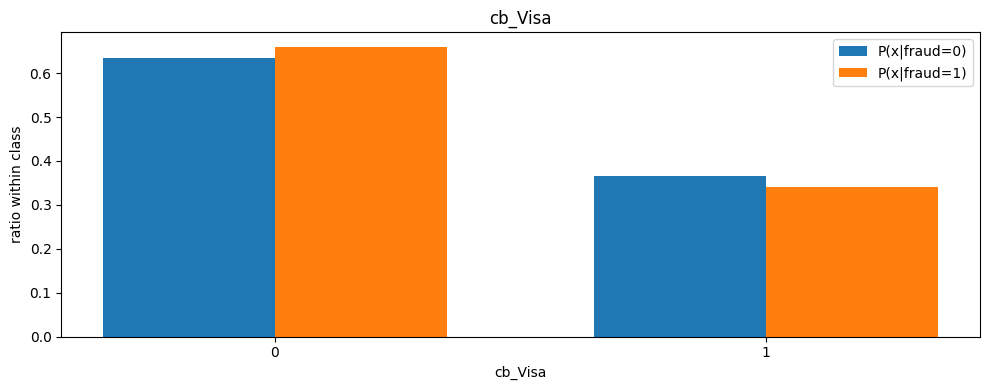

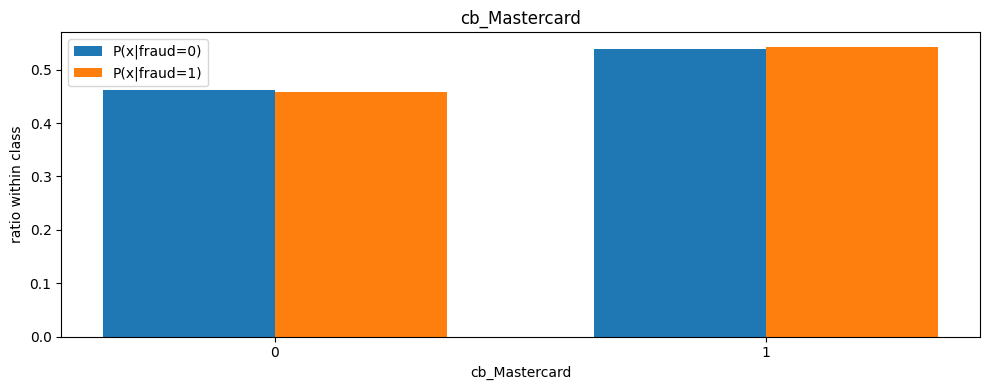

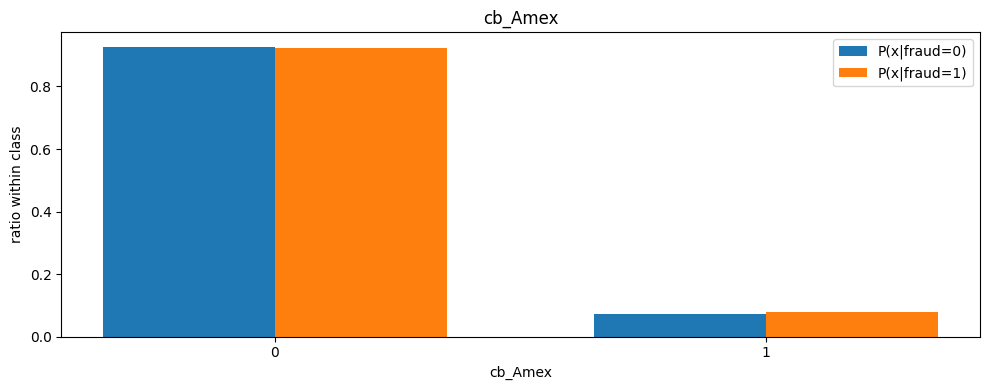

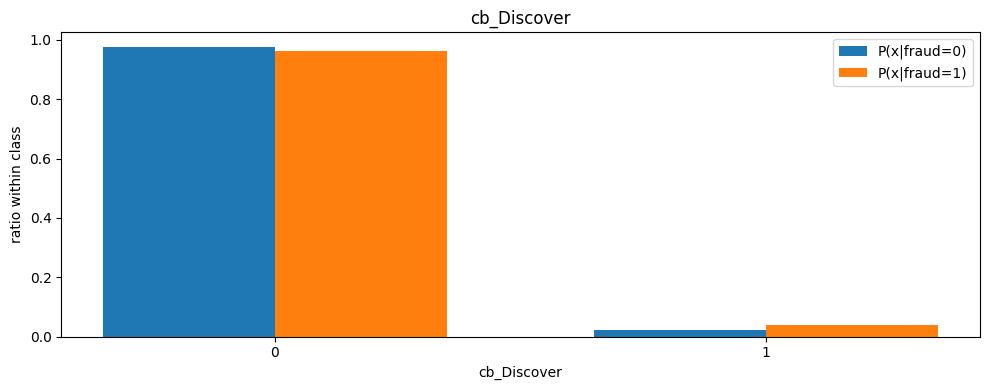

In [ ]:
FEATURES = [
  "cb_Visa",
  "cb_Mastercard",
  "cb_Amex",
  "cb_Discover",]
for c in FEATURES:
    plot_class_ratio_only(df, c, LABEL_COL, bins=20, clip_q=(0.01, 0.99), min_bin_count=30)

In [ ]:
for i in FEATURES:
    print(f"[{i}]")
    print(evaluate_numeric_feature(df, i))
    print("\n")

[cb_Visa]
KS_p               0.000700
MW_p               0.000035
Cohen_d           -0.051245
Odds_Ratio         0.897538
Logit_p            0.000035
PR_AUC             0.011097
n             609655.000000
pos_rate           0.010823
dtype: float64


[cb_Mastercard]
KS_p               0.999658
MW_p               0.482357
Cohen_d            0.008696
Odds_Ratio         1.017609
Logit_p            0.482362
PR_AUC             0.010869
n             609655.000000
pos_rate           0.010823
dtype: float64


[cb_Amex]
KS_p               0.997201
MW_p               0.126587
Cohen_d            0.018910
Odds_Ratio         1.073047
Logit_p            0.126664
PR_AUC             0.010879
n             609655.000000
pos_rate           0.010823
dtype: float64


[cb_Discover]
KS_p          8.940614e-02
MW_p          3.549565e-16
Cohen_d       1.009249e-01
Odds_Ratio    1.676407e+00
Logit_p       7.414930e-16
PR_AUC        1.109269e-02
n             6.096550e+05
pos_rate      1.082251e-02
dtype: floa

---

## 10) 위치 기반(거래 위치 vs 거주지)

* `distance_from_home`

**분석 포인트**

* 거리 분포(0 근처 mass vs 장거리 tail)
* fraud에서 장거리/이상 이동이 증가하는지
* 금액/시간과 상호작용(야간 + 장거리 + 온라인/오프라인 등)

---



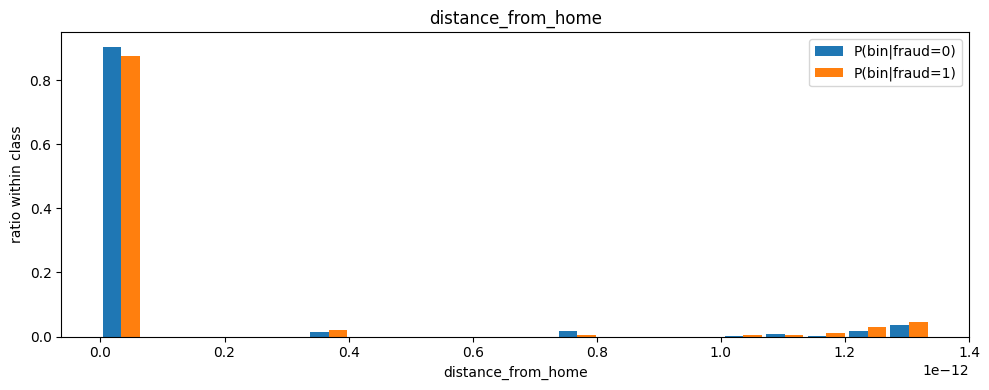

In [ ]:
plot_class_ratio_only(df, "distance_from_home", LABEL_COL, bins=20, clip_q=(0.01, 0.99), min_bin_count=30)

In [ ]:
evaluate_numeric_feature(df, "distance_from_home")

/home/nakyung/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


KS_p          7.410627e-07
MW_p          8.356106e-16
Cohen_d       1.074004e-01
Odds_Ratio    9.998675e-01
Logit_p       1.000000e+00
PR_AUC        1.192782e-02
n             6.096550e+05
pos_rate      1.082251e-02
dtype: float64

---

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5332948 entries, 0 to 5332978
Data columns (total 62 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   date                            datetime64[ns]
 1   client_id                       int64         
 2   card_id                         int64         
 3   amount                          float32       
 4   merchant_id                     int64         
 5   mcc                             object        
 6   fraud                           int8          
 7   has_error                       int8          
 8   err_bad_card_number             int8          
 9   err_bad_expiration              int8          
 10  err_bad_cvv                     int8          
 11  err_bad_pin                     int8          
 12  err_bad_zipcode                 int8          
 13  err_insufficient_balance        int8          
 14  err_technical_glitch            int8          
 15  tx_